<center> <img src="https://miro.medium.com/v2/resize:fit:1250/format:webp/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" width=25% > </center>

<br><br>

<center>
    <font size="6">Final Lab (Part 1): Keypoint Detection, Bag of Visual Words and Image Classification</font>
</center>
<center>
    <font size="4">Computer Vision 1 University of Amsterdam</font>
</center>
<center>
    <font size="4">Due 23:59PM, 24th October, 2025 (Amsterdam time)</font>
</center>

<br><br>

***

<br><br>

<center>

Student1 ID:  \
Student1 Name:

Student2 ID: \
Student2 Name:

Student3 ID: \
Student3 Name:

( Student4 ID: \
Student4 Name: )

</center>

### **General Guidelines**

Your code must be handed in this Jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Final Lab (Part 1) Assignment. Please also fill out your names and IDs above.

For full credit, make sure your notebook follows these guidelines:

- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Understand the problem as much as you can. When answering a question, provide evidence (qualitative and/or quantitative results, references to papers, figures, etc.) to support your arguments. Not everything might be explicitly asked for, so think about what might strengthen your arguments to make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Add a number, a title, and, if applicable, the name and unit of variables in a table, and name and unit of axes and legends in a figure.

**Late submissions are not allowed.** Assignments submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance to avoid last-minute system failure issues.

**Environment:** Since this is a project-based assignment, you are free to use any feature descriptor and machine learning tools (e.g., K-means, SVM). You should use Python for your implementation. You are free to use any Python library for this assignment, but make sure to provide a conda environment file!

**Plagiarism Note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious offense and any misconduct will be addressed according to university regulations. This includes using generative tools such as ChatGPT.

**Ensure that you save all results/answers to the questions (even if you reuse some code).**

### **Report Preparation**

Your tasks include the following:

1. **Report Preparation:** For both parts of the final project, students are expected to prepare a report. The report should include all details on implementation approaches, analysis of results for different settings, and visualizations illustrating experiments and performance of your implementation. Grading will be based on the report, so it should be as self-contained as possible. If the report contains faulty results or ambiguities, TAs can refer to your code for clarification. Only section 10 of this notebook should **not** be included in the report.

2. **Explanation of Results:** Do not just provide numbers without explanation. Discuss different settings to show your understanding of the material and processes involved.

3. **Quantitative Evaluation:** For quantitative evaluation, you are expected to provide the results based on the mAP (mean Average Precision) metric. You should report the mAP for each experimental setup.

4. **Qualitative Evaluation:** For qualitative evaluation, you are expected to visualize the top-5 and bottom-5 ranked test images (based on classifier confidence for the target class) per setup. Provide a figure for each experimental setup Visual elements such as charts, graphs, and plots are always useful. Keep this in mind while writing your reports.

5. **Aim:** Understand the basic Image Classification pipeline using a traditional Bag of Visual Words method.

6. **Working on Assignments:** Students should work in assigned groups for **two** weeks. Any questions can be discussed on ED.

    - **Submission:** Submit your source code and report together in a zip file (`ID1_ID2_ID3_part1.zip`). The report should be a maximum of 10 pages (single-column, including tables and figures, excluding references and appendix). Express thoughts concisely. Tables and figures must be accompanied by a description. Number them and, if applicable, name variables in tables, and label axes in figures.

7. **Hyperparameter Search:** In your experiments, remember to perform a hyperparameter search to find the optimal settings for your classifier. Clearly document the search process, the parameters you explored, and how they influenced the performance of your model.

8. **Format and Testing:** The report should be in **PDF format**, and the code in **.ipynb format**. Test that all functionality works as expected in the notebook.

### **Overview**

- [Section 1: Data Preparation (0 points)](#section-1)
- [Section 2: Keypoint Detection and Feature Extraction (3 points)](#section-2)
- [Section 3: Building the Visual Vocabulary (3 points)](#section-3)
- [Section 4: Encoding Train Image Features (3 points)](#section-4)
- [Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)](#section-5)
- [Section 6: Encoding Test Image Features (0 points)](#section-6)
- [Section 7: Training the Classifiers (5 points)](#section-7)
- [Section 8: Evaluating the Classifiers (12 points)](#section-8)
- [Section 9: Hyperparameter Search (16 points)](#section-9)
- [Section 10: Using CLIP for Image Classification (5 points)](#section-10)
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

### **Section 1: Data Preparation (0 points)**

The goal of this lab is to implement an image classification system that can identify objects from a given set of classes. You will perform a 5-class image classification using a bag-of-words approach ([reference](http://www.robots.ox.ac.uk/~az/icvss08_az_bow.pdf)). The classes for this task are:

1. **Frog**
2. **Automobile**
3. **Bird**
4. **Cat**
5. **Deer**

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) will be used for this task. This dataset contains 32x32 pixel RGB images, divided into sub-directories with 5000 training images and 1000 test images for each class.

The dataset will be automatically downloaded using the code provided in this notebook. You will need to perform training on the training set, which will later be divided into two subsets: one for building the visual vocabulary and another for training the classifier. Using more samples for training generally results in better performance. However, if computational resources are limited, you may use fewer training images to save time, as long as at least 500 images per class are included.

The system must be tested using the specified subset of test images. Use all 1000 test images (per class) to observe the full performance of the model. Ensure that test images are excluded from training to maintain a fair comparison.

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define total train and test sizes
total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Define the number of Visual Words
num_of_visual_words = 1000  # Default value for number of visual words

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=test_batch_size, shuffle=False)

# Extract all training data and remapped labels
train_images, _ = next(iter(train_data_loader))
train_labels = torch.tensor(train_mapped_labels)

train_images = train_images.permute(0, 2, 3, 1)
print(f"Filtered train data: {train_images.shape}")
print(f"Filtered train labels: {train_labels.shape}")

# Extract all test data and remapped labels
test_images, _ = next(iter(test_data_loader))
test_labels = torch.tensor(test_mapped_labels)

test_images = test_images.permute(0, 2, 3, 1)
print(f"Filtered test data: {test_images.shape}")
print(f"Filtered test labels: {test_labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Filtered train data: torch.Size([5000, 32, 32, 3])
Filtered train labels: torch.Size([5000])
Filtered test data: torch.Size([1000, 32, 32, 3])
Filtered test labels: torch.Size([1000])


<a id="section-2"></a>
### **Section 2: Keypoint Detection and Feature Extraction (3 points)**

In this section, you will work on detecting keypoints and extracting features from the dataset. Your task is to use **two different feature extraction techniques** to identify keypoints in the images. Visualize two images from each of the five classes (Frog, Automobile, Bird, Cat, Deer) for both feature extraction techniques. For each image, draw circles around the detected keypoints that represent their size.

This step is essential to understand how different feature extractors behave across various classes, setting the foundation for further analysis and classification in later steps.

**Hint:** You can use the OpenCV library to detect keypoints and extract features. You can also upscale the images to improve the visualization of the keypoints.

In [18]:
def denormalize_image(img_tensor):
    """Convert normalized tensor image to uint8 numpy array"""
    img = img_tensor.numpy()
    img = (img * 0.5 + 0.5) * 255  # Denormalize from [-1, 1] to [0, 255]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img


def detect_keypoints_and_extract(image, detector):
    """
    Detect keypoints and extract descriptors

    Args:
        image: input image
        detector: feature detector object
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors


def visualize_keypoints(images, labels, class_names, detector_name, detector, num_images_per_class=2, upscale_factor=4):
    """
    Visualize keypoints for selected images from each class

    Args:
        images: tensor of images
        labels: tensor of labels
        class_names: list of class names
        detector_name: name of the detector
        detector: detector object
        num_images_per_class: number of images to show per class
        upscale_factor: factor to upscale images for better visualization
    """

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(6*num_images_per_class, 6*num_classes))

    if num_images_per_class == 1: axes = axes.reshape(-1, 1)

    fig.suptitle(f'Keypoint Detection with {detector_name}', fontsize=16, y=0.995)

    for class_idx in range(num_classes):
        # Get indices for the first num_images_per_class images of current class
        class_mask = labels == class_idx # <- mask
        class_indices = torch.where(class_mask)[0]
        selected_indices = class_indices[:num_images_per_class]

        for img_idx, idx in enumerate(selected_indices):
            img_tensor = images[idx]
            img = denormalize_image(img_tensor)

            # upscale
            if upscale_factor != 1: img = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)

            # detect keypoints
            keypoints, _ = detect_keypoints_and_extract(img, detector)

            # draw keypoints
            img_with_keypoints = cv2.drawKeypoints(
                img,
                keypoints,
                None,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
                color=(0, 255, 0)
            )


            ax = axes[class_idx, img_idx]
            ax.imshow(img_with_keypoints)
            ax.set_title(f'{class_names[class_idx]}\n{len(keypoints)} keypoints',  fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    return fig



SIFT



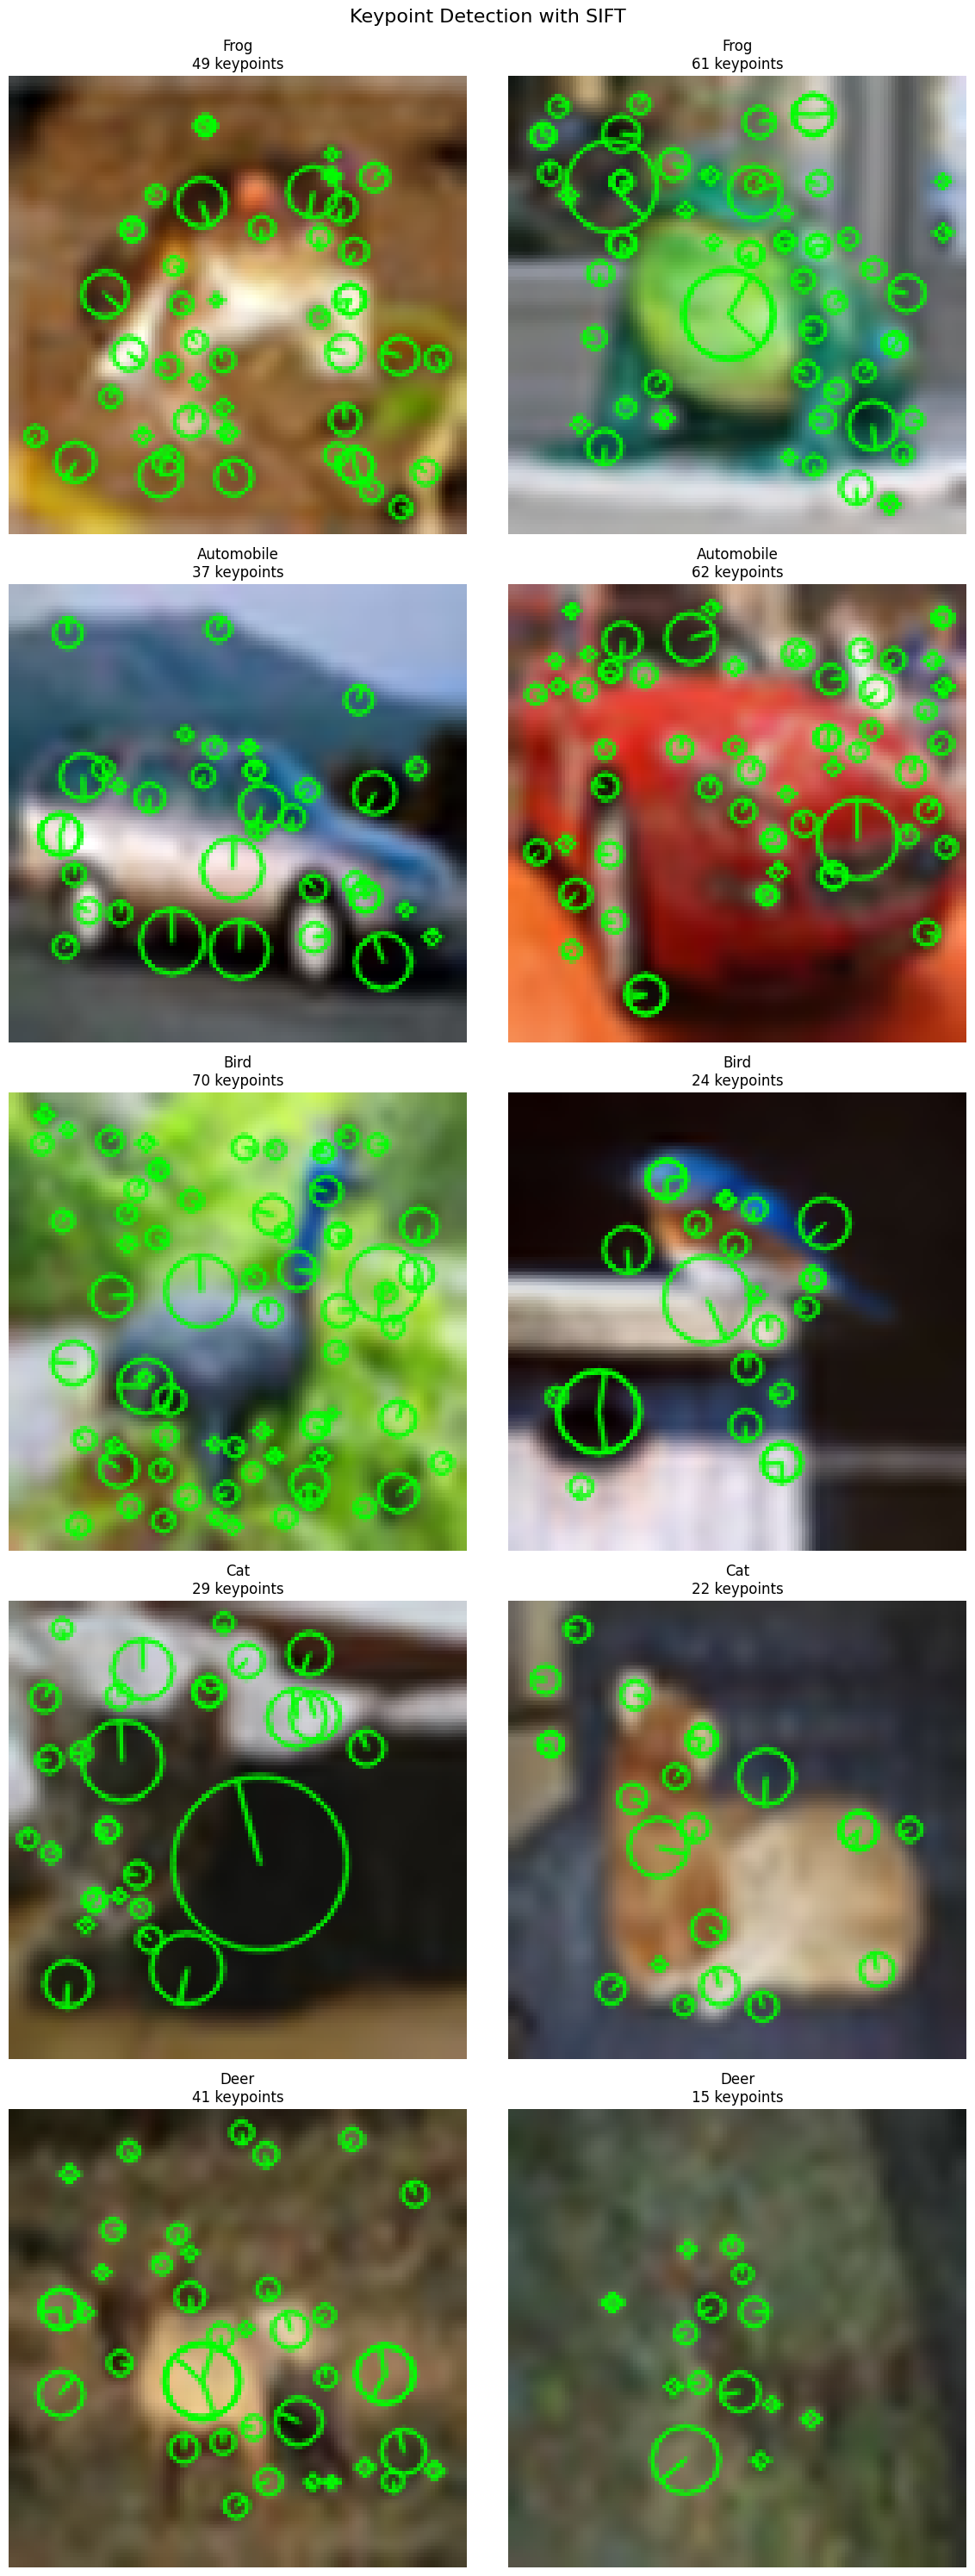


ORB


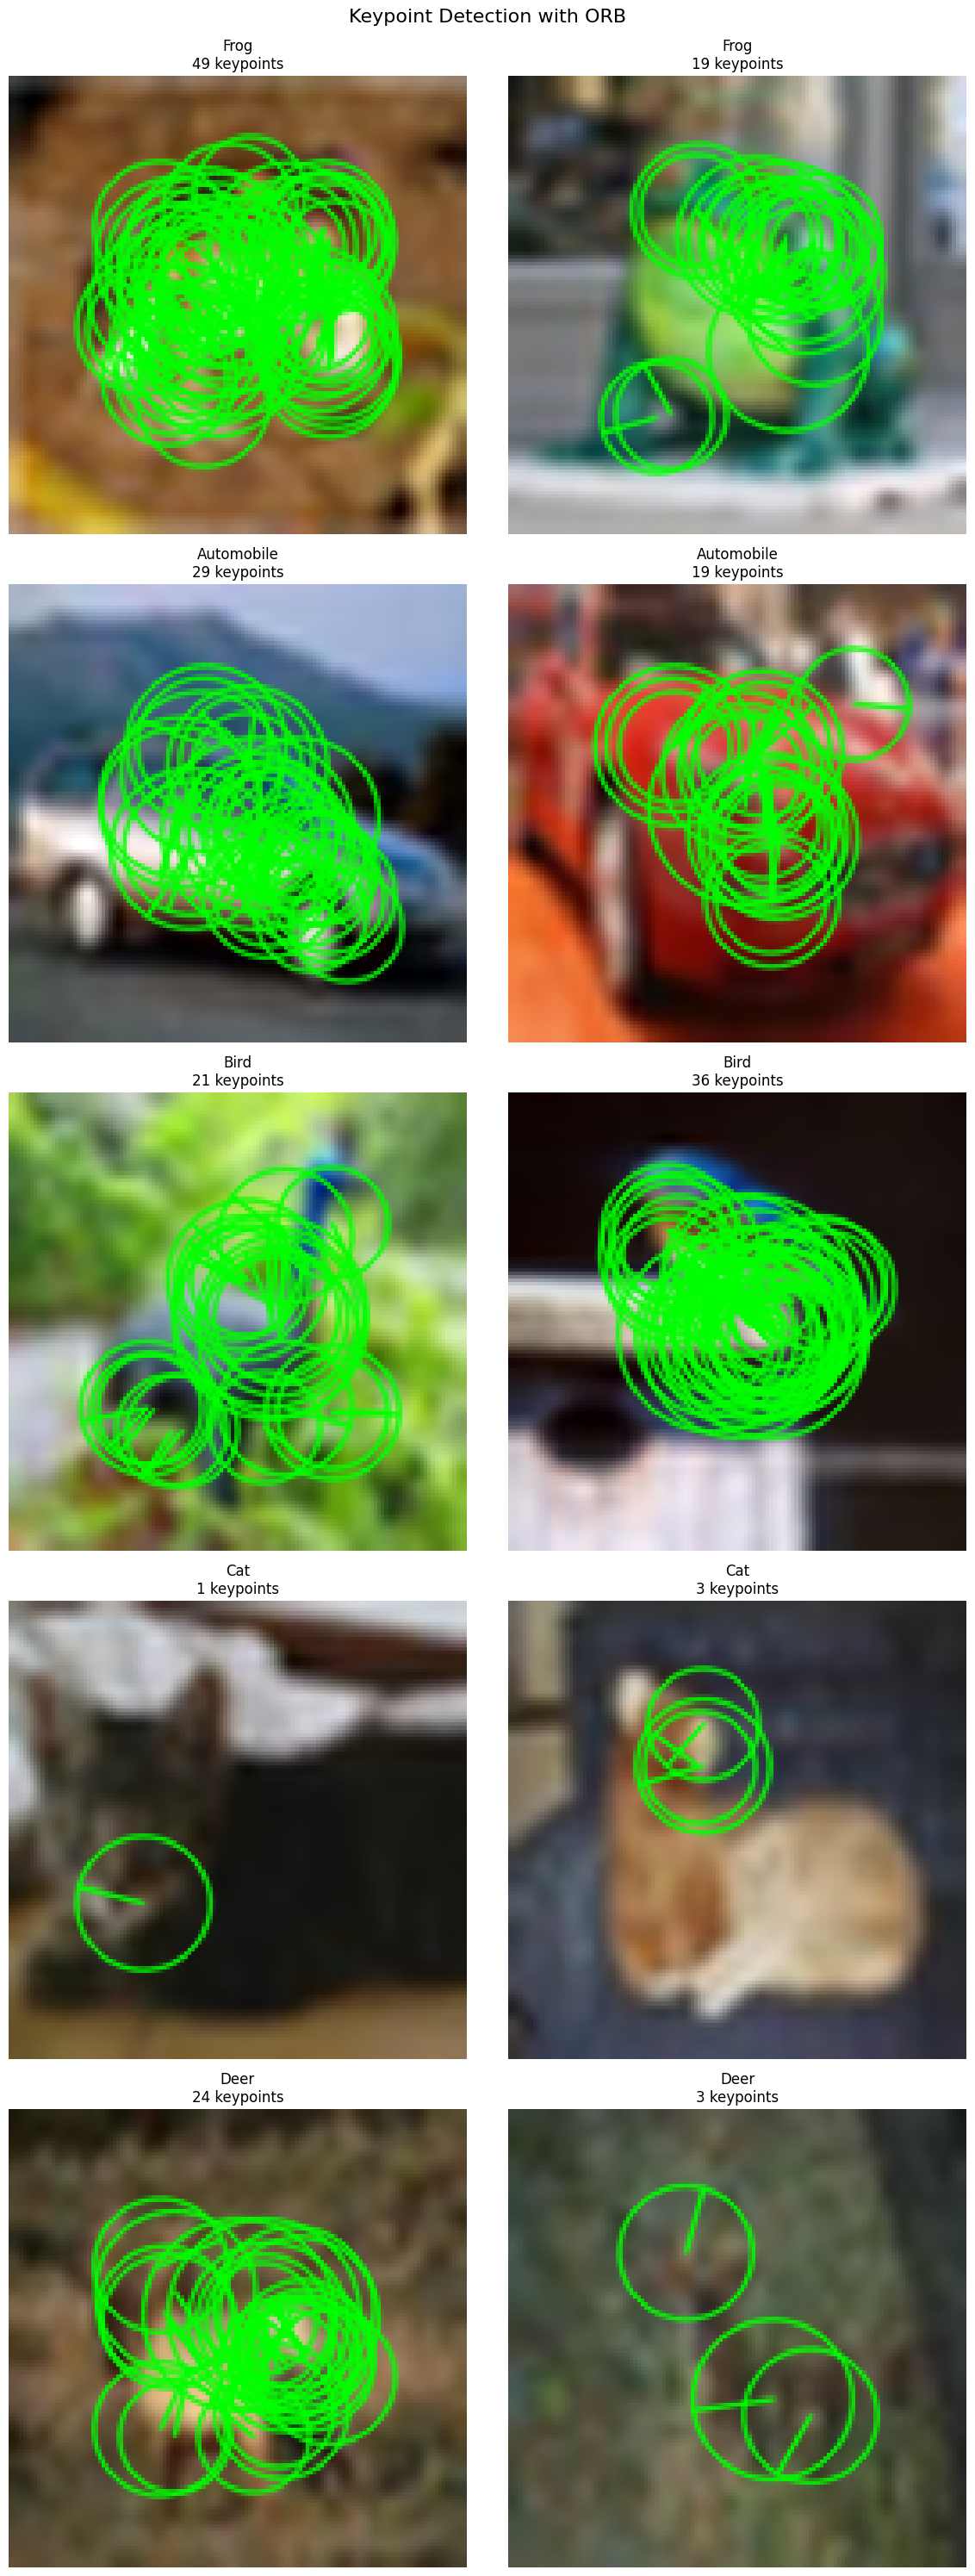

In [19]:

label_to_class_name = {
    0: 'Frog',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer'
}
class_names = [label_to_class_name[i] for i in range(len(label_to_class_name))]


# 1. SIFT

print("\n" + "="*60)
print("SIFT")
print("="*60)
print()

# Initialize detector
sift = cv2.SIFT_create()

# Visualize keypoints
fig1 = visualize_keypoints(
    train_images,
    train_labels,
    class_names,
    'SIFT',
    sift,
    num_images_per_class=2,
    upscale_factor=4
)


# 2. ORB

print("\n" + "="*60)
print("ORB")
print("="*60)

# Initialize detector
orb = cv2.ORB_create(nfeatures=1000)

# Visualize ORB keypoints
fig2 = visualize_keypoints(
    train_images,
    train_labels,
    class_names,
    'ORB',
    orb,
    num_images_per_class=2,
    upscale_factor=4
)


In [20]:
def compute_keypoint_stats(images, labels, class_names, detector, upscale_factor=4):
    """
    Compute average number of keypoints per class
    """

    stats = {name: [] for name in class_names}

    for idx in range(len(images)):
        img = denormalize_image(images[idx])
        if(upscale_factor != 1): img = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
        keypoints, _ = detect_keypoints_and_extract(img, detector)
        class_name = class_names[labels[idx].item()]
        stats[class_name].append(len(keypoints))

    for class_name in class_names:
        avg_kp = np.mean(stats[class_name])
        std_kp = np.std(stats[class_name])
        print(f"  {class_name:12s}: {avg_kp:6.2f} ± {std_kp:5.2f} keypoints")

    return stats

In [21]:
# Compute statistics for both detectors
sample_size = 100

sample_indices = []
for class_idx in range(num_classes):
    class_mask = train_labels == class_idx
    class_indices = torch.where(class_mask)[0][:sample_size]
    sample_indices.extend(class_indices.tolist())

sample_images = train_images[sample_indices]
sample_labels = train_labels[sample_indices]


print("SIFT statistics:")
stats_sift = compute_keypoint_stats(sample_images, sample_labels, class_names, sift, 4)
print("\nORB statistics:")
stats_orb = compute_keypoint_stats(sample_images, sample_labels, class_names, orb, 4)



SIFT statistics:
  Frog        :  67.82 ± 28.49 keypoints
  Automobile  :  56.25 ± 22.58 keypoints
  Bird        :  39.22 ± 20.57 keypoints
  Cat         :  43.57 ± 22.87 keypoints
  Deer        :  43.87 ± 21.62 keypoints

ORB statistics:
  Frog        :  36.17 ± 24.76 keypoints
  Automobile  :  34.90 ± 19.50 keypoints
  Bird        :  18.32 ± 14.71 keypoints
  Cat         :  22.22 ± 19.33 keypoints
  Deer        :  21.37 ± 16.60 keypoints


<a id="section-3"></a>
### **Section 3: Building the Visual Vocabulary (3 points)**

In this section, the task is to create a visual vocabulary by clustering feature descriptors extracted from the images using K-Means. Each cluster center in this vocabulary will represent a visual word. Use the two different extraction techniques you implemented to extract descriptors from a subset of training images that includes all categories, and then apply K-Means clustering to build the vocabulary. The number of clusters is fixed at 1000, but you can experiment with different values when you are tuning the hyperparameters in section 9.

To examine the effect of different amounts of training data, build separate visual vocabularies using 30%, 40%, and 50% subsets of the training images. For faster clustering, the `faiss` library can be used, as it provides an efficient implementation of K-Means. Then, visualize the first 10 clusters for each feature extraction technique and each subset size using PCA to reduce the dimensions to 2D.

**Hints:**
1. Begin by debugging the code with a small number of input images to ensure it functions correctly before running it on larger datasets.
2. If the `faiss` library is not available, K-Means clustering can also be performed using the `sklearn` or `scipy` libraries.
3. For visualization, use PCA from `sklearn.decomposition` to reduce the high-dimensional descriptors to 2D. Display up to 10 clusters in the scatter plot to maintain clarity.

In [22]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

data_percentages = [0.3, 0.4, 0.5]  # 30%, 40%, 50% of training data

upscale_factor = 4


def build_visual_vocabulary(descriptors, n_clusters=1000):
    """
    Build visual vocabulary via k-means clustering

    Args:
        descriptors: numpy array of descriptors
        n_clusters: number of clusters

    Returns:
        kmeans: fitted K-Means model
        cluster_centers: cluster centers (visual words)
    """

    kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        max_iter=100,
        verbose=0,
        n_init=5,
        batch_size=1000
    )

    kmeans.fit(descriptors)

    return kmeans, kmeans.cluster_centers_


def extract_all_descriptors(images, detector, subset_percentage, upscale_factor=4):
    """
    Extract descriptors from a subset of images

    Args:
        images: tensor of images
        detector: feature detector
        subset_percentage: percentage training data to use
        upscale_factor: factor to upscale images

    Returns:
        all_descriptors: numpy array of all descriptors
        num_images_used: number of images processed
    """
    num_images = int(len(images) * subset_percentage)
    all_descriptors = []
    images_with_descriptors = 0

    print(f"Extracting descriptors from {num_images} images (params=upscale_factor={upscale_factor}, detector={detector.__class__.__name__})...")

    for idx in range(num_images):
        # Denormalize image
        img = denormalize_image(images[idx])

        # Detect keypoints and extract descriptors
        if upscale_factor != 1: img = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
        _, descriptors = detect_keypoints_and_extract(img, detector)

        if descriptors is not None and len(descriptors) > 0:
            all_descriptors.append(descriptors)
            images_with_descriptors += 1

    print(f"Descriptor extraction completed. Found {len(all_descriptors)} descriptors.")

    if len(all_descriptors) > 0: all_descriptors = np.vstack(all_descriptors)
    else: all_descriptors = np.array([])

    print(f"  Total descriptors extracted: {len(all_descriptors)}")
    print(f"  Images with descriptors: {images_with_descriptors}/{num_images}")

    return all_descriptors, num_images



def visualize_clusters_pca(descriptors, labels, cluster_centers, detector_name, subset_percentage, n=10):
    """
    Visualize clusters using PCA

    Args:
        descriptors: descriptors
        labels: cluster labels for each descriptor
        cluster_centers: cluster centers
        detector_name: name of the feature detector
        subset_percentage: percentage of training data used
        n: number of clusters to display (10)
    """
    print(f"visualizing first {n} clusters using PCA...")

    pca = PCA(n_components=2, random_state=42)

    # get only first n clusters
    mask = labels < n
    descriptors_subset = descriptors[mask]
    labels_subset = labels[mask]

    # transform descriptors and cluster centers to 2D
    descriptors_pca = pca.fit_transform(descriptors_subset)
    centers_pca = pca.transform(cluster_centers[:n])

    plt.figure(figsize=(12, 8))

    colors = plt.cm.tab10(np.linspace(0, 1, n))
    for cluster_id in range(n):
        cluster_mask = labels_subset == cluster_id
        plt.scatter(
            descriptors_pca[cluster_mask, 0],
            descriptors_pca[cluster_mask, 1],
            c=[colors[cluster_id]],
            label=f'Cluster {cluster_id}',
            alpha=0.6,
            s=20
        )

    plt.scatter(
        centers_pca[:, 0],
        centers_pca[:, 1],
        c='black',
        marker='X',
        s=200,
        edgecolors='white',
        linewidths=2,
        label='Cluster Centers',
        zorder=10
    )

    plt.title(f'Visual Vocabulary ({int(subset_percentage*100)}% training data, {detector_name})\n')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(loc='best', fontsize=9, ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



Building vocabulary for SIFT...
Processing for 30% of training data
Extracting descriptors from 1500 images (params=upscale_factor=4, detector=SIFT)...
Descriptor extraction completed. Found 1499 descriptors.
  Total descriptors extracted: 74604
  Images with descriptors: 1499/1500
visualizing first 10 clusters using PCA...


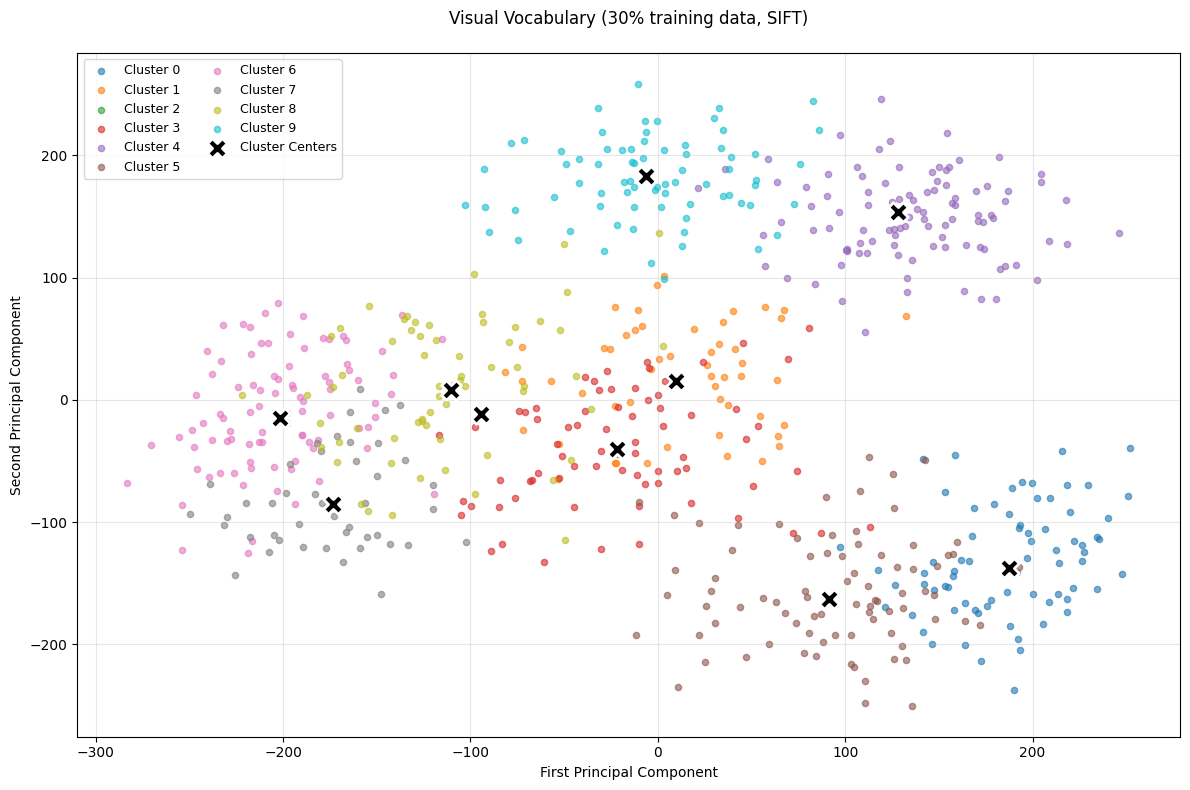

Processing for 40% of training data
Extracting descriptors from 2000 images (params=upscale_factor=4, detector=SIFT)...
Descriptor extraction completed. Found 1999 descriptors.
  Total descriptors extracted: 99484
  Images with descriptors: 1999/2000
visualizing first 10 clusters using PCA...


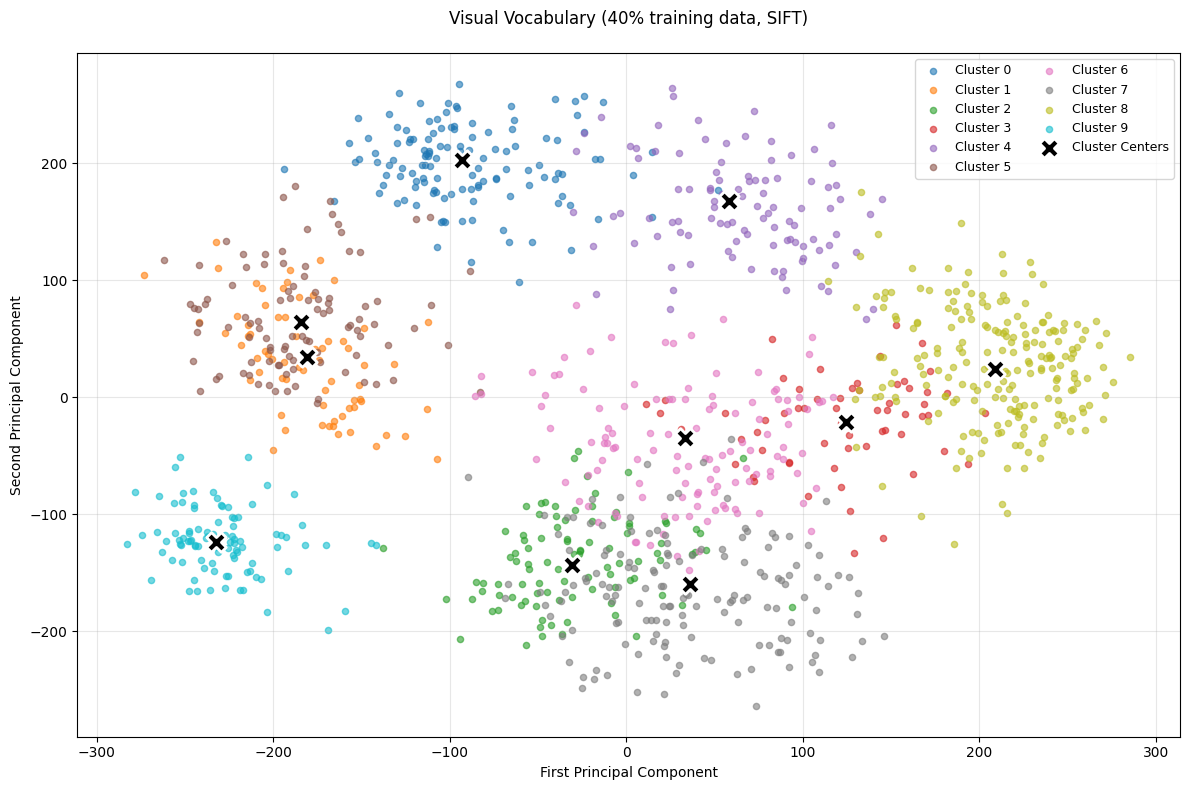

Processing for 50% of training data
Extracting descriptors from 2500 images (params=upscale_factor=4, detector=SIFT)...
Descriptor extraction completed. Found 2499 descriptors.
  Total descriptors extracted: 123607
  Images with descriptors: 2499/2500
visualizing first 10 clusters using PCA...


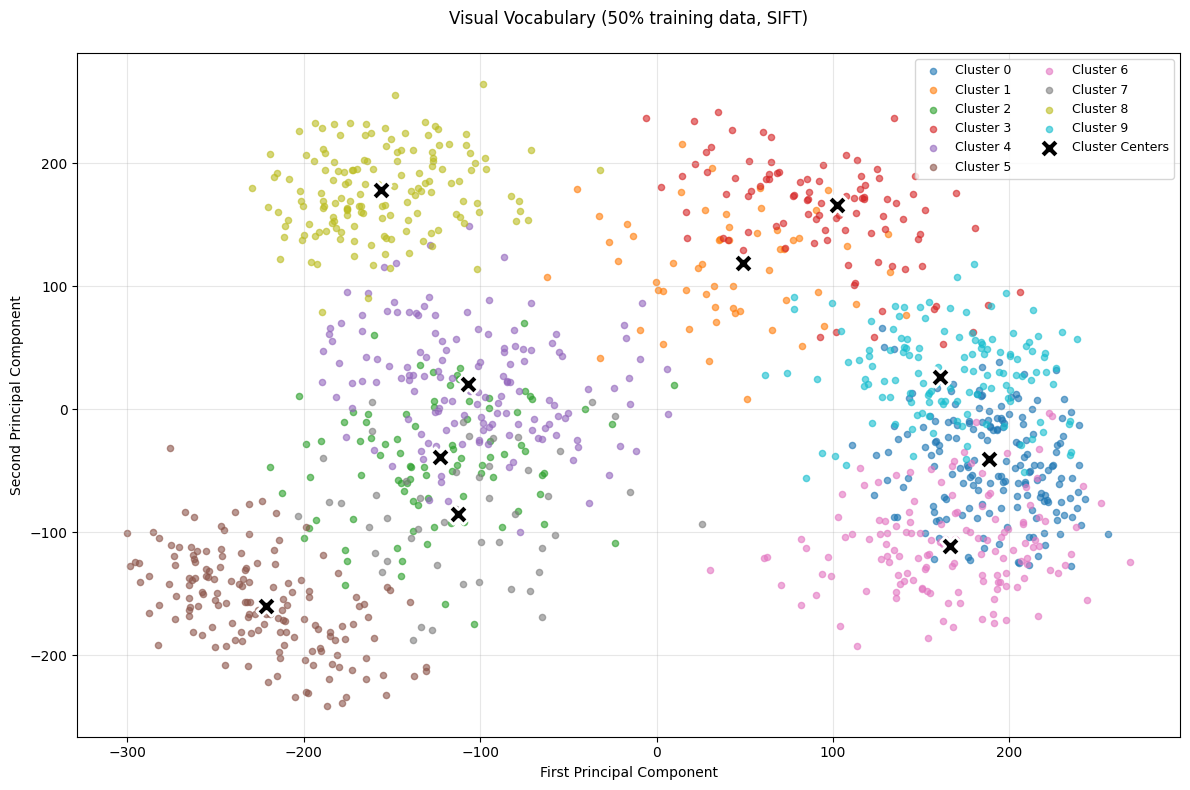


Building vocabulary for ORB...
Processing for 30% of training data
Extracting descriptors from 1500 images (params=upscale_factor=4, detector=ORB)...
Descriptor extraction completed. Found 1465 descriptors.
  Total descriptors extracted: 39959
  Images with descriptors: 1465/1500
visualizing first 10 clusters using PCA...


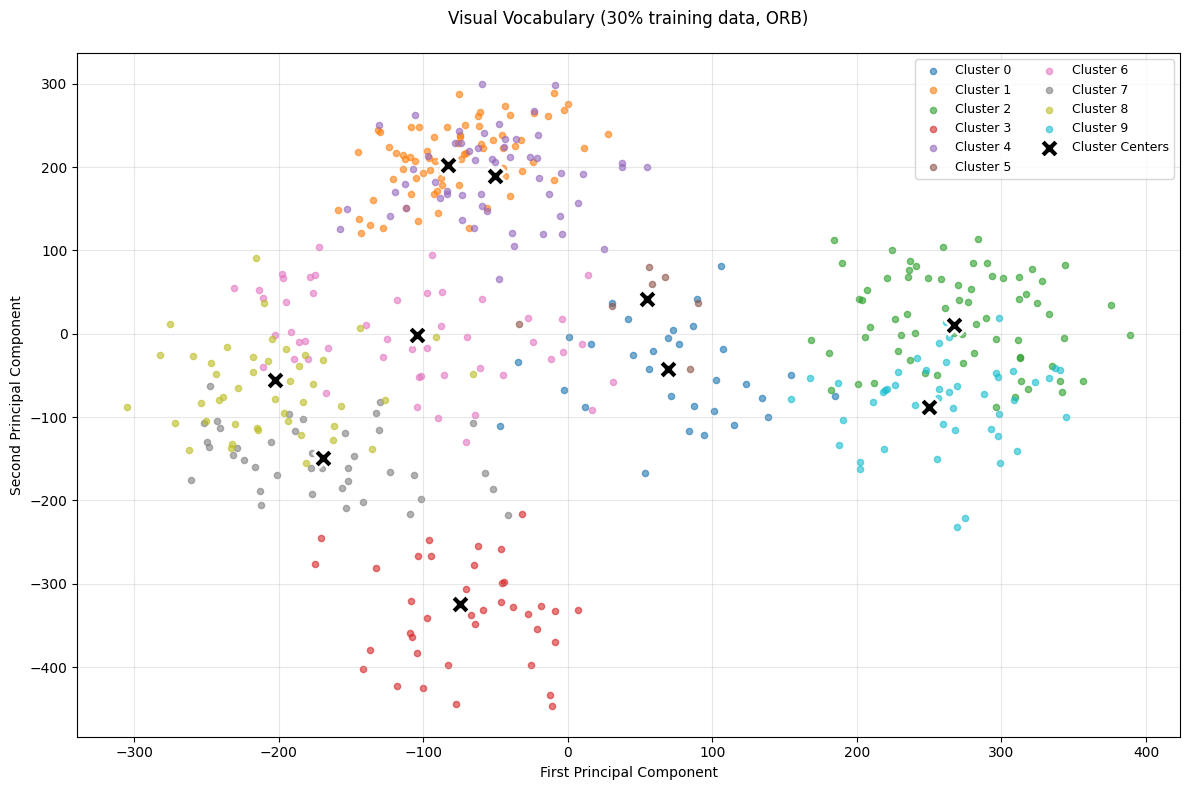

Processing for 40% of training data
Extracting descriptors from 2000 images (params=upscale_factor=4, detector=ORB)...
Descriptor extraction completed. Found 1956 descriptors.
  Total descriptors extracted: 53155
  Images with descriptors: 1956/2000
visualizing first 10 clusters using PCA...


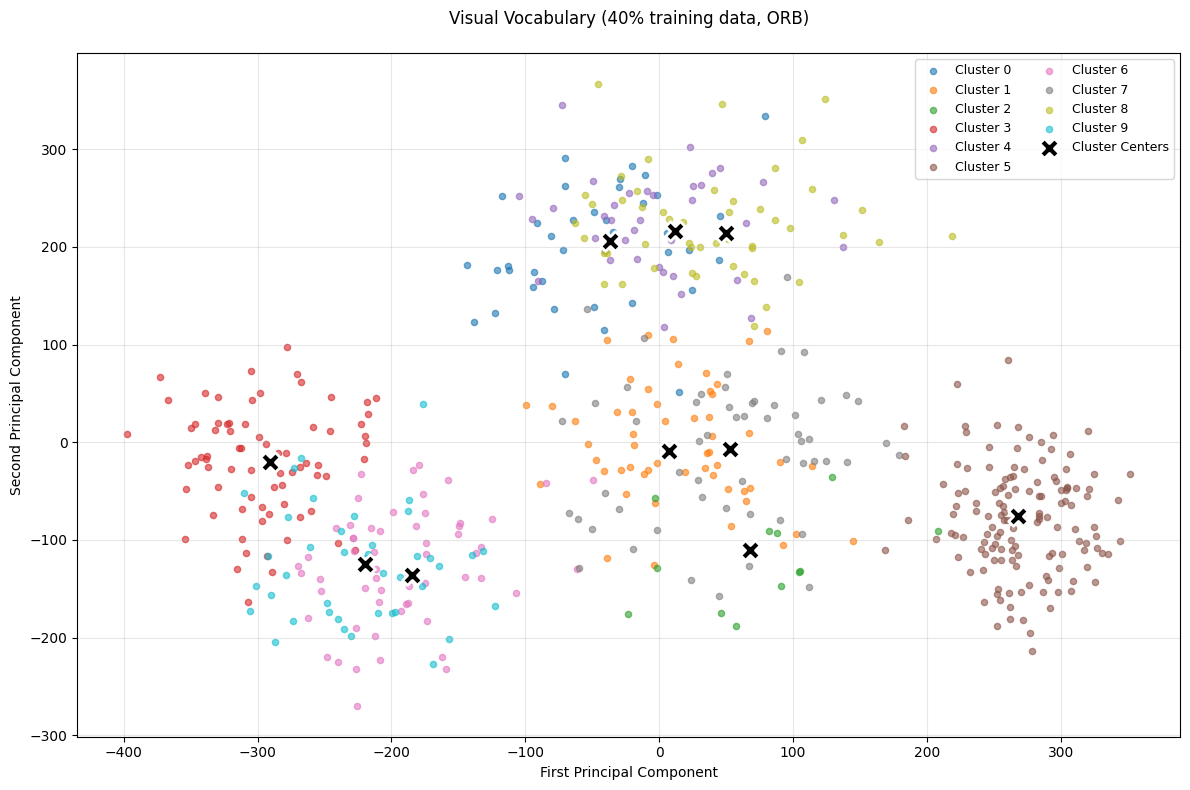

Processing for 50% of training data
Extracting descriptors from 2500 images (params=upscale_factor=4, detector=ORB)...
Descriptor extraction completed. Found 2445 descriptors.
  Total descriptors extracted: 65585
  Images with descriptors: 2445/2500
visualizing first 10 clusters using PCA...


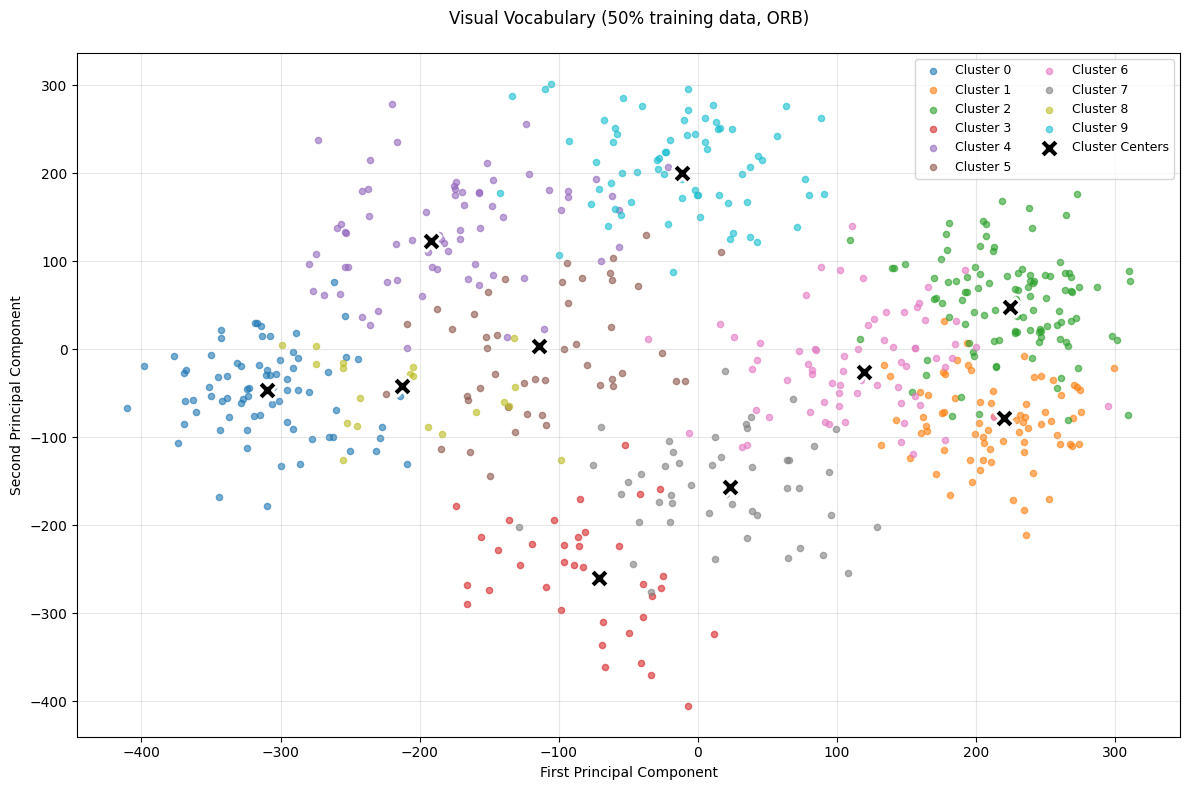


SUMMARY

SIFT:
  30% data: 74,604 descriptors from 1500 images → 1000 visual words
  40% data: 99,484 descriptors from 2000 images → 1000 visual words
  50% data: 123,607 descriptors from 2500 images → 1000 visual words

ORB:
  30% data: 39,959 descriptors from 1500 images → 1000 visual words
  40% data: 53,155 descriptors from 2000 images → 1000 visual words
  50% data: 65,585 descriptors from 2500 images → 1000 visual words


In [23]:
vocabularies = {
    'SIFT': {},
    'ORB': {}
}


for detector_name, detector in [('SIFT', sift), ('ORB', orb)]:
    print("\n" + "="*70)
    print(f"Building vocabulary for {detector_name}...")
    print("="*70)

    for percentage in data_percentages:
        print(f"Processing for {int(percentage*100)}% of training data")

        # extract descriptors
        voc_descriptors, voc_num_images = extract_all_descriptors(
            train_images, detector, percentage, upscale_factor
        )

        if len(voc_descriptors) == 0:
            print(f"No descriptors extracted for {detector}")
            continue

        voc_descriptors = voc_descriptors.astype(np.float32)

        # build vocabulary
        kmeans, cluster_centers = build_visual_vocabulary(
            voc_descriptors,
            n_clusters=num_of_visual_words
        )

        # Store vocabulary
        vocabularies[detector_name][percentage] = {
            'kmeans': kmeans,
            'cluster_centers': cluster_centers,
            'num_descriptors': len(voc_descriptors),
            'num_images': voc_num_images
        }

        # predict cluster labels for visualization
        labels = kmeans.predict(voc_descriptors)

        # Visualize clusters
        visualize_clusters_pca(
            voc_descriptors,
            labels,
            cluster_centers,
            detector_name,
            percentage,
            n=10
        )

# Summary of vocabularies built
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

for detector in ['SIFT', 'ORB']:
    print(f"\n{detector}:")
    for percentage in data_percentages:
        if percentage in vocabularies[detector]:
            vocab = vocabularies[detector][percentage]
            print(f"  {int(percentage*100)}% data: "
                  f"{vocab['num_descriptors']:,} descriptors from "
                  f"{vocab['num_images']} images → "
                  f"{num_of_visual_words} visual words")

<a id="section-4"></a>
### **Section 4: Encoding Train Image Features (3 points)**

In this section, the task is to encode image features using the visual vocabulary created earlier. Each image will be represented as a histogram of visual words, reflecting the frequency of each visual word in the image. This representation will allow for comparing images based on their visual content.

To encode an image, identify the nearest visual word (cluster center) for each feature descriptor extracted from the image. Construct a histogram that counts the occurrences of each visual word within the image. The final output will be a collection of histograms, one for each image, where each histogram serves as the feature representation of that image. Once again,  Use the two different extraction techniques you implemented to extract descriptors from the images. Then, encode the images using the visual vocabulary created in the previous step.

**Hint:** Utilize the `faiss` library for efficient nearest neighbor search when assigning each descriptor to the nearest cluster center in the visual dictionary. If `faiss` is not available, consider using other libraries, such as `scikit-learn`, for this step. Once the histograms are obtained, they will be used for further tasks, such as training a classifier. For now, perform the encoding only for the training set.

In [24]:
def encode_image_bovw(image, detector, vocabulary, upscale_factor=4):
    """
    Encode a single image as a histogram of visual words

    Args:
        image: normalized tensor image
        detector: feature detector
        vocabulary: k-means dictionary
        upscale_factor: upscale factor

    Returns:
        histogram: BoVW histogram
    """

    img = denormalize_image(image)

    # 1) extract descriptors
    if(upscale_factor != 1): img = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
    _, descriptors = detect_keypoints_and_extract(img, detector)

    # 2) init histogram
    num_words = len(vocabulary['cluster_centers'])
    histogram = np.zeros(num_words, dtype=np.float32)

    if descriptors is None or len(descriptors) == 0: return histogram

    descriptors = descriptors.astype(np.float32)

    # 3) predict visual words of the image
    kmeans = vocabulary['kmeans']
    labels = kmeans.predict(descriptors)

    # 4) create histogram
    for label in labels: histogram[label] += 1

    # 5) normalization
    if histogram.sum() > 0: histogram = histogram / histogram.sum()

    return histogram



def encode_dataset_bovw(images, labels, detector, vocabulary, detector_name, upscale_factor=4):
    """
    Encode all images in dataset as BoVW histograms

    Args:
        images: tensor of images
        labels: tensor of labels
        detector: feature detector
        vocabulary: vocabulary dictionary
        detector_name: name of detector (for printing)
        upscale_factor: factor to upscale images

    Returns:
        bovw_features: numpy array of shape (num_images, num_visual_words)
        valid_indices: indices of images with features (some might have no keypoints)
    """
    num_images = len(images)

    print(f"Encoding {num_images} images using {detector_name}...")

    bovw_features = []
    valid_indices = []

    for idx in range(num_images):
        # Encode image
        hist = encode_image_bovw(images[idx], detector, vocabulary, upscale_factor)
        if hist.sum() > 0:
            bovw_features.append(hist)
            valid_indices.append(idx)


    bovw_features = np.array(bovw_features, dtype=np.float32)
    valid_indices = np.array(valid_indices)

    print(f"Valid images: {len(valid_indices)}/{num_images}")
    print(f"Feature shape: {bovw_features.shape}")

    return bovw_features, valid_indices



def visualize_bovw_histograms(bovw_features, labels, class_names, detector_name, num_samples=3, n=50):
    """
    Visualize BoVW histograms

    Args:
        bovw_features: BoVW feature vectors (one histogram for each img)
        labels: image labels
        class_names: list of class names
        detector_name: name of detector
        num_samples: number of samples per class to show
        num_words_to_show: number of visual words to display in histogram
    """

    num_classes = len(class_names)

    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 10))
    fig.suptitle(f'BoVW - {detector_name}')

    for class_idx in range(num_classes):
        class_mask = labels == class_idx
        class_indices = np.where(class_mask)[0]

        # get samples
        if len(class_indices) >= num_samples: selected = np.random.choice(class_indices, num_samples, replace=False)
        else: selected = class_indices[:num_samples]

        for sample_idx, img_idx in enumerate(selected):
            ax = axes[class_idx, sample_idx]
            hist = bovw_features[img_idx]

            ax.bar(range(n), hist[:n], color='steelblue', alpha=0.7)


            if sample_idx == 0: ax.set_ylabel(class_names[class_idx], fontsize=11, fontweight='bold')
            if class_idx == 0: ax.set_title(f'Sample {sample_idx + 1}', fontsize=10)
            if class_idx == num_classes - 1: ax.set_xlabel('Visual Word', fontsize=9)

            ax.set_ylim([0, hist[:n].max() * 1.2 if hist[:n].max() > 0 else 0.1])
            ax.tick_params(labelsize=8)
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Encoding training images - SIFT

**********************************************************************
Processing 30% vocabulary

**********************************************************************
Encoding 5000 images using SIFT...
Valid images: 4998/5000
Feature shape: (4998, 1000)


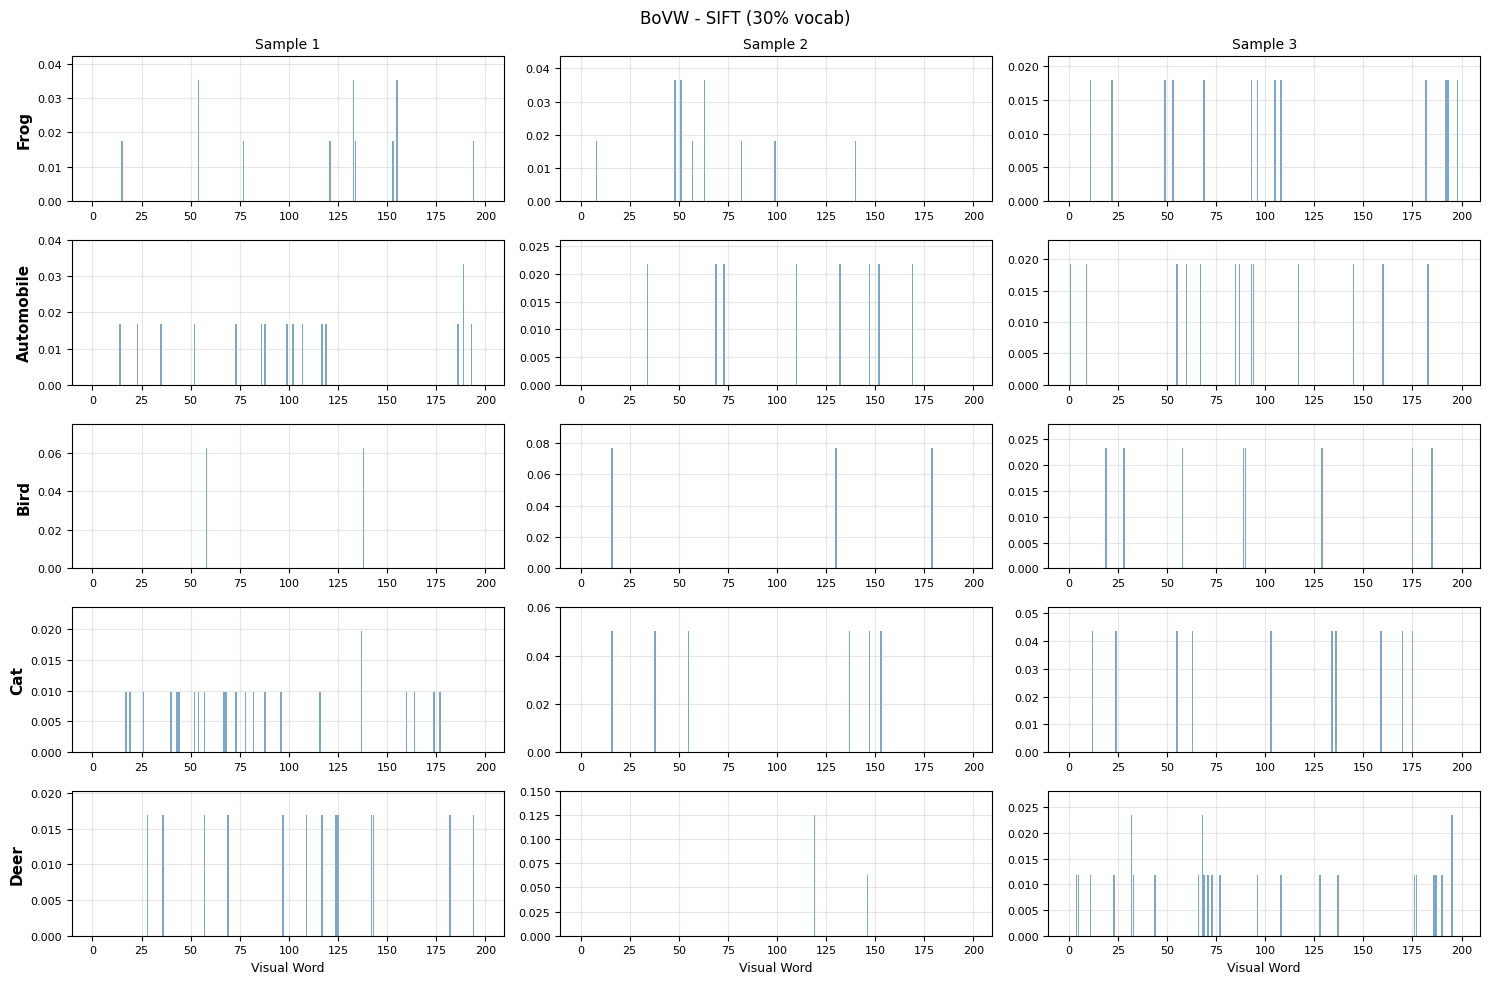


**********************************************************************
Processing 40% vocabulary

**********************************************************************
Encoding 5000 images using SIFT...
Valid images: 4998/5000
Feature shape: (4998, 1000)


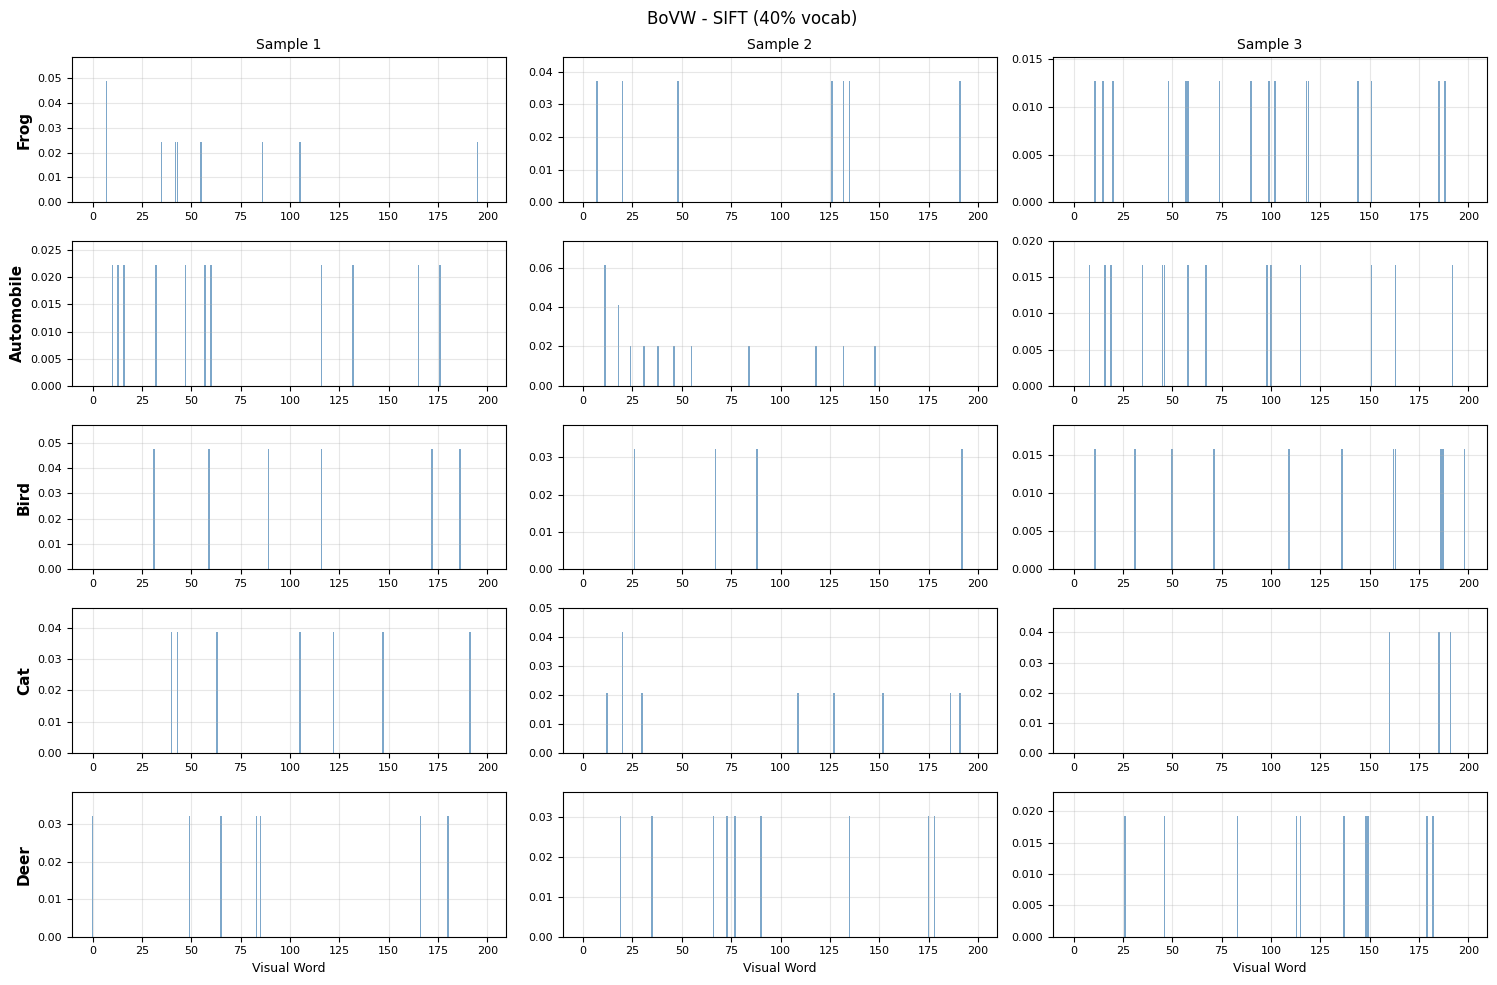


**********************************************************************
Processing 50% vocabulary

**********************************************************************
Encoding 5000 images using SIFT...
Valid images: 4998/5000
Feature shape: (4998, 1000)


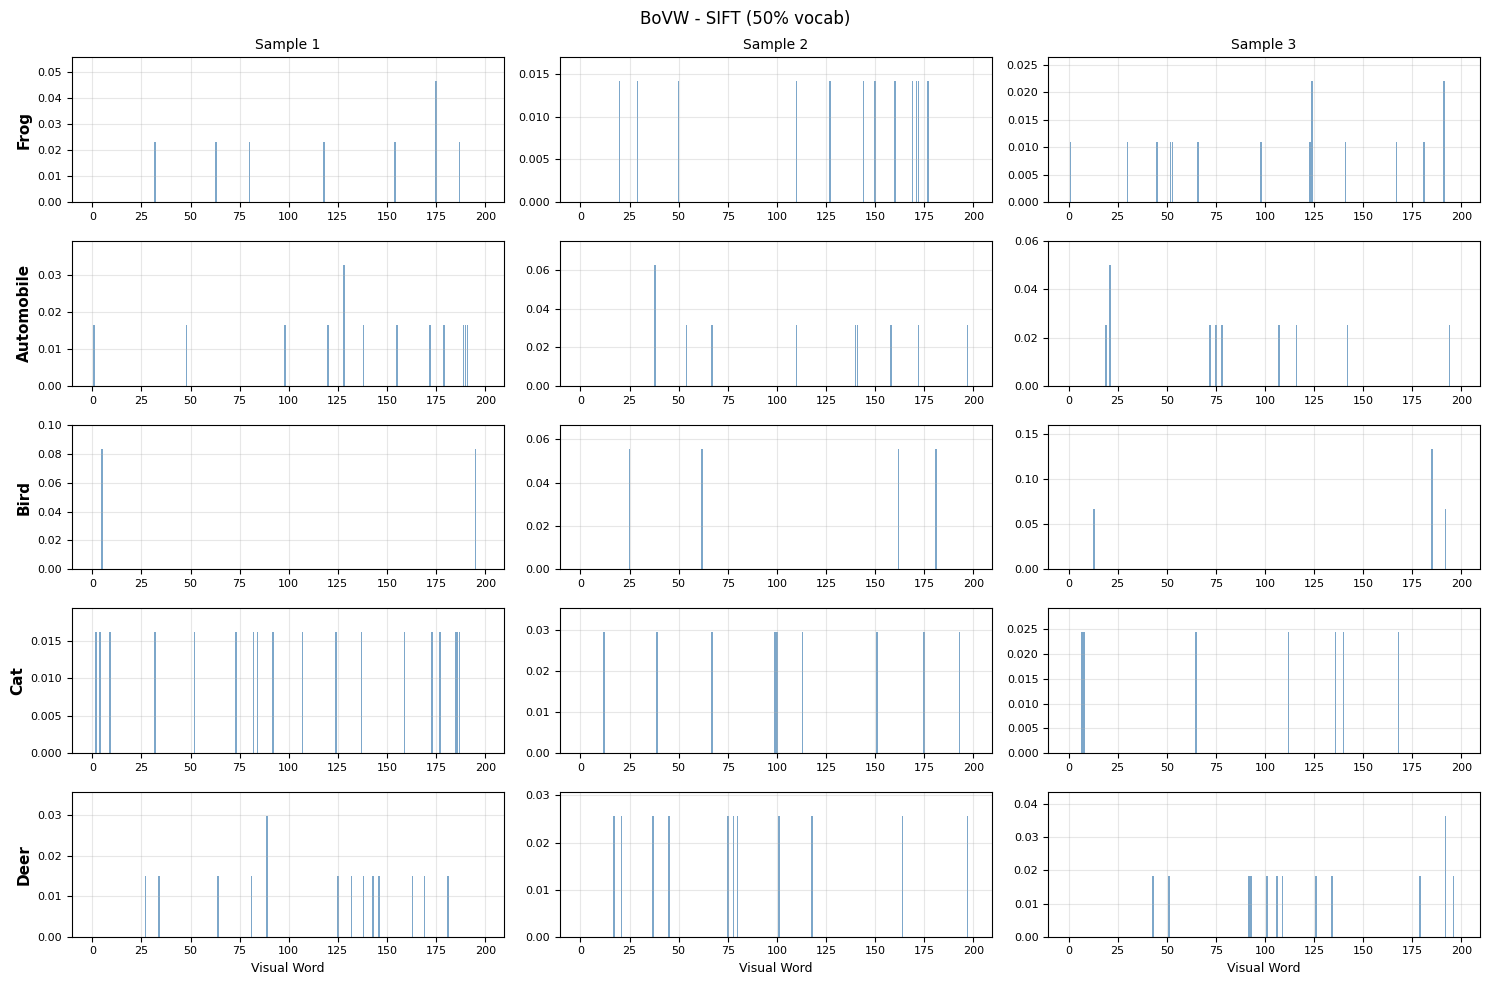


Encoding training images - ORB

**********************************************************************
Processing 30% vocabulary

**********************************************************************
Encoding 5000 images using ORB...
Valid images: 4890/5000
Feature shape: (4890, 1000)


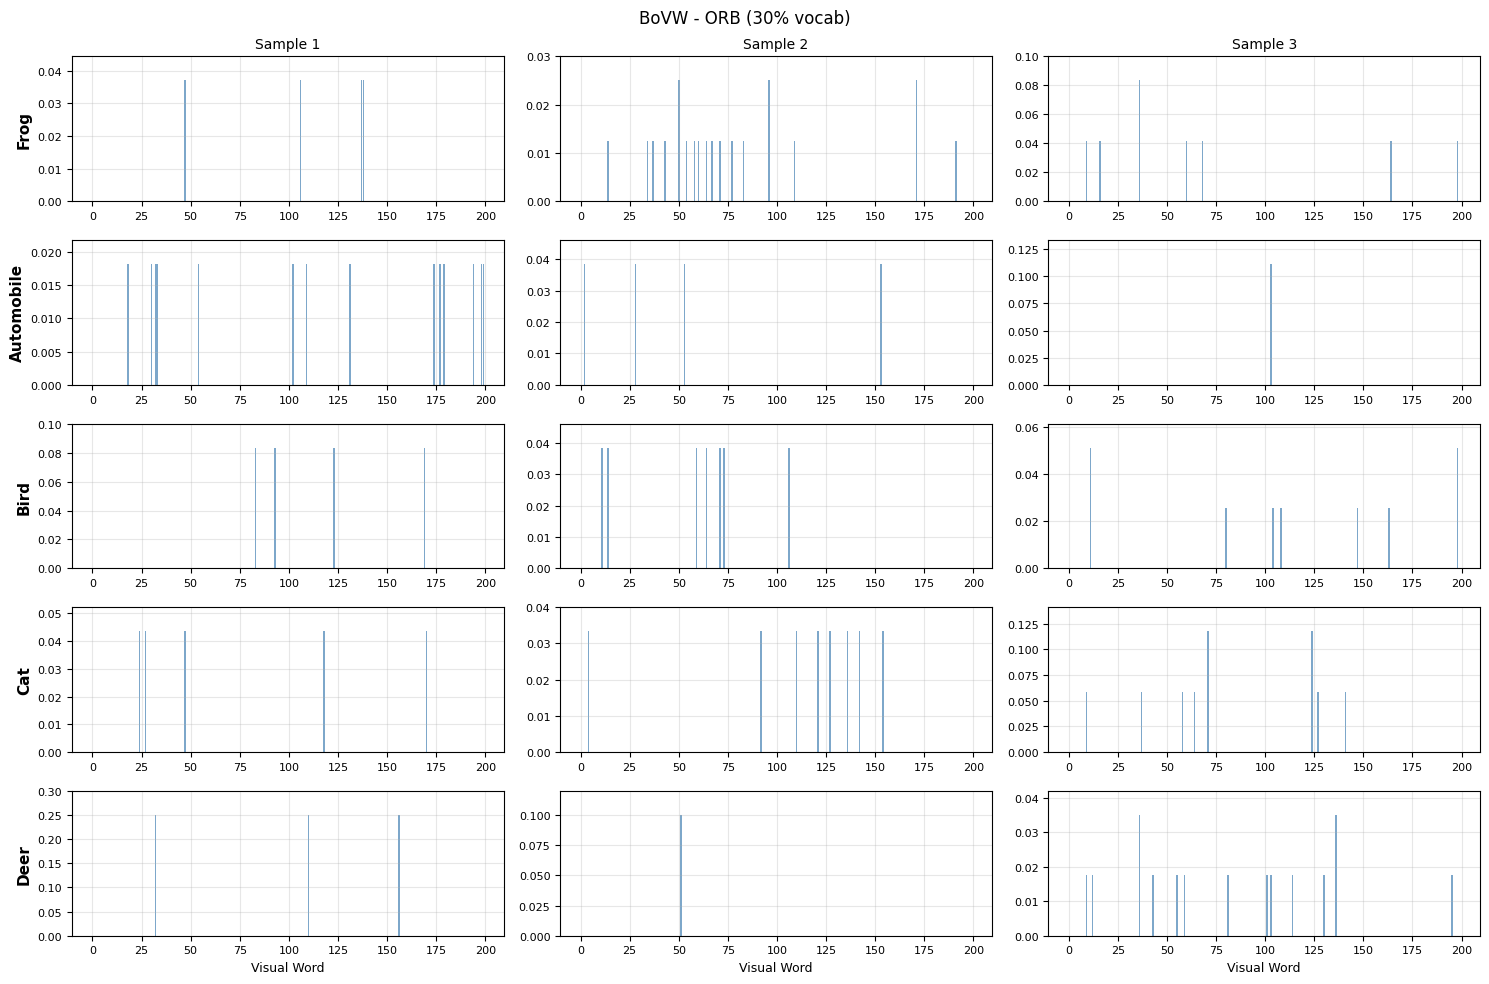


**********************************************************************
Processing 40% vocabulary

**********************************************************************
Encoding 5000 images using ORB...
Valid images: 4890/5000
Feature shape: (4890, 1000)


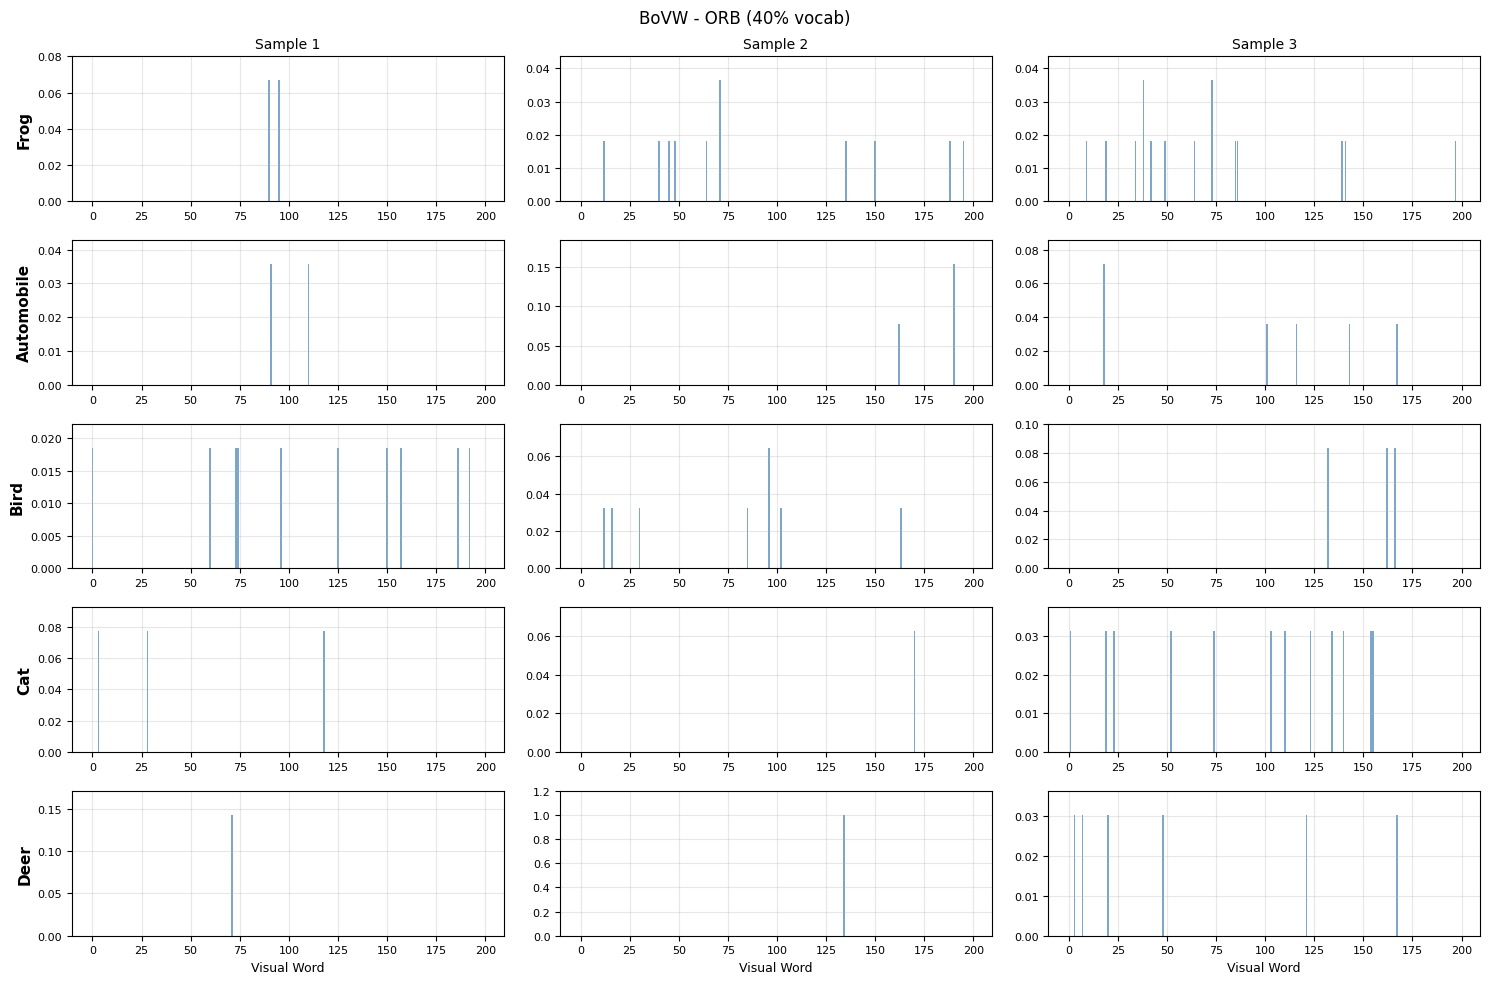


**********************************************************************
Processing 50% vocabulary

**********************************************************************
Encoding 5000 images using ORB...
Valid images: 4890/5000
Feature shape: (4890, 1000)


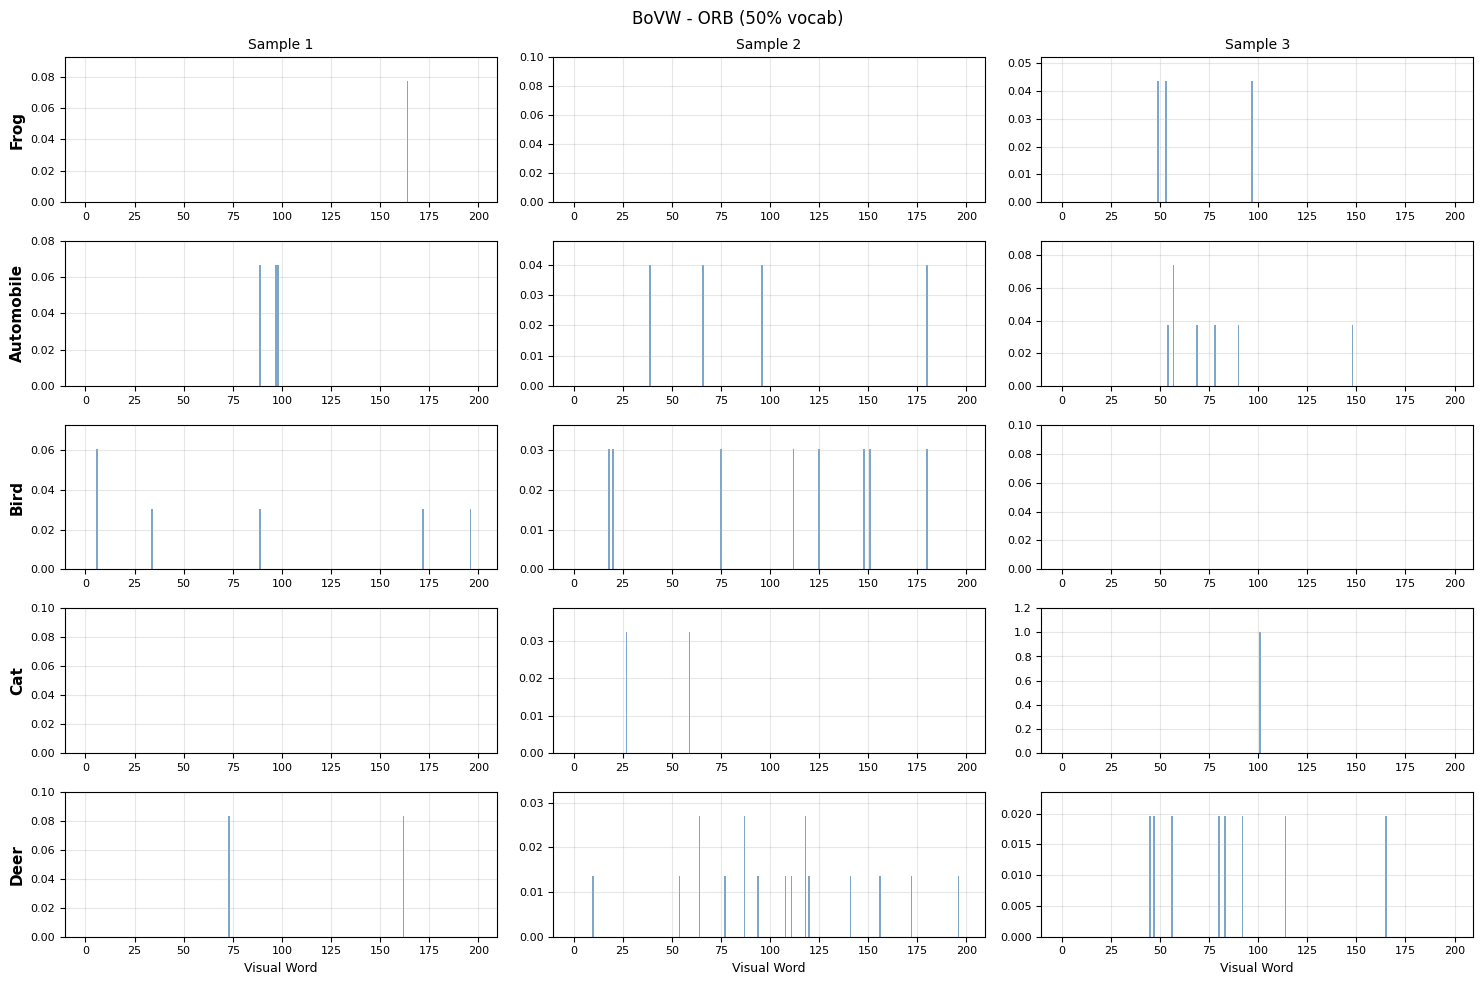

In [25]:
encoded_train_features = {
    'SIFT': {},
    'ORB': {}
}


for detector_name, detector in [('SIFT', sift), ('ORB', orb)]:
    print("\n" + "="*70)
    print(f"Encoding training images - {detector_name}")
    print("="*70)

    for percentage in data_percentages:
        print(f"\n{'*'*70}")
        print(f"Processing {int(percentage*100)}% vocabulary")
        print(f"\n{'*'*70}")

        if percentage not in vocabularies[detector_name]: continue

        # get vocabulary
        vocabulary = vocabularies[detector_name][percentage]

        # encode all training images
        bovw, valid_indices = encode_dataset_bovw(
            train_images,
            train_labels,
            detector,
            vocabulary,
            detector_name,
            upscale_factor
        )

        encoded_train_features[detector_name][percentage] = {
            'features': bovw,
            'labels': train_labels[valid_indices],
            'valid_indices': valid_indices
        }


        # visualize histograms
        visualize_bovw_histograms(
            bovw,
            train_labels[valid_indices],
            [label_to_class_name[i] for i in range(len(label_to_class_name))],
            f"{detector_name} ({int(percentage*100)}% vocab)",
            num_samples=3,
            n=200
        )

In [26]:
# Sparsity analysis
print("\n" + "="*70)
print("Sparsity Analysis of BoVW Histograms")
for detector_name in ['SIFT', 'ORB']:
    for percentage in data_percentages:
        if percentage in encoded_train_features[detector_name]:
            features = encoded_train_features[detector_name][percentage]['features']
            labels = encoded_train_features[detector_name][percentage]['labels']

            non_empty_count = (features.sum(axis=1) > 0).sum()
            total_count = len(features)

            print(f"\n{detector_name} {int(percentage*100)}%:")
            print(f"Non-empty histograms: {non_empty_count}/{total_count} ({non_empty_count/total_count*100:.1f}%)")


            for class_idx in range(num_classes):
                class_mask = labels == class_idx
                class_features = features[class_mask]
                non_empty_in_class = (class_features.sum(axis=1) > 0).sum()
                min_number_of_visual_words_for_class = np.min((class_features > 0).sum(axis=1))

                print(f"{class_names[class_idx]}: {non_empty_in_class}/{class_mask.sum()} non-empty, min number of visual words: {min_number_of_visual_words_for_class}")



Sparsity Analysis of BoVW Histograms

SIFT 30%:
Non-empty histograms: 4998/4998 (100.0%)
Frog: 1000/1000 non-empty, min number of visual words: 8
Automobile: 1000/1000 non-empty, min number of visual words: 15
Bird: 1000/1000 non-empty, min number of visual words: 6
Cat: 1000/1000 non-empty, min number of visual words: 4
Deer: 998/998 non-empty, min number of visual words: 1

SIFT 40%:
Non-empty histograms: 4998/4998 (100.0%)
Frog: 1000/1000 non-empty, min number of visual words: 8
Automobile: 1000/1000 non-empty, min number of visual words: 15
Bird: 1000/1000 non-empty, min number of visual words: 5
Cat: 1000/1000 non-empty, min number of visual words: 4
Deer: 998/998 non-empty, min number of visual words: 1

SIFT 50%:
Non-empty histograms: 4998/4998 (100.0%)
Frog: 1000/1000 non-empty, min number of visual words: 8
Automobile: 1000/1000 non-empty, min number of visual words: 14
Bird: 1000/1000 non-empty, min number of visual words: 5
Cat: 1000/1000 non-empty, min number of visual wor

<a id="section-5"></a>
### **Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)**

In this section, the task is to visualize the Bag of Visual Words for each class using the histograms generated in the previous step. The goal is to plot the mean histogram of visual words for each class, showing the distribution of visual words across the different categories in the training set.

Use the two different extraction techniques you implemented for this visualization. For each technique, calculate the mean histogram for each class and create a bar plot to display these histograms. Ensure that the plots are labeled clearly with the class names and feature descriptor types.


SIFT


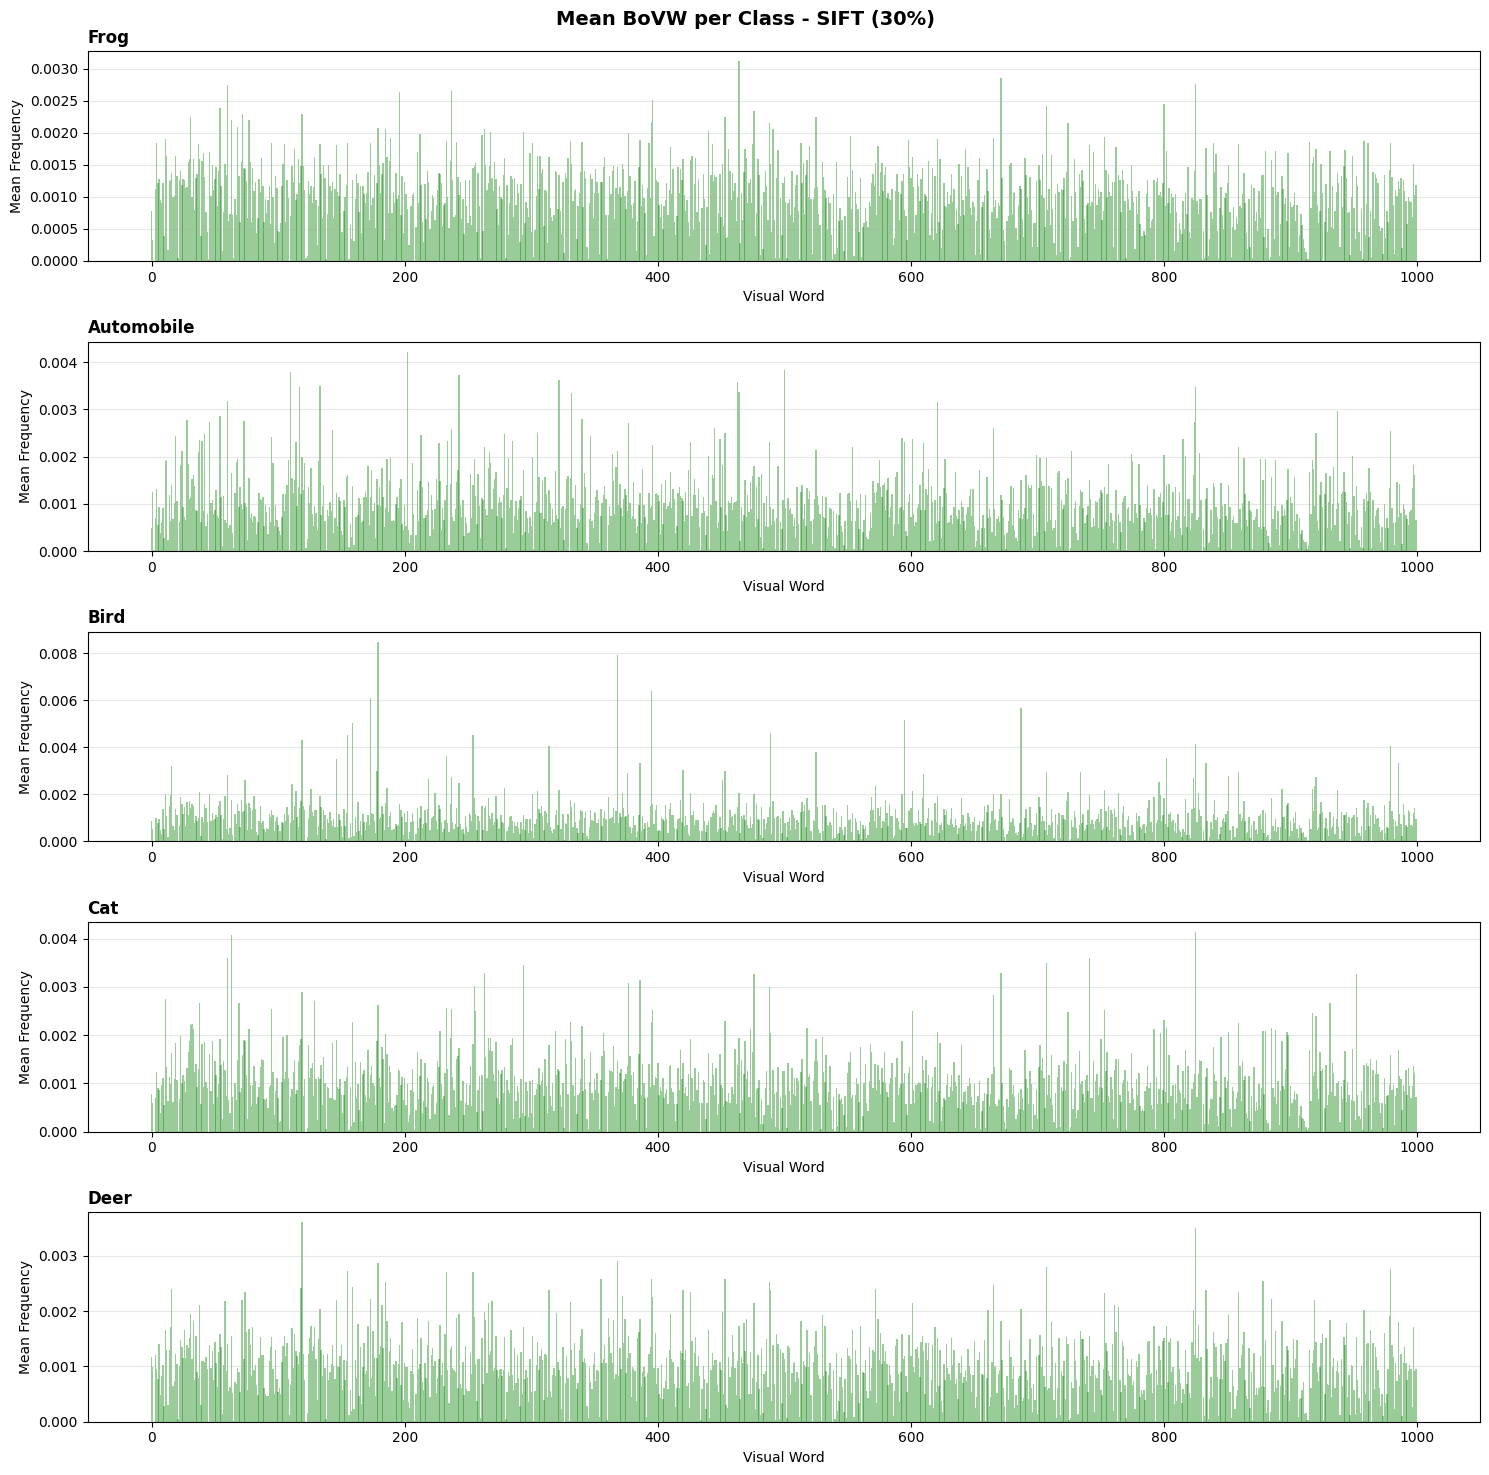

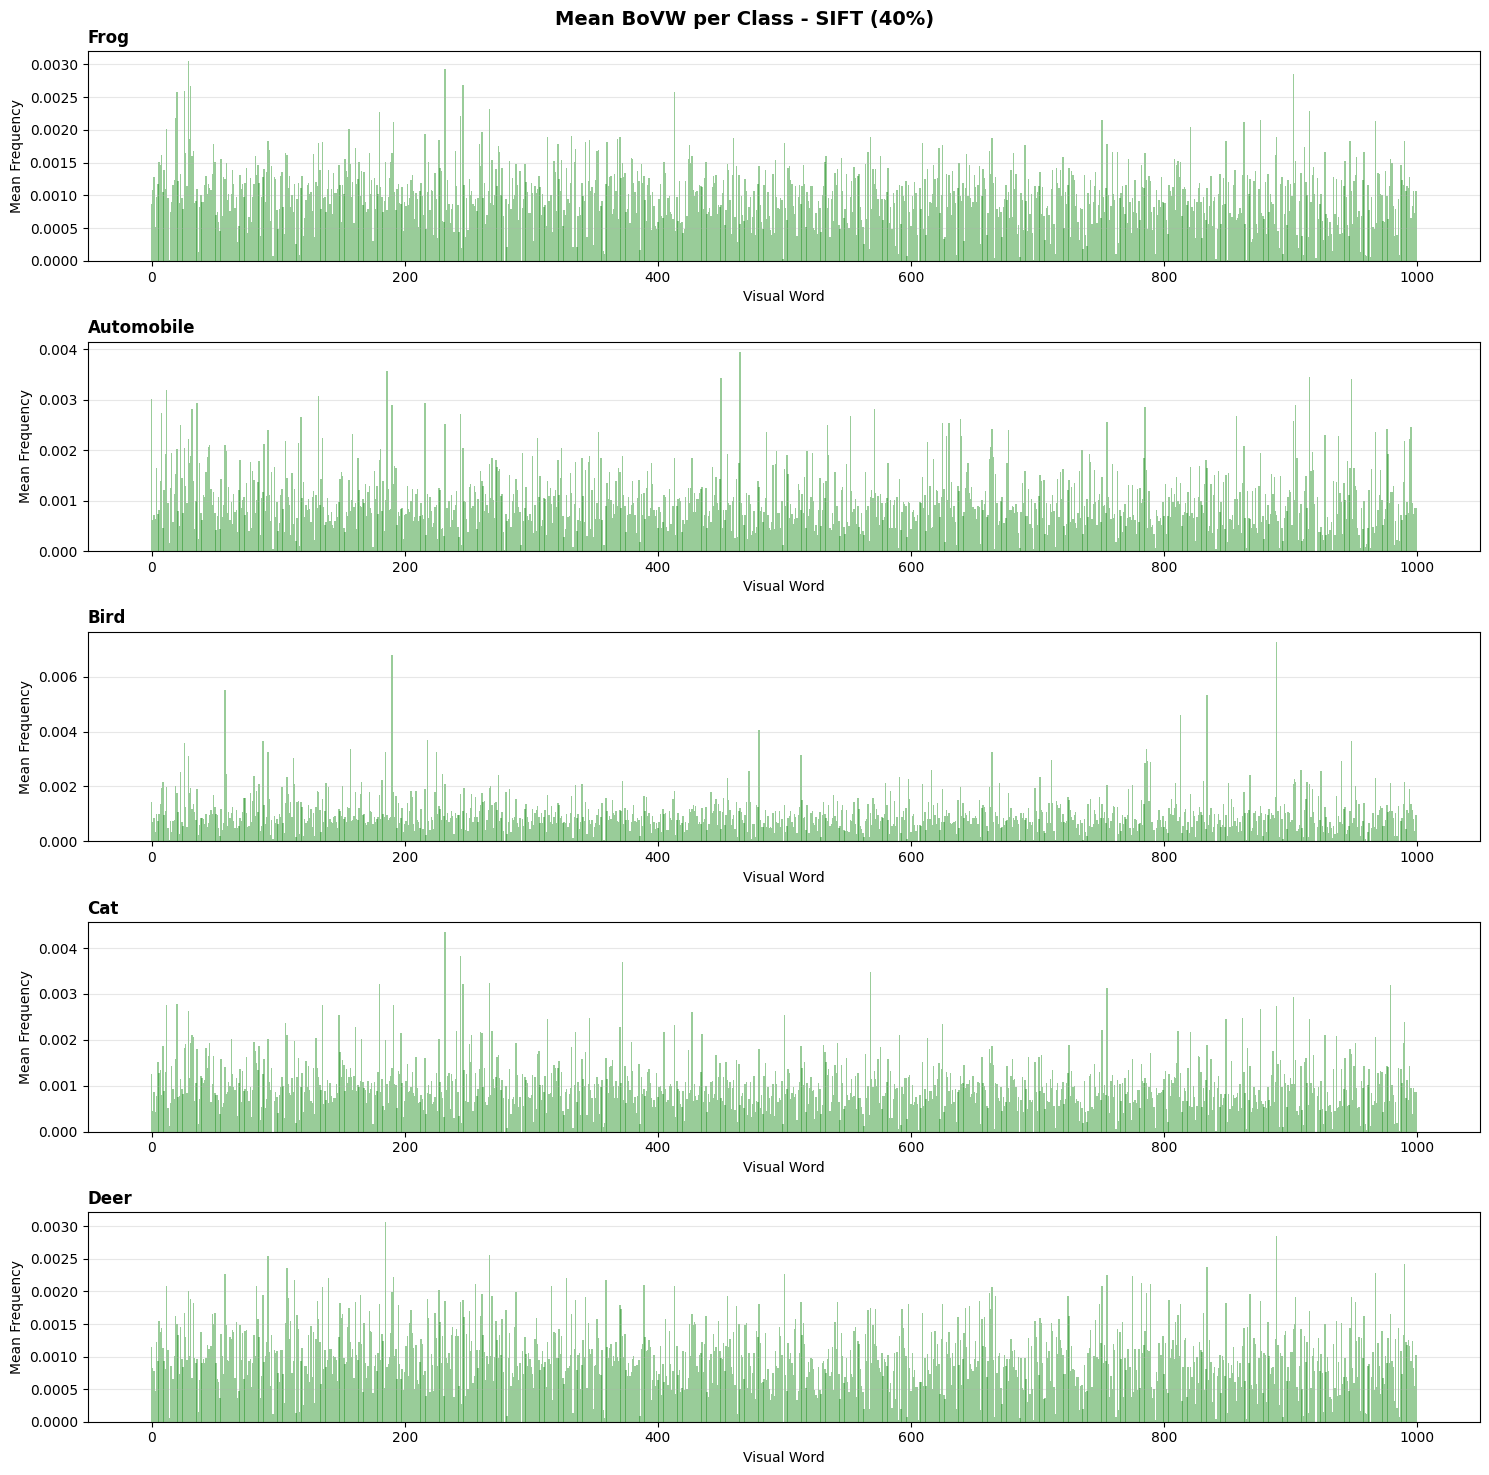

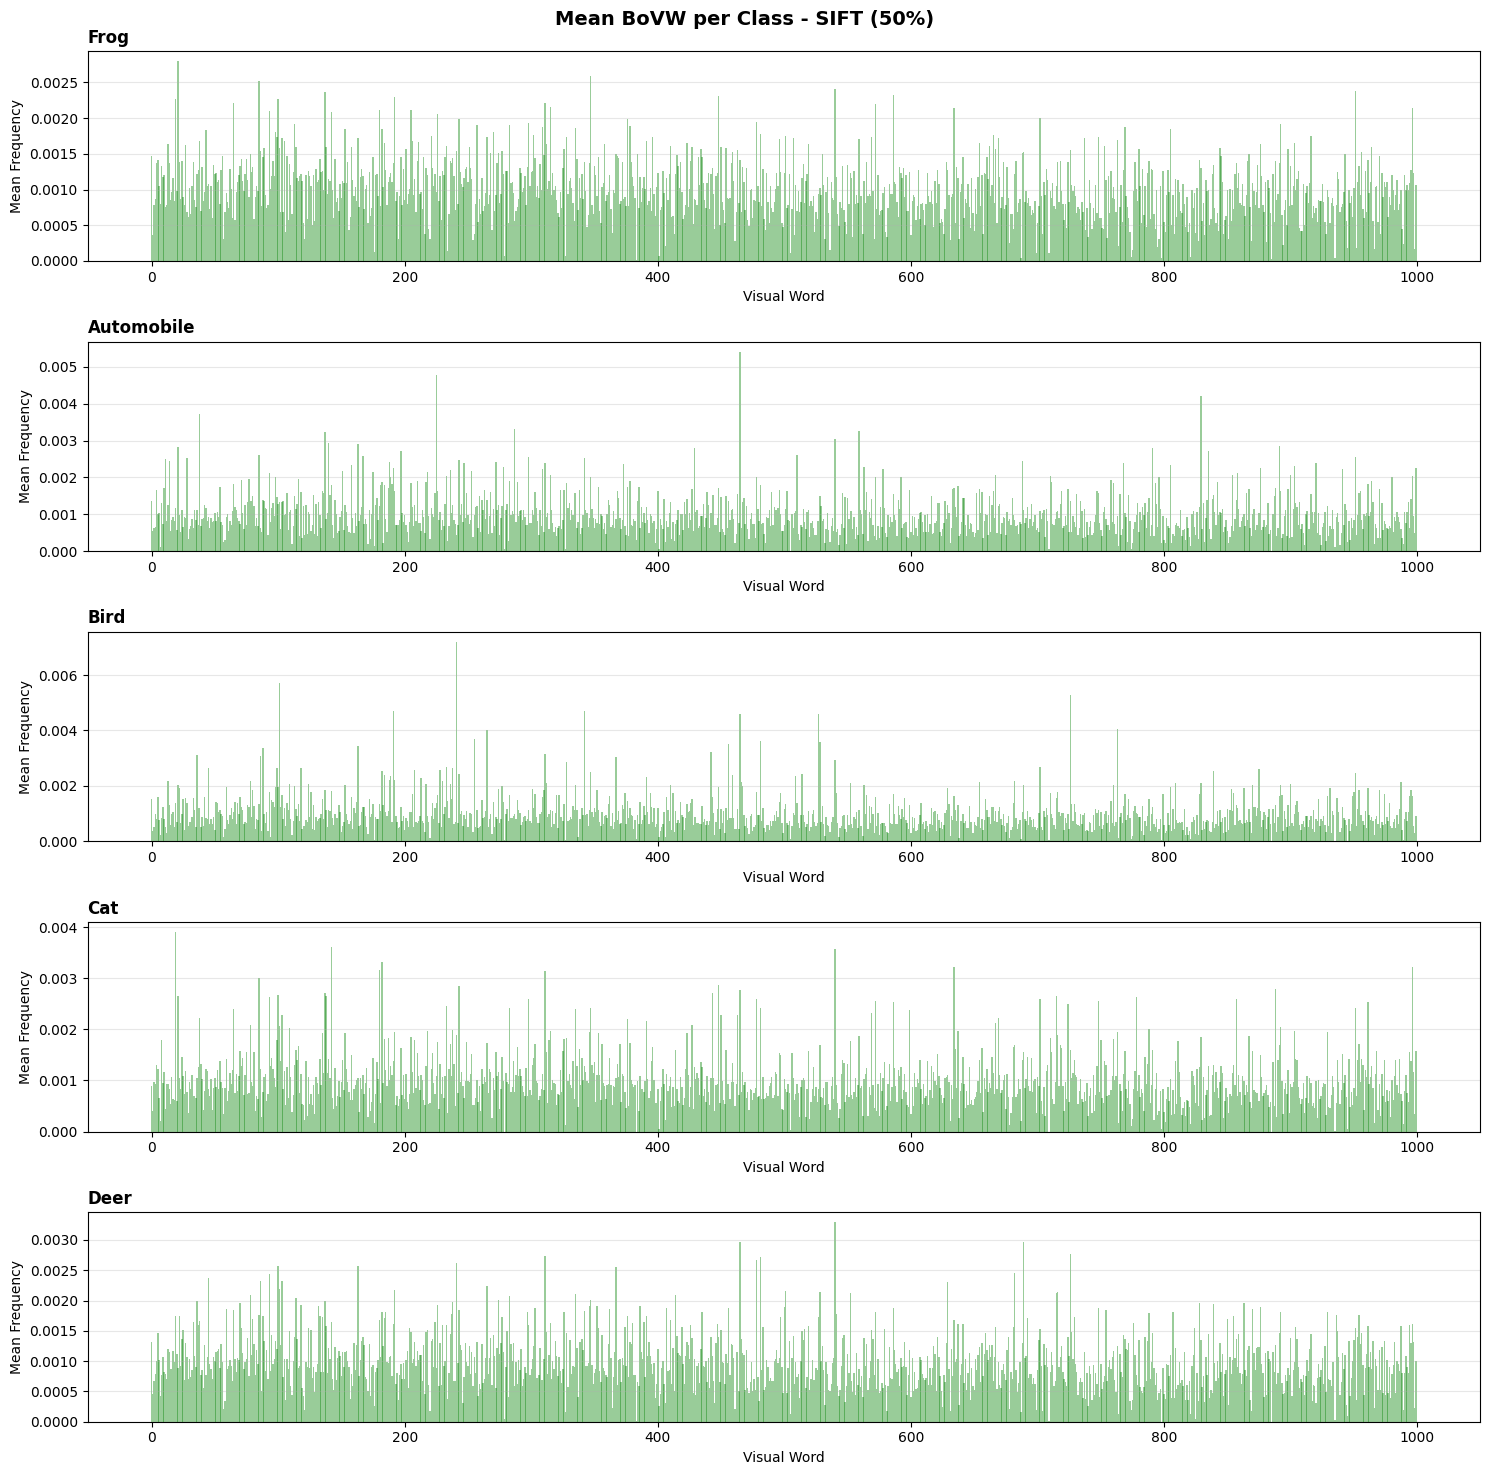


ORB


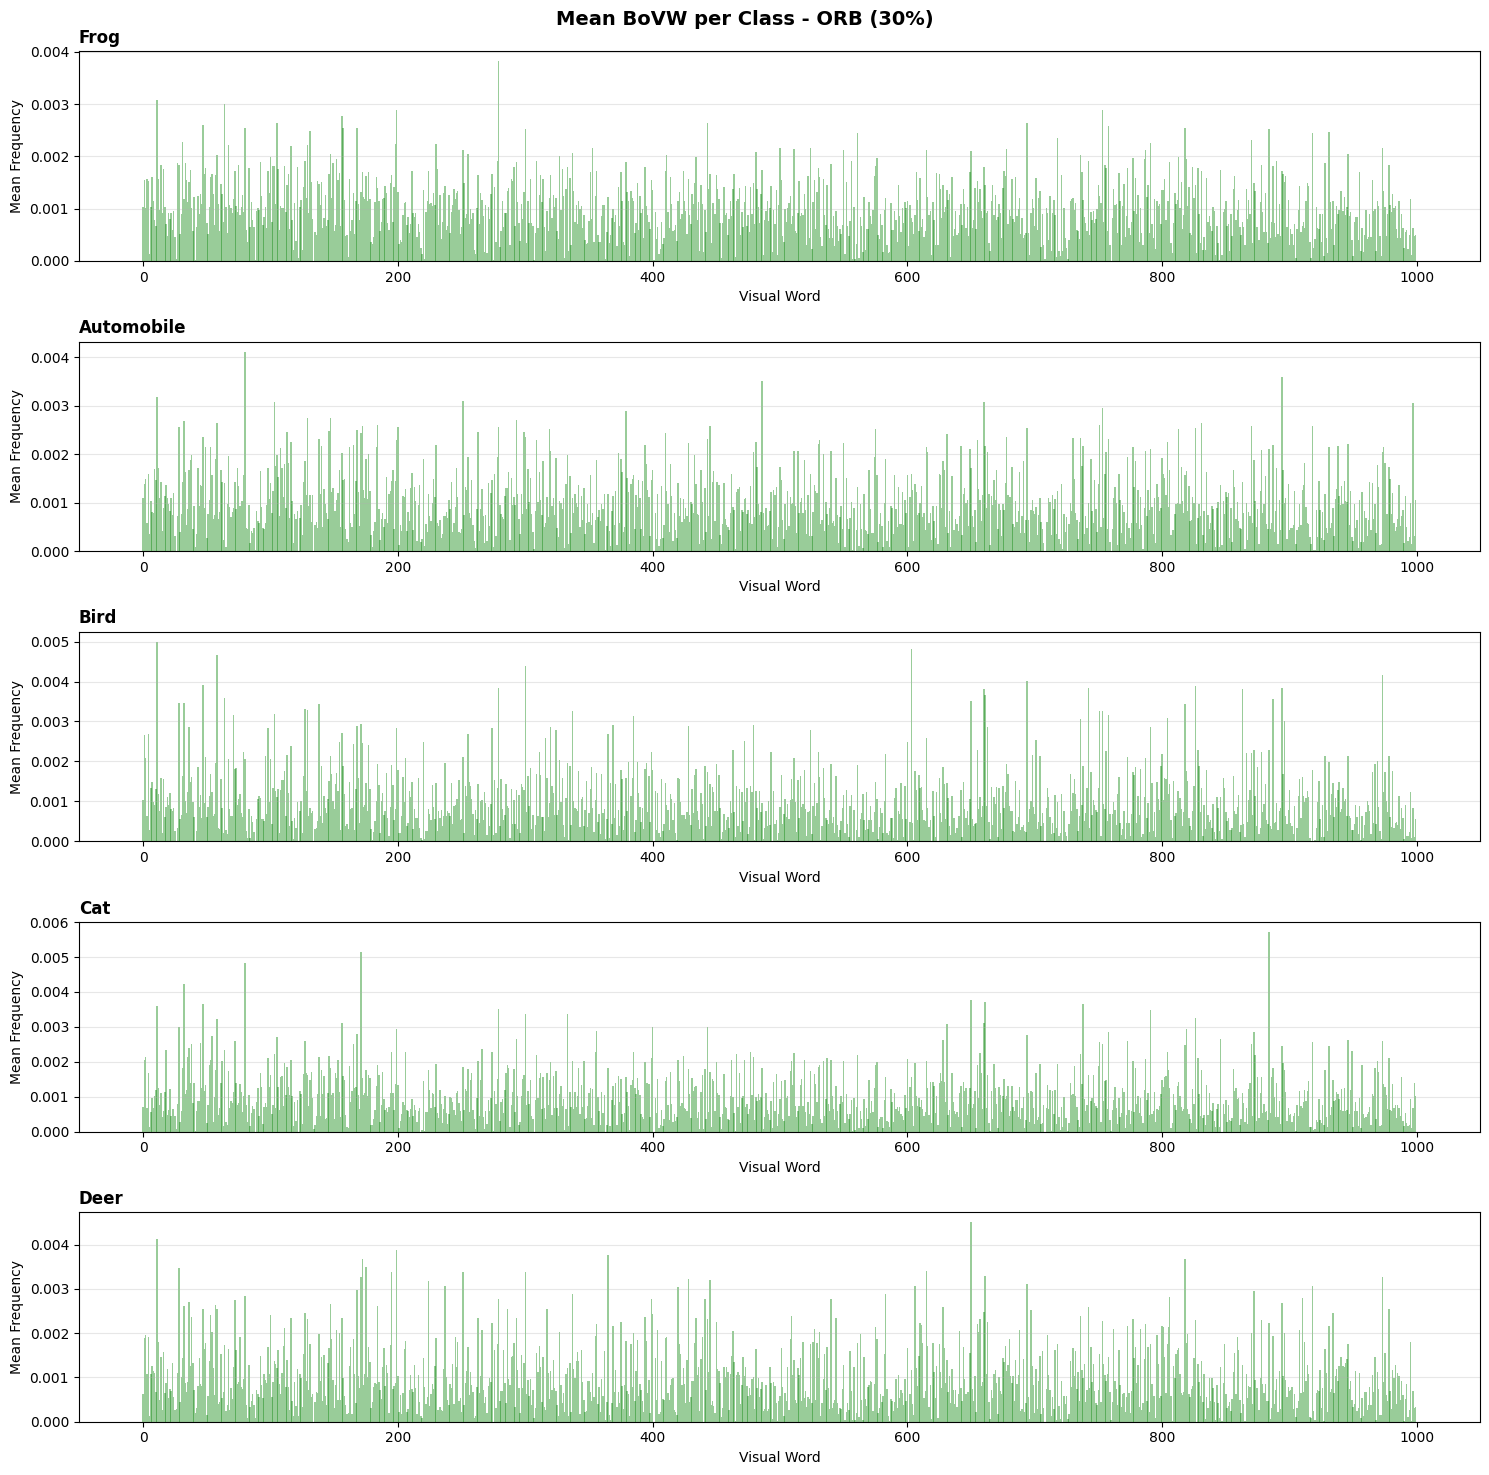

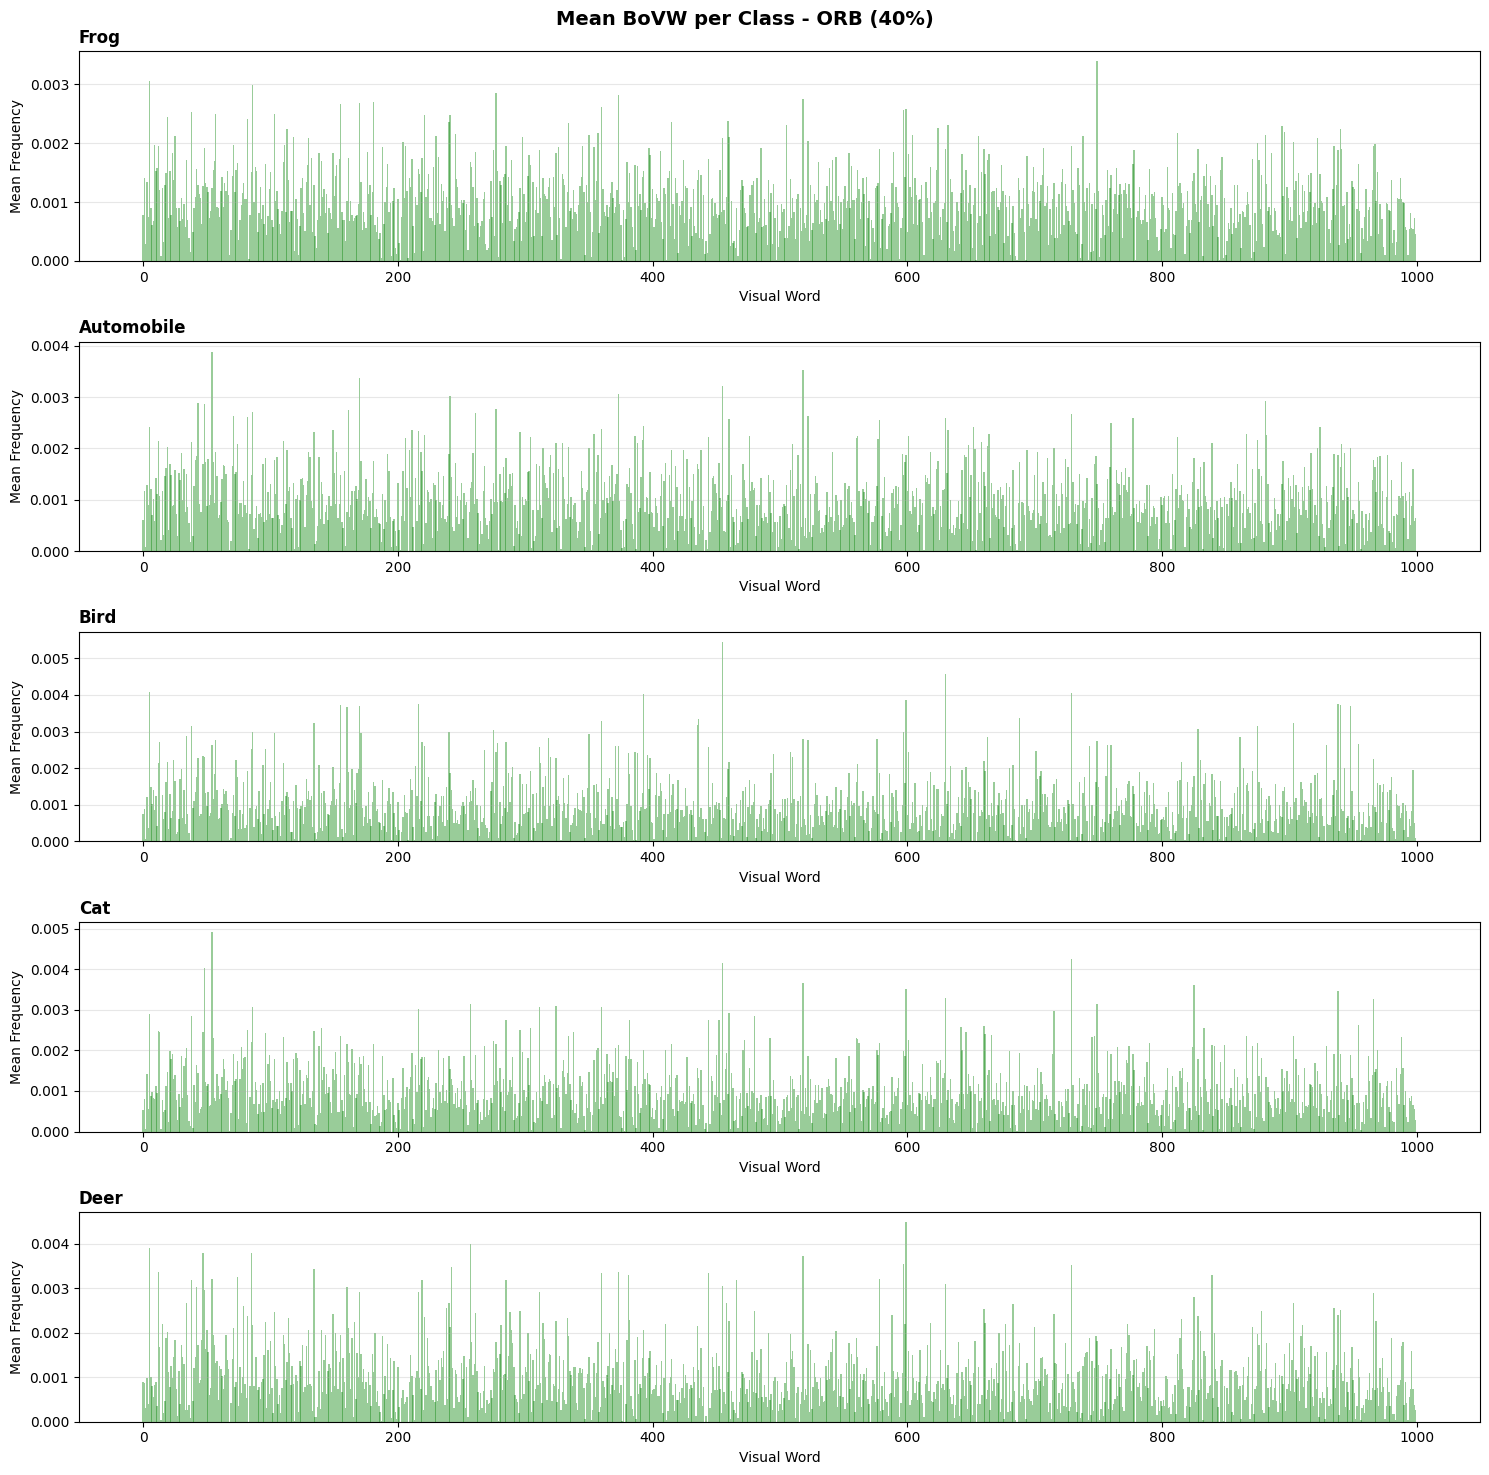

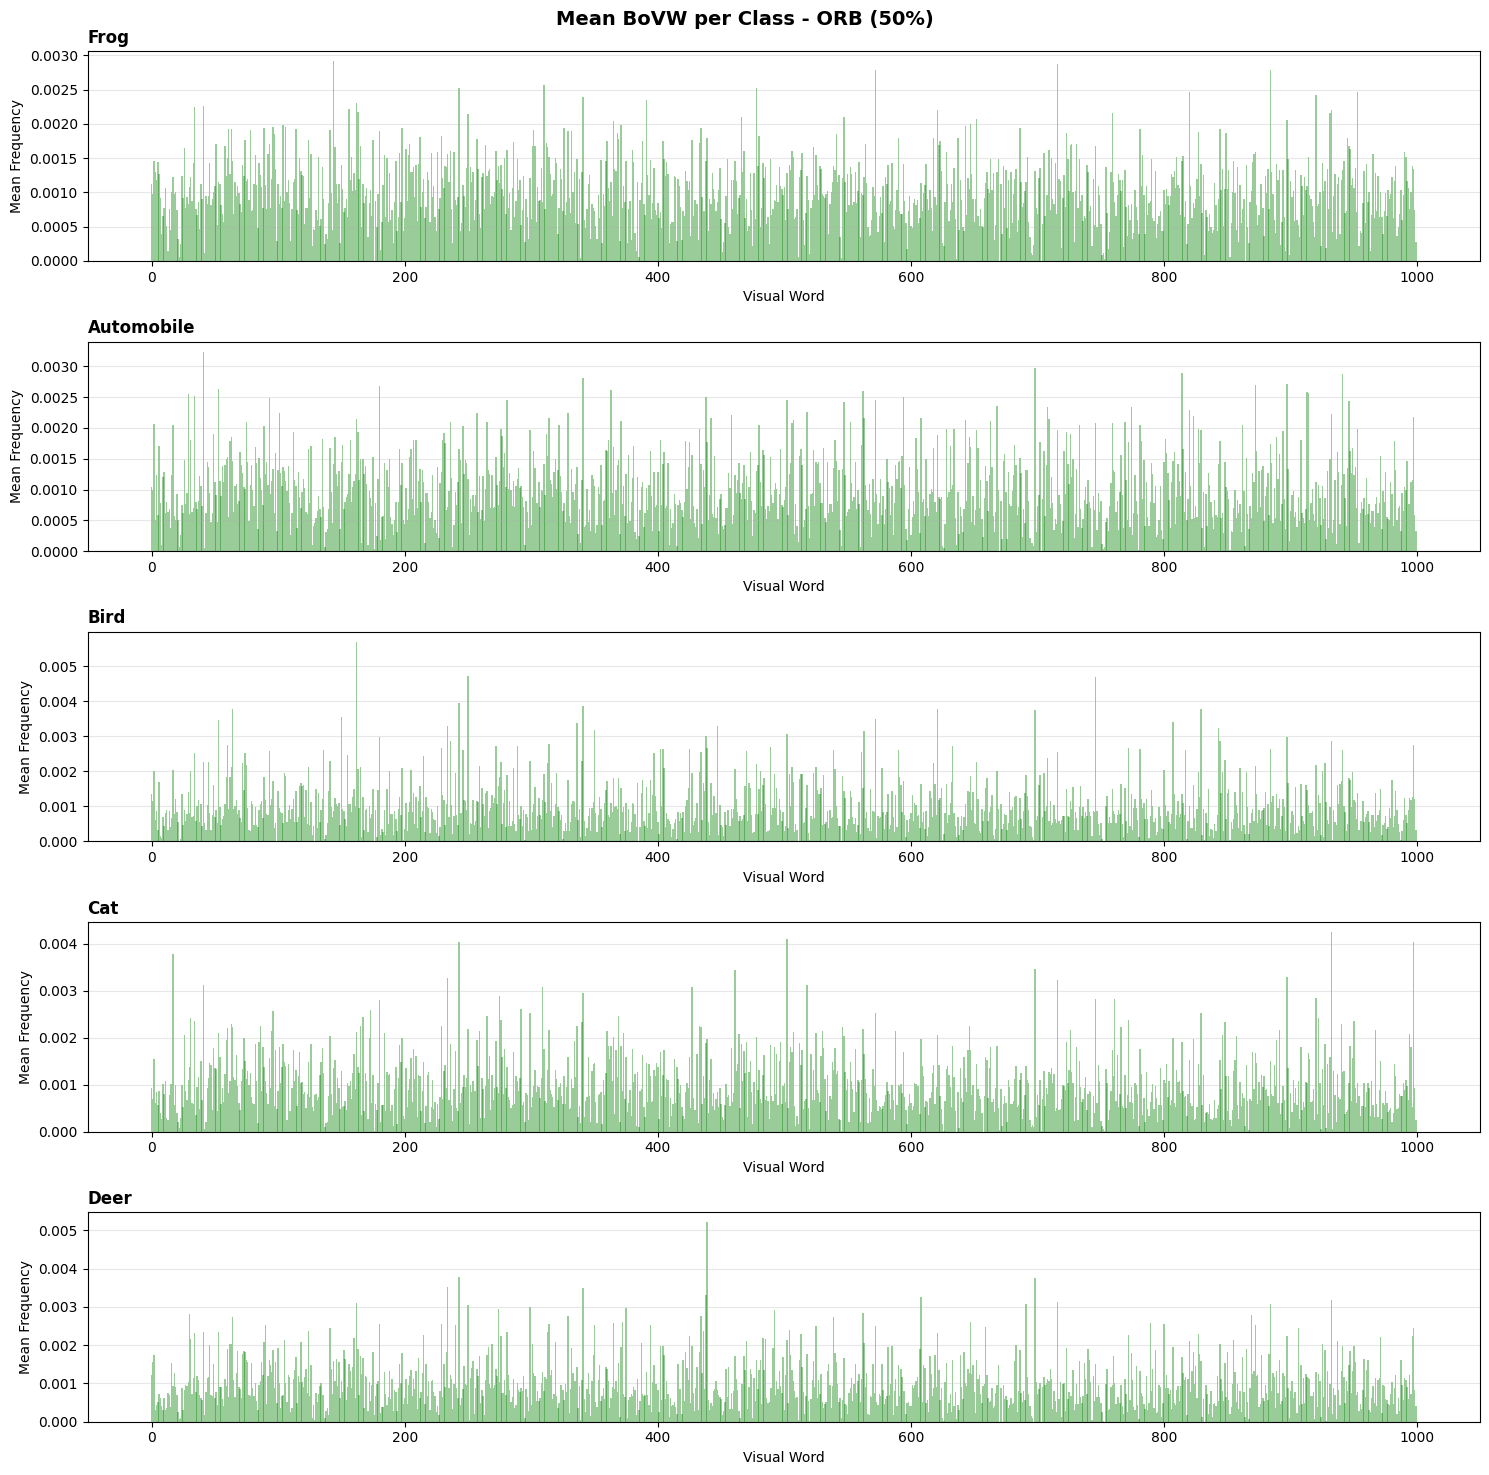

In [27]:
def visualize_mean_bovw_per_class(features, labels, class_names, detector_name, percentage):
    """
    Visualize mean BoVW histogram for each class

    Args:
        features: feature vectors (num_images, num_visual_words)
        labels: image labels
        class_names: list of class names
        detector_name: name of detector
        percentage: percentage of training data used
    """

    num_classes = len(class_names)
    num_visual_words = features.shape[1]


    mean_histograms = [] # one per class

    for class_idx in range(num_classes):
        class_mask = labels == class_idx
        mean_histograms.append(features[class_mask].mean(axis=0))

    mean_histograms = np.array(mean_histograms) # (num_classes, num_visual_words)


    fig, axes = plt.subplots(num_classes, 1, figsize=(15, 3*num_classes))
    if num_classes == 1: axes = [axes]

    fig.suptitle(f'Mean BoVW per Class - {detector_name} ({int(percentage*100)}%)', fontsize=14, fontweight='bold')

    for class_idx in range(num_classes):
        ax = axes[class_idx]

        ax.bar(range(num_visual_words), mean_histograms[class_idx], color="green", alpha=0.4, width=1.1)

        ax.set_ylabel('Mean Frequency')
        ax.set_title(f'{class_names[class_idx]}', fontweight='bold', loc='left')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xlabel('Visual Word')

    plt.tight_layout()
    plt.show()



for detector_name in ['SIFT', 'ORB']:
    print(f"\n{'='*70}")
    print(f"{detector_name}")
    print(f"{'='*70}")

    for percentage in data_percentages:
        if percentage in encoded_train_features[detector_name]:
            visualize_mean_bovw_per_class(
                features = encoded_train_features[detector_name][percentage]['features'],
                labels = encoded_train_features[detector_name][percentage]['labels'],
                class_names = class_names,
                detector_name = detector_name,
                percentage = percentage
            )

<a id="section-6"></a>
### **Section 6: Encoding Test Image Features (0 points)**

In this section, the task is to encode the test image features using the visual vocabulary created from the training set. Similar to the previous encoding step, each test image will be represented as a histogram of visual words, which will then be used for evaluating classification performance.

Use the same two feature extraction techniques you selected earlier. Extract keypoints and descriptors for the test images, then encode these images using the visual vocabulary. This will allow you to compare the encoded features of test images against those of the training set.

**Hint:** Reuse the functions developed earlier for extracting keypoints, descriptors, and encoding images. Ensure that you use the visual vocabulary constructed with the training images for consistency.

In [28]:
encoded_test_features = {
    'SIFT': {},
    'ORB': {}
}

for detector_name, detector in [('SIFT', sift), ('ORB', orb)]:
    print("\n" + "="*70)
    print(f"Encoding test images - {detector_name}")
    print("="*70)

    for percentage in data_percentages:

        vocabulary = vocabularies[detector_name][percentage]

        # encode all test images
        bovw, valid_indices = encode_dataset_bovw(
            test_images,
            test_labels,
            detector,
            vocabulary,
            detector_name,
            upscale_factor
        )

        encoded_test_features[detector_name][percentage] = {
            'features': bovw,
            'labels': test_labels[valid_indices],
            'valid_indices': valid_indices
        }


Encoding test images - SIFT
Encoding 1000 images using SIFT...
Valid images: 1000/1000
Feature shape: (1000, 1000)
Encoding 1000 images using SIFT...
Valid images: 1000/1000
Feature shape: (1000, 1000)
Encoding 1000 images using SIFT...
Valid images: 1000/1000
Feature shape: (1000, 1000)

Encoding test images - ORB
Encoding 1000 images using ORB...
Valid images: 976/1000
Feature shape: (976, 1000)
Encoding 1000 images using ORB...
Valid images: 976/1000
Feature shape: (976, 1000)
Encoding 1000 images using ORB...
Valid images: 976/1000
Feature shape: (976, 1000)


<a id="section-7"></a>
### **Section 7: Training the Classifiers (5 points)**

In this section, the task is to create two one-vs-rest (OvR) SVM classifiers using the 50% of the training data that was **not** used for creating the visual dictionary. This ensures that the classifiers are trained on a different subset of data, providing a more robust evaluation of the visual vocabulary's effectiveness.

For each of the two selected feature extraction techniques, create one-vs-rest classifiers for all classes. For now, use default parameter values when training the classifiers; you will experiment with different hyperparameters in later steps.

**Note:** Training an OvR classifier can take around 5 to 7 minutes. Therefore, it's advisable to first test your code with a smaller subset of the training data to verify that your implementation works correctly before running it on the full dataset.

In [29]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# classifiers
classifiers = {
    'SIFT': OneVsRestClassifier(SVC(kernel='linear')),
    'ORB': OneVsRestClassifier(SVC(kernel='linear'))
}

for detector_name, clf in classifiers.items():
    print(f"Training {detector_name} classifier...")

    train_x = encoded_train_features[detector_name][0.5]['features']
    train_y = encoded_train_features[detector_name][0.5]['labels']

    # we have to discard the first 50% of training data as we did use it for building the vocabulary
    train_x = train_x[ (len(train_x) // 2) : ]
    train_y = train_y[ (len(train_y) // 2) : ]

    print(f"Training data shape: {train_x.shape}, Training labels shape: {train_y.shape}")

    print("Fitting classifier...")

    clf.fit(train_x, train_y)

    print(f"{detector_name} training complete!")

    y_train_pred = clf.predict(train_x)
    train_acc = (y_train_pred == np.array(train_y)).mean()
    print(f"Training accuracy: {train_acc*100:.2f}%")

Training SIFT classifier...
Training data shape: (2499, 1000), Training labels shape: torch.Size([2499])
Fitting classifier...
SIFT training complete!
Training accuracy: 72.43%
Training ORB classifier...
Training data shape: (2445, 1000), Training labels shape: torch.Size([2445])
Fitting classifier...
ORB training complete!
Training accuracy: 66.05%


<a id="section-8"></a>
### **Section 8: Evaluating the Classifiers (12 points)**

In this section, you will evaluate the performance of your one-vs-rest (OvR) SVM classifiers on the test data. The goal is to classify each test image using each binary classifier and rank the images based on the classification scores, resulting in a ranked list of images for each class. Ideally, images belonging to the target class should appear at the top of the respective list. To conduct this evaluation, use the test image histograms generated earlier for the two selected feature extraction techniques. Classify each test image with each classifier, rank them based on their confidence scores, and then compute the Mean Average Precision (mAP) across all classes. The mAP for a single class $c$ is defined as:

$
\text{mAP}_c = \frac{1}{m_c} \sum_{i=1}^{n} \frac{f_c(x_i)}{i}
$

where:
- $n$ is the total number of images ($n = 50 \times 5 = 250$),
- $m_c$ is the number of images of class $c$ ($m_c = 50$),
- $x_i$ is the $i^{th}$ image in the ranked list $X = \{ x_1, x_2, \dots, x_n \}$,
- $f_c$ is a function that returns the number of images of class $c$ in the first $i$ images if $x_i$ is of class $c$, and 0 otherwise.

For instance, if you are retrieving images of class "R" and the sequence of ranked images is $[R, R, T, R, T, T, R, T]$, then $n = 8$, $m_c = 4$, and:

$
AP = \frac{1}{4} \left( \frac{1}{1} + \frac{2}{2} + \frac{0}{3} + \frac{3}{4} + \frac{0}{5} + \frac{0}{6} + \frac{4}{7} + \frac{0}{8} \right).
$

In addition to the quantitative analysis, perform a qualitative analysis by visualizing the top-5 and bottom-5 ranked test images.

In [30]:
def calc_AP(ground_truth, scores, target_class):
    """
    Compute Average Precision for a single class

    Args:
        ground_truth: true labels
        scores: confidence scores for target_class
        target_class: index of the class to compute AP for

    Returns:
        ap: Average Precision for this class
    """
    # sort images by confidence
    sorted_indices = np.argsort(scores)  # get sorted indices
    sorted_indices = sorted_indices[::-1].copy()  # descending order
    sorted_labels = ground_truth[sorted_indices]  # sort labels by indices

    # number of images of target class
    m_c = np.sum(ground_truth == target_class)
    if m_c == 0: return 0.0


    ap = 0.0
    num_correct = 0

    for i, label in enumerate(sorted_labels, start=1):
        if label == target_class:
            num_correct += 1
            ap += num_correct / i

    ap *= 1 / m_c

    return ap



def calc_mAP(ground_truth, scores, num_classes):
    """
    Compute mean Average Precision over all classes

    Args:
        ground_truth: true labels
        scores: confidence scores for each class (num_images, num_classes)
        num_classes: number of classes

    Returns:
        mAP: mean Average Precision
        APs: list of AP for each class
    """
    APs = []

    for class_idx in range(num_classes):
        ap = calc_AP(ground_truth, scores[:, class_idx], class_idx)
        APs.append(ap)

    mAP = np.mean(APs)

    return mAP, APs

In [31]:
def visualize_top_bottom_ranked_images(n, decision_scores, ground_truth, detector_name):
    """
    Visualize top-n and bottom-n ranked images for each class
    Args:
        n: number of top and bottom images to show
        ground_truth: true labels
        decision_scores: confidence scores for each class
        detector_name: name of the detector
    """

    # get test images
    valid_test_images = test_images[encoded_test_features[detector_name][0.5]['valid_indices']]

    for class_idx in range(num_classes):

        # sort images by confidence
        class_scores = decision_scores[:, class_idx]  # get scores for this class
        sorted_indices = np.argsort(class_scores)  # get sorted indices
        sorted_indices = sorted_indices[::-1].copy()  # descending order

        fig, axes = plt.subplots(2, n, figsize=(15, 6))

        fig.suptitle(f'{class_names[class_idx]} - {detector_name}\nTop {n} and bottom {n} (right) ranked images', fontweight='bold')

        # top-n images
        for i in range(n):
            index = sorted_indices[i]

            img = denormalize_image(valid_test_images[index])
            true_label = ground_truth[index]

            axes[0, i].imshow(img)
            axes[0, i].axis('off')


            color = 'green' if true_label == class_idx else 'red'
            axes[0, i].set_title(f'Rank {i+1}\n{class_names[true_label]}', color=color, fontweight='bold')

        # last n images
        for i in range(n):
            index = sorted_indices[-(n-i)]
            img = denormalize_image(valid_test_images[index])
            true_label = ground_truth[index]

            axes[1, i].imshow(img)
            axes[1, i].axis('off')

            color = 'green' if true_label == class_idx else 'red'
            axes[1, i].set_title(f'Rank {len(sorted_indices)-(n-i-1)}\n{class_names[true_label]}', color=color, fontweight='bold')


        axes[0, 0].text(-0.3, 0.5, f"top {n}", transform=axes[0, 0].transAxes, verticalalignment='center')
        axes[1, 0].text(-0.3, 0.5, f"bottom {n}", transform=axes[1, 0].transAxes, verticalalignment='center')

        plt.tight_layout()
        plt.show()



Evaluating SIFT Classifier
test set: 1000 images
decision scores shape: (1000, 5)

SIFT mAP: 40.17%
Class 0 AP: 26.73%
Class 1 AP: 62.09%
Class 2 AP: 49.11%
Class 3 AP: 32.02%
Class 4 AP: 30.90%


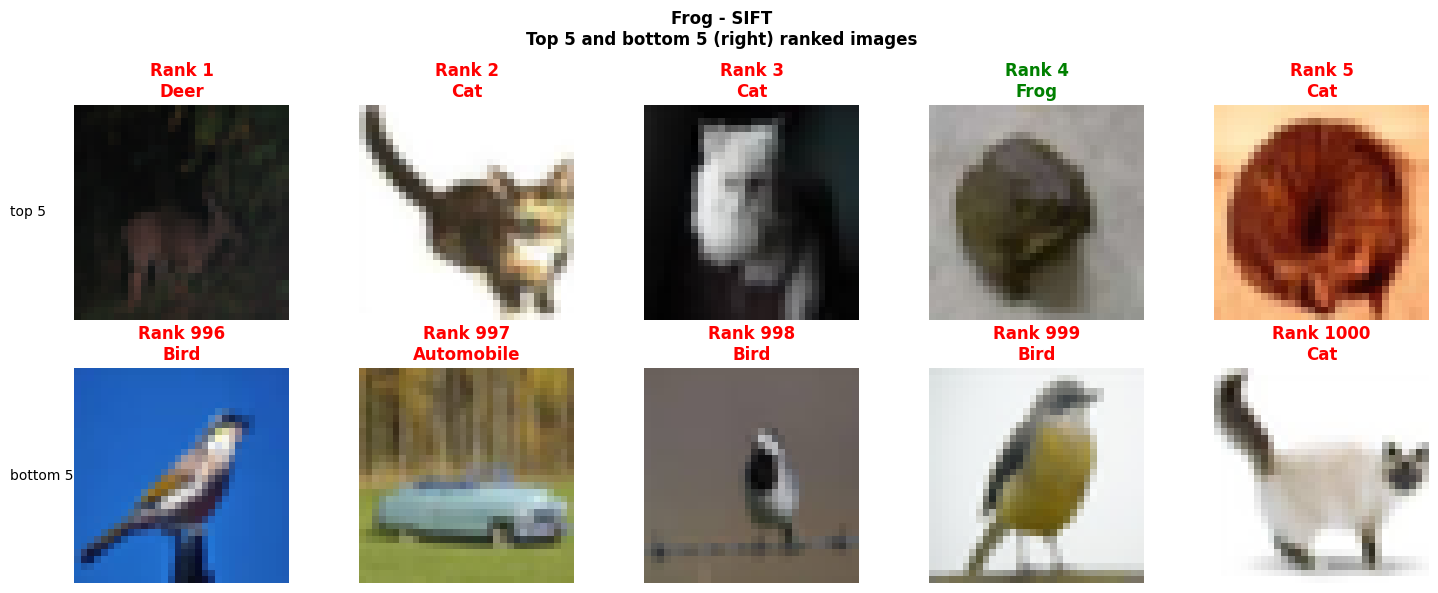

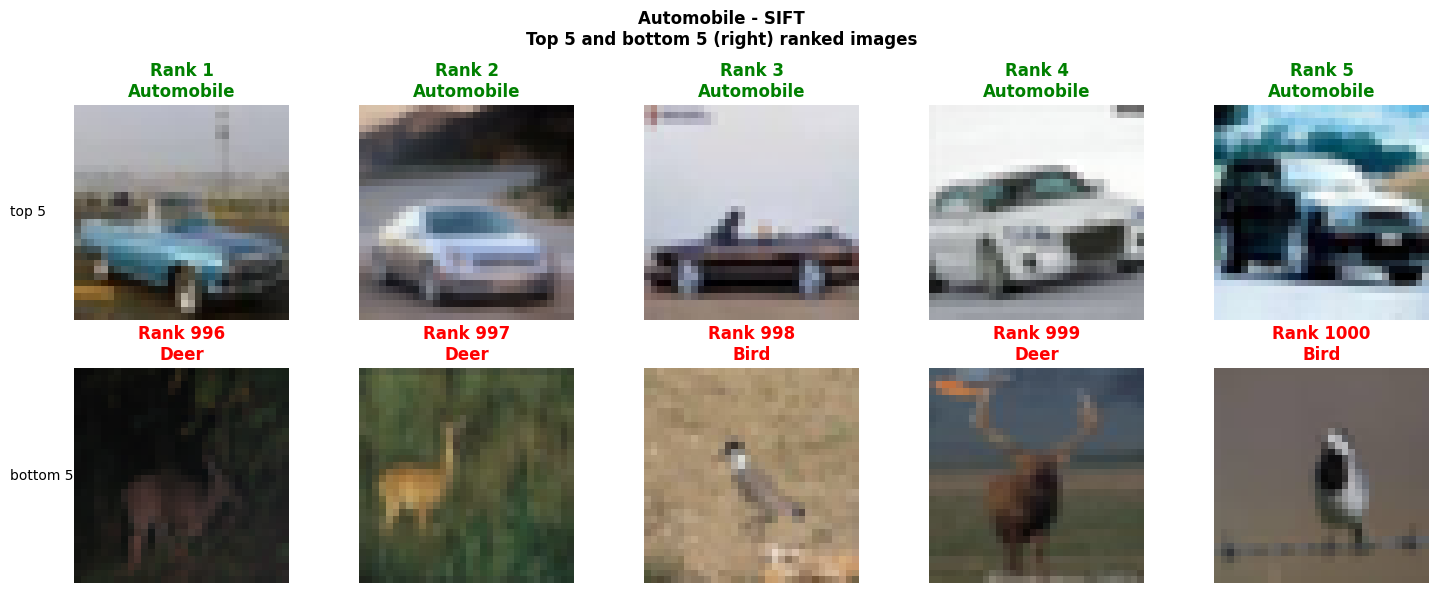

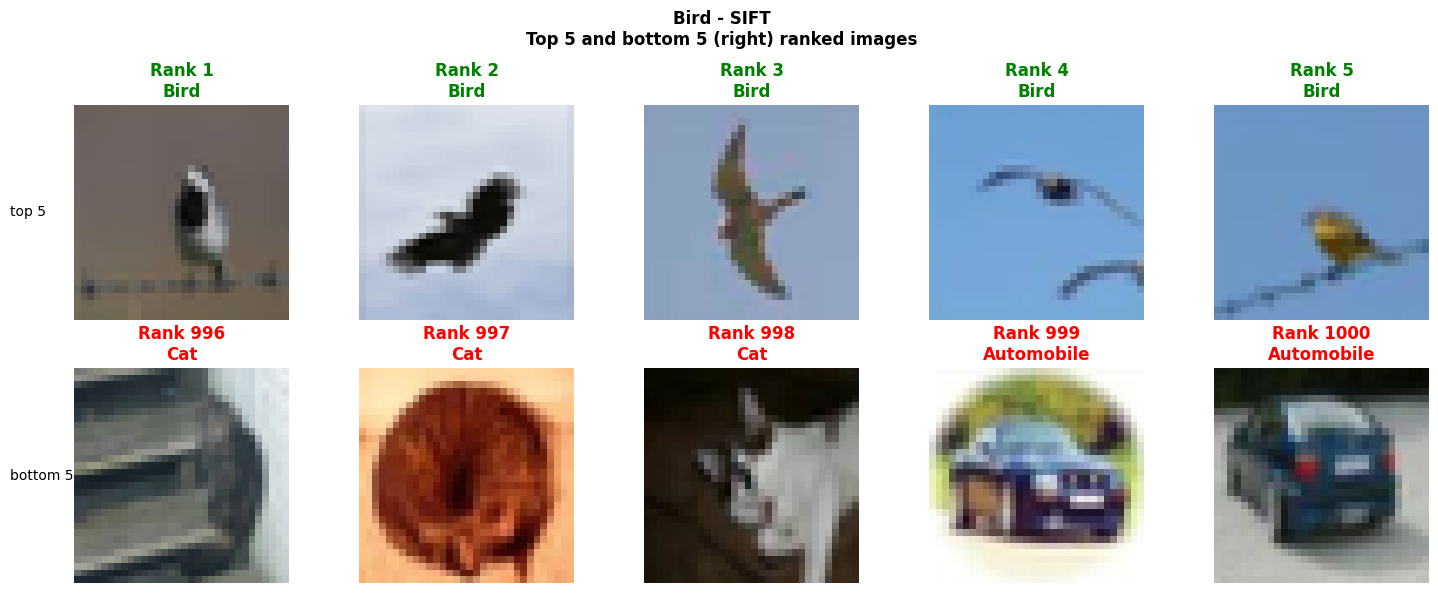

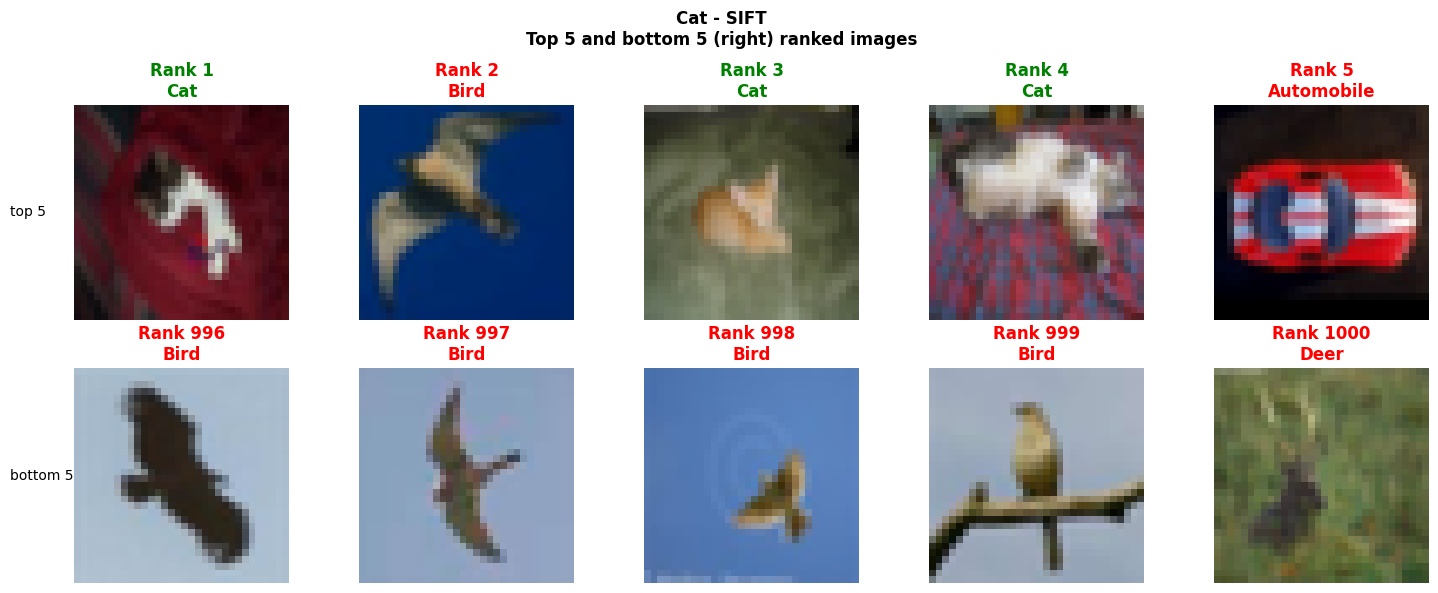

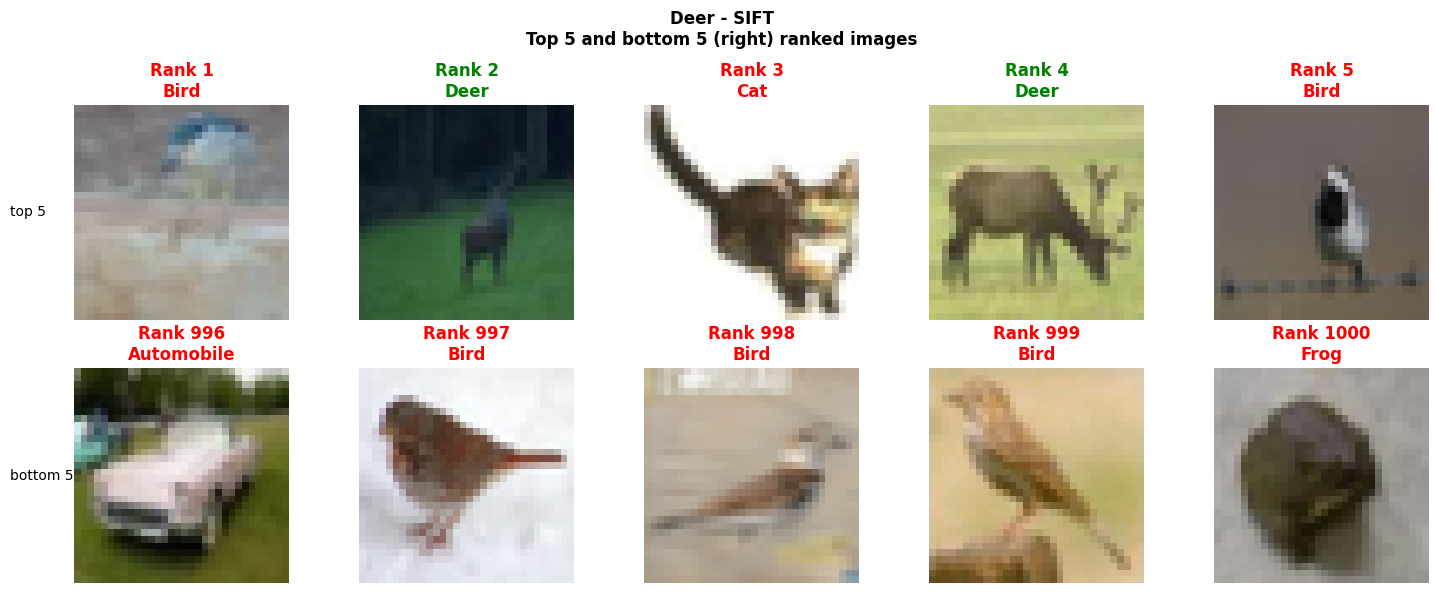


Evaluating ORB Classifier
test set: 976 images
decision scores shape: (976, 5)

ORB mAP: 23.76%
Class 0 AP: 24.64%
Class 1 AP: 24.67%
Class 2 AP: 23.05%
Class 3 AP: 22.05%
Class 4 AP: 24.40%


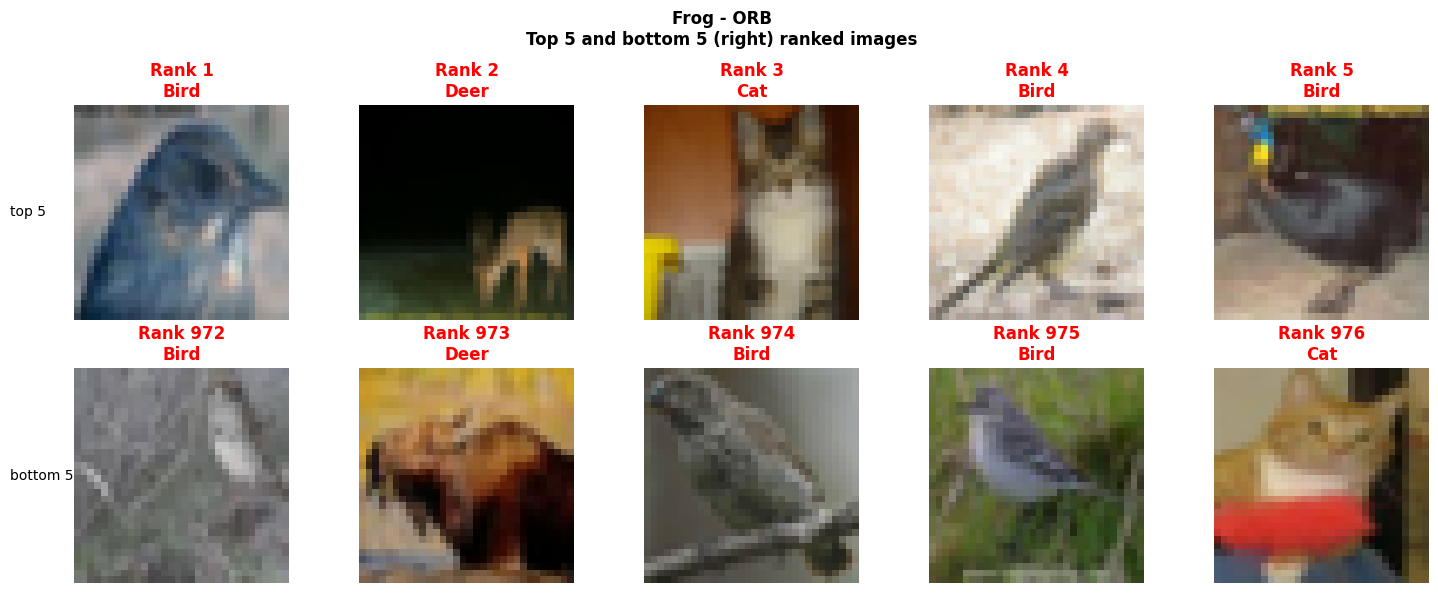

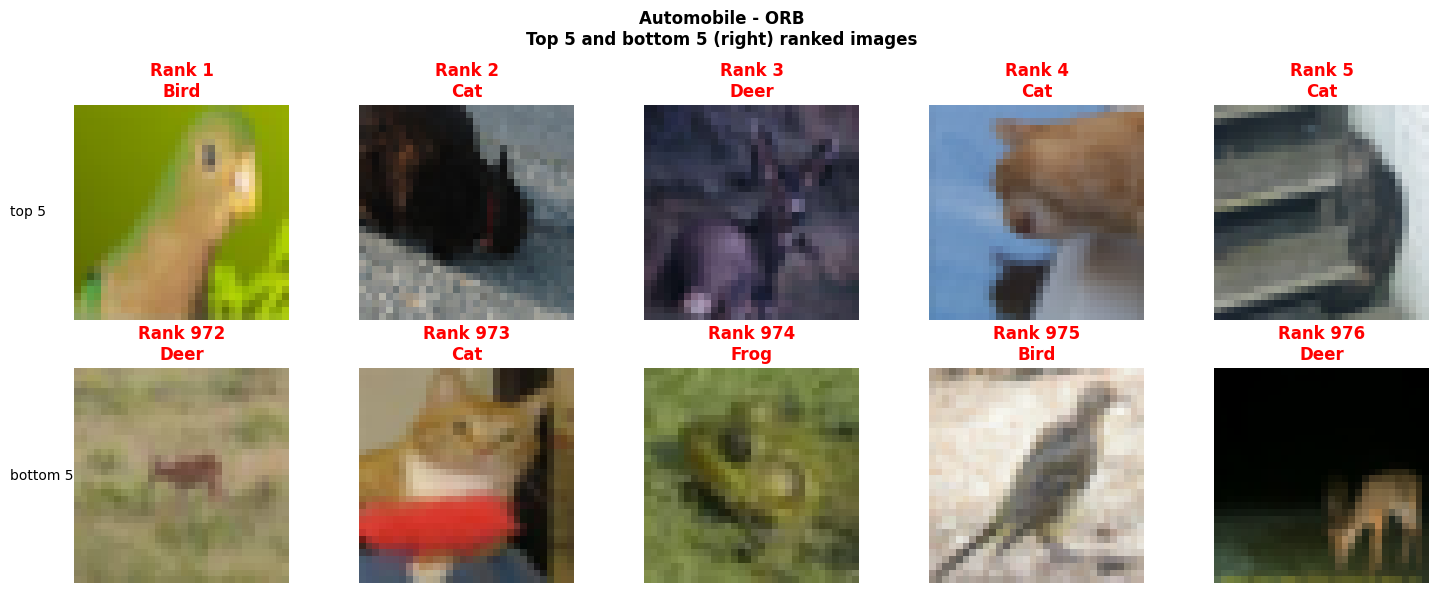

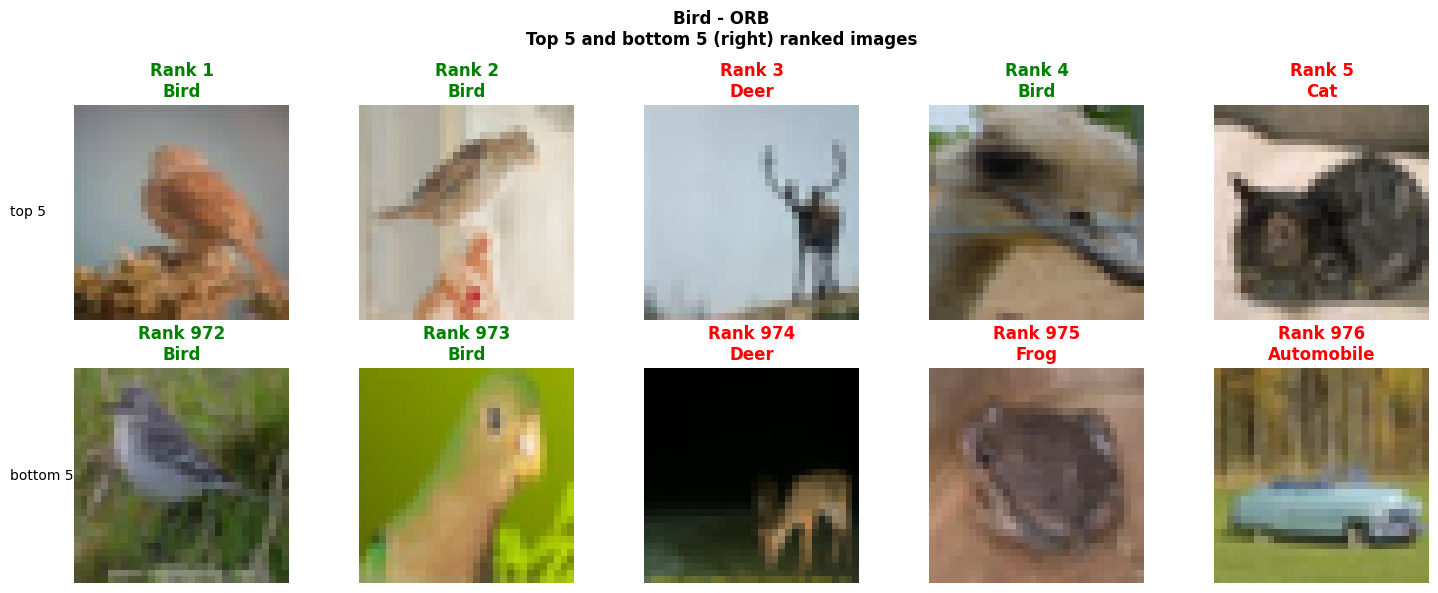

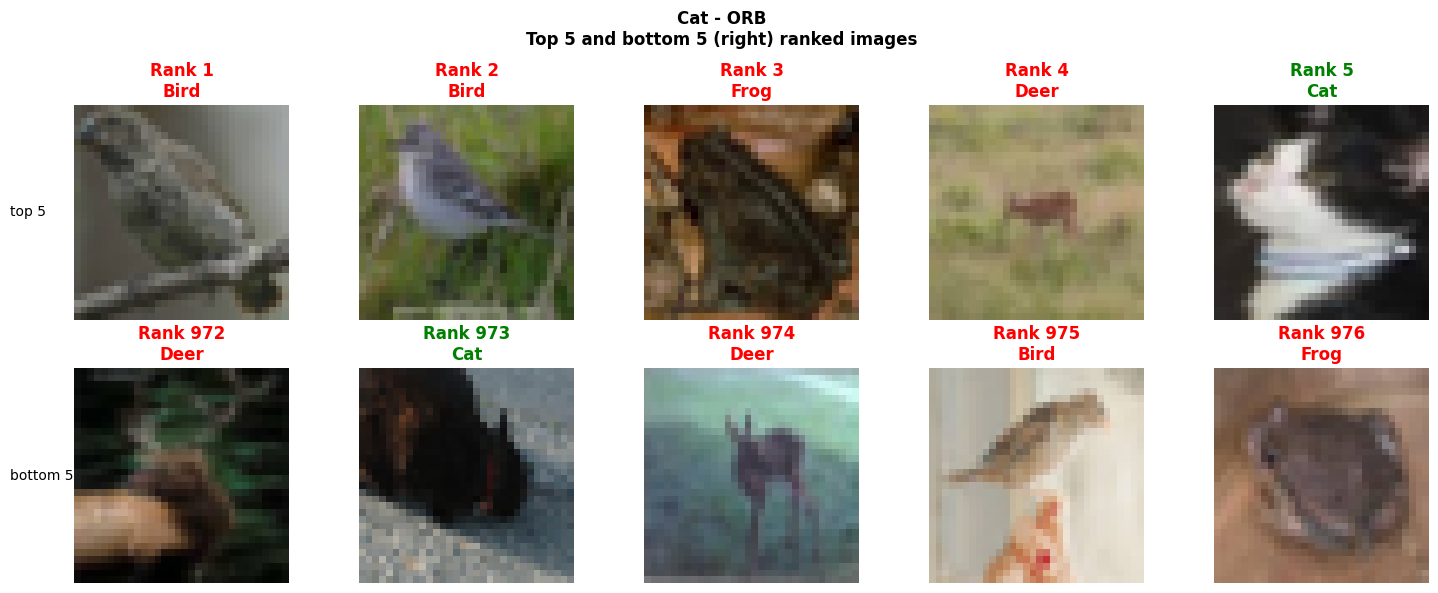

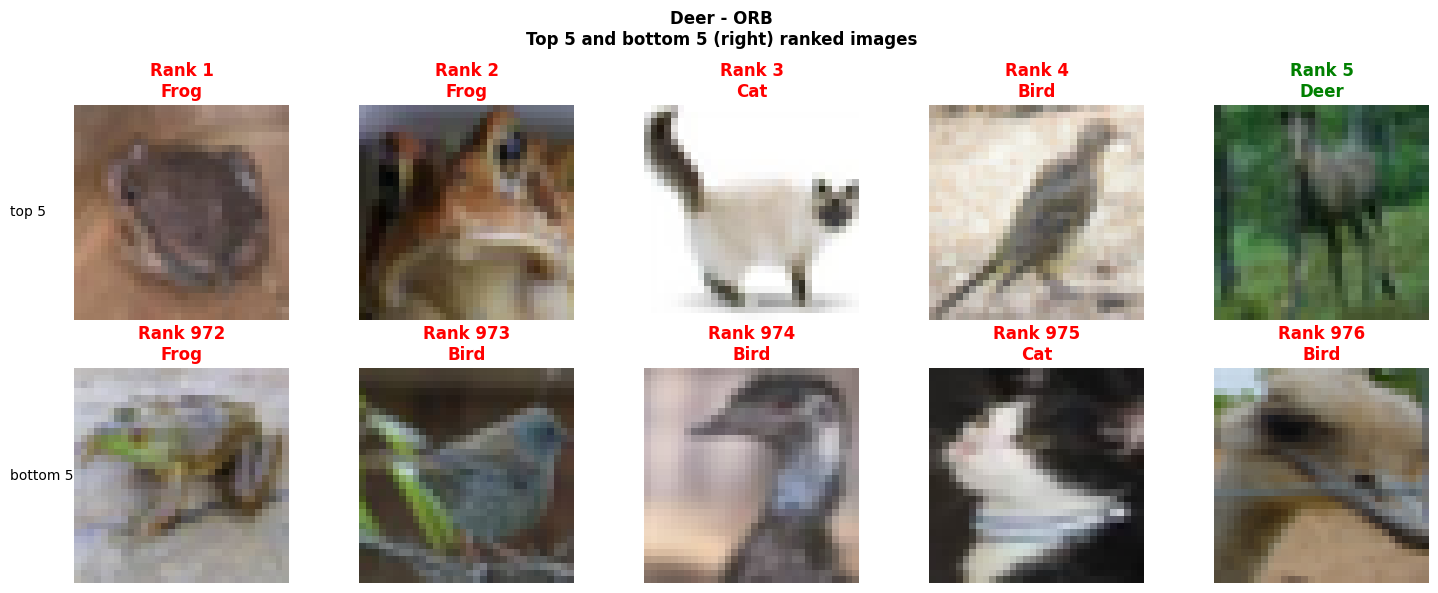

In [32]:
results = {}

for detector_name in ['SIFT', 'ORB']:
    print(f"\n{'='*70}")
    print(f"Evaluating {detector_name} Classifier")
    print(f"{'='*70}")

    # Get test data
    test_x =  np.array(encoded_test_features[detector_name][0.5]['features'])
    test_y = np.array(encoded_test_features[detector_name][0.5]['labels'])

    # Get trained classifier
    clf = classifiers[detector_name]

    # Get decision scores for ranking
    decision_scores = clf.decision_function(test_x)

    print(f"test set: {test_x.shape[0]} images")
    print(f"decision scores shape: {decision_scores.shape}")

    # Compute mAP
    mAP, APs = calc_mAP(test_y, decision_scores, num_classes=num_classes)
    results[detector_name] = {
        "mAP": mAP,
        "APs": APs
    }

    print(f"\n{detector_name} mAP: {mAP*100:.2f}%")
    for class_idx, ap in enumerate(APs):
        print(f"Class {class_idx} AP: {ap*100:.2f}%")


    visualize_top_bottom_ranked_images(5, decision_scores, test_y, detector_name)

<a id="section-9"></a>
### **Section 9: Hyperparameter Search (16 points)**

In this section, the task is to perform an extensive hyperparameter search to optimize the performance of your classifiers. You will experiment with various parameters, including the number of visual words (e.g., 500, 1000, 1500), different training subset sizes (e.g., 30%, 40%, 50%), SVM parameters (e.g., kernel types like 'linear' or 'rbf', regularization parameter $C$ values such as 0.1, 1, 10, and gamma settings like 'scale' or specific values such as 0.01, 0.001), and settings of the feature extractors (e.g., the number of keypoints or scale levels). Start by testing your code on the smallest subset to ensure it functions correctly before proceeding with a full hyperparameter search. Once validated, conduct the search using larger subsets and systematically iterate through the different parameter combinations, potentially using nested loops or grid search. Be sure to record the performance results for each combination to identify the best settings based on metrics like the Mean Average Precision (mAP).

In [33]:
class FitAndEvaluationParams:
    def __init__(self, detector_type, nfeatures, upscale_factor, num_visual_words, training_subset_size, svm_kernel, svm_C, svm_gamma):
        self.detector_type = detector_type
        self.nfeatures = nfeatures
        self.upscale_factor = upscale_factor
        self.num_visual_words = num_visual_words
        self.training_subset_size = training_subset_size
        self.svm_kernel = svm_kernel
        self.svm_C = svm_C
        self.svm_gamma = svm_gamma

    def __str__(self):
        return (f"Detector: {self.detector_type}, nfeatures: {self.nfeatures}, "
                f"Upscale: {self.upscale_factor}, Visual Words: {self.num_visual_words}, "
                f"Subset Size: {self.training_subset_size}, SVM Kernel: {self.svm_kernel}, "
                f"C: {self.svm_C}, Gamma: {self.svm_gamma}")


class FitAndEvaluationTestResult:
    def __init__(self, params):
        self.params = params
        self.mAP = None
        self.test_accuracy = None
        self.training_time = None

    def set_results(self, mAP, test_accuracy, training_time):
        self.mAP = mAP
        self.test_accuracy = test_accuracy
        self.training_time = training_time



In [34]:
# In order to avoid recomputing everything from scratch, we will save intermediate results (vocabularies, encoded features, classifiers etc..)
# So we can have some cache helper classes

import pickle
import os

class VocabularyCache:
    def __init__(self):
        self.cache = {}

    def get_key(self, detector_type, nfeatures, upscale_factor, num_visual_words, training_subset_size):
        return (detector_type, nfeatures, upscale_factor, num_visual_words, training_subset_size)

    def get(self, key):
        return self.cache.get(key)

    def set(self, key, vocabulary):
        self.cache[key] = vocabulary

    def save(self, filename='vocab_cache.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self.cache, f)

    def load(self, filename='vocab_cache.pkl'):
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                self.cache = pickle.load(f)
            return True
        return False



class EncodedFeaturesCache:

    def __init__(self):
        self.cache = {}

    def get_key(self, detector_type, nfeatures, upscale_factor, num_visual_words, training_percentage):
        return (detector_type, nfeatures, upscale_factor, num_visual_words, training_percentage)

    def get(self, key):
        return self.cache.get(key)

    def set(self, key, features):
        self.cache[key] = features

In [35]:
import time

def build_vocabulary_cached(detector_type, nfeatures, upscale_factor, num_visual_words, training_subset_size, train_images, vocab_cache):
    """
    Build visual vocabulary with caching
    Args:
        detector_type: 'SIFT' or 'ORB'
        nfeatures: number of features for detector
        upscale_factor: factor to upscale images
        num_visual_words: number of visual words
        training_subset_size: percentage of training data to use
        train_images: training images
        vocab_cache: VocabularyCache
    """

    cache_key = vocab_cache.get_key(detector_type, nfeatures, upscale_factor, num_visual_words, training_subset_size)

    # check cache
    cached_vocab = vocab_cache.get(cache_key)
    if cached_vocab is not None:
        print(f"cache hit for vocabulary for {cache_key}")
        return cached_vocab

    # build vocabulary
    print(f"cache miss for vocabulary, building new vocabulary for {cache_key}...")

    # Initialize detector
    if detector_type == 'SIFT': detector = cv2.SIFT_create(nfeatures=nfeatures)
    elif detector_type == 'ORB': detector = cv2.ORB_create(nfeatures=nfeatures)
    else: raise ValueError("detector_type must be 'SIFT' or 'ORB'")

    # Extract descriptors
    voc_descriptors, voc_num_images = extract_all_descriptors(train_images, detector, training_subset_size, upscale_factor)

    if len(voc_descriptors) == 0:raise ValueError("No descriptors!")

    voc_descriptors = voc_descriptors.astype(np.float32)

    # build the vocabulary
    kmeans, visual_words = build_visual_vocabulary(
        voc_descriptors, n_clusters=num_visual_words
    )

    vocabulary = {
        'kmeans': kmeans,
        'cluster_centers': visual_words,
        'num_descriptors': len(voc_descriptors),
        'num_images': voc_num_images
    }

    # cache the vocabulary
    vocab_cache.set(cache_key, vocabulary)

    return vocabulary



def encode_dataset_cached(features_cache, images, labels, detector_type, nfeatures, upscale_factor, vocabulary, training_percentage, num_visual_words):

    """
    Encode dataset with caching
    Args:
        features_cache: EncodedTrainFeaturesCache
        images: tensor of images
        labels: tensor of labels
        detector_type: 'SIFT' or 'ORB'
        nfeatures: number of features for detector
        upscale_factor: factor to upscale images
        vocabulary: visual vocabulary
        num_visual_words: number of visual words
        training_percentage: percentage of training data used for vocabulary
    """

    cache_key = features_cache.get_key(detector_type, nfeatures, upscale_factor, num_visual_words, training_percentage)

    # check cache
    cached_features = features_cache.get(cache_key)
    if cached_features is not None:
        print(f"cache hit for features for {cache_key}")
        return cached_features['features'], cached_features['indices']


    print(f"cache miss for features, encoding new features for {cache_key}...")
    if detector_type == 'SIFT': detector = cv2.SIFT_create(nfeatures=nfeatures)
    else: detector = cv2.ORB_create(nfeatures=nfeatures)

    features, valid_indices = encode_dataset_bovw(images, labels, detector, vocabulary, detector_type, upscale_factor)

    # cache the features
    features_cache.set(cache_key, {'features': features, 'indices': valid_indices})

    return features, valid_indices



def perform_fit_and_evaluation_test(params, vocab_cache, train_features_cache, test_features_cache):
    """
    Fit and evaluate BoVW + SVM classifier with given parameters

    args:
        params: FitAndEvaluationParams
        vocab_cache: VocabularyCache
        train_features_cache: EncodedFeaturesCache for training data
        test_features_cache: EncodedFeaturesCache for test data
    """

    upscale_factor, detector_type, nfeatures, num_visual_words, vocabulary_percentage, svm_kernel, svm_C, svm_gamma = (
        params.upscale_factor,
        params.detector_type,
        params.nfeatures,
        params.num_visual_words,
        params.training_subset_size,
        params.svm_kernel,
        params.svm_C,
        params.svm_gamma
    )


    print("\n" + "="*70)
    print("Testing configuration:")
    print(params)
    print("="*70)


    # 1) Build visual vocabulary
    vocabulary = build_vocabulary_cached(
        detector_type,
        nfeatures,
        upscale_factor,
        num_visual_words,
        vocabulary_percentage,
        train_images,
        vocab_cache
    )


    print(f"\nVocabulary built with {len(voc_descriptors):,} descriptors from {voc_num_images} images")

    # 2) Encode training images
    start_index = int(len(train_images) * vocabulary_percentage)
    remaining_train_images = train_images[start_index:]
    remaining_train_labels = train_labels[start_index:]

    train_x, train_valid_indices = encode_dataset_cached(
        train_features_cache,
        remaining_train_images,
        remaining_train_labels,
        detector_type,
        nfeatures,
        upscale_factor,
        vocabulary,
        vocabulary_percentage,
        num_visual_words
    )

    train_y = remaining_train_labels[train_valid_indices]


     # 3) Train SVM
    print("Fitting classifier...")
    if svm_kernel == 'linear': clf = OneVsRestClassifier(SVC(kernel=svm_kernel, C=svm_C, probability=False))
    else: clf = OneVsRestClassifier(SVC(kernel=svm_kernel, C=svm_C, gamma=svm_gamma, probability=False))

    start_time = time.time()
    clf.fit(train_x, train_y)
    training_time = time.time() - start_time

    print(f"Training complete in {training_time:.2f} seconds")

    # 4) Evaluate on test set
    test_x, test_valid_indices = encode_dataset_cached(
        test_features_cache,
        test_images,
        test_labels,
        detector_type,
        nfeatures,
        upscale_factor,
        vocabulary,
        vocabulary_percentage,
        num_visual_words
    )

    test_y = test_labels[test_valid_indices]

    y_test_pred = clf.predict(test_x)
    test_accuracy = (y_test_pred == np.array(test_y)).mean()
    print(f"Test accuracy: {test_accuracy*100:.2f}%")


    # 5) Calculate mAP
    decision_scores = clf.decision_function(test_x)
    mAP, _ = calc_mAP(np.array(test_y), decision_scores, num_classes=num_classes)
    print(f"{detector_type} mAP: {mAP*100:.2f}%")

    # Save results
    result = FitAndEvaluationTestResult(params)
    result.set_results(
        mAP=mAP,
        test_accuracy=test_accuracy,
        training_time=training_time,
    )

    return result


In [36]:
# test
test_params = FitAndEvaluationParams(
    detector_type='ORB',
    nfeatures=1000,
    upscale_factor=4,
    num_visual_words=1000,
    training_subset_size=0.2,
    svm_kernel='linear',
    svm_C=1,
    svm_gamma='scale'
)

test_result = perform_fit_and_evaluation_test(test_params, VocabularyCache(), EncodedFeaturesCache(), EncodedFeaturesCache())


Testing configuration:
Detector: ORB, nfeatures: 1000, Upscale: 4, Visual Words: 1000, Subset Size: 0.2, SVM Kernel: linear, C: 1, Gamma: scale
cache miss for vocabulary, building new vocabulary for ('ORB', 1000, 4, 1000, 0.2)...
Extracting descriptors from 1000 images (params=upscale_factor=4, detector=ORB)...
Descriptor extraction completed. Found 980 descriptors.
  Total descriptors extracted: 27015
  Images with descriptors: 980/1000

Vocabulary built with 65,585 descriptors from 2500 images
cache miss for features, encoding new features for ('ORB', 1000, 4, 1000, 0.2)...
Encoding 4000 images using ORB...
Valid images: 3910/4000
Feature shape: (3910, 1000)
Fitting classifier...
Training complete in 8.60 seconds
cache miss for features, encoding new features for ('ORB', 1000, 4, 1000, 0.2)...
Encoding 1000 images using ORB...
Valid images: 976/1000
Feature shape: (976, 1000)
Test accuracy: 25.72%
ORB mAP: 23.94%


In [37]:
import pandas as pd
import os

def build_dataframe_from_results(results):
    """
    Build pandas DataFrame from results list
    """
    results_data = []
    for r in results:
        results_data.append({
            'detector': r.params.detector_type,
            'nfeatures': r.params.nfeatures,
            'upscale_factor': r.params.upscale_factor,
            'num_visual_words': r.params.num_visual_words,
            'training_subset_size': r.params.training_subset_size,
            'svm_kernel': r.params.svm_kernel,
            'svm_C': r.params.svm_C,
            'svm_gamma': r.params.svm_gamma,
            'mAP': r.mAP,
            'test_accuracy': r.test_accuracy,
            'training_time': r.training_time,
            'total_time': r.training_time
        })

    df = pd.DataFrame(results_data)
    return df


def save_results(results):
    """
    Save hyperparameter search results to CSV
    """

    filename = f"hyperparam_results"
    results = [r for r in results if r.mAP is not None]
    df = build_dataframe_from_results(results)
    csv_filename = f"{filename}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Results saved to {csv_filename}")


def plot_results(df, save_dir=None):
    """
    Visualization of hyperparameter search results

    Args:
        df: dataframe with results
        save_dir: path to save the figures
    """

    os.makedirs(save_dir, exist_ok=True) if save_dir else None

    plots = [
        ("detector", "mAP by Detector Type", "Detector"),
        ("nfeatures", "mAP by Number of Features", "Number of Features"),
        ("upscale_factor", "mAP by Upscale Factor", "Upscale Factor"),
        ("num_visual_words", "mAP by Visual Words", "Number of Visual Words"),
        ("training_subset_size", "mAP by Training Subset Size", "Training Subset Size"),
        ("svm_kernel", "mAP by SVM Kernel", "SVM Kernel"),
        ("svm_C", "mAP by SVM C", "SVM C"),
        ("svm_gamma", "mAP by SVM Gamma", "SVM Gamma")
    ]


    for col, title, xlabel in plots:
        plt.figure(figsize=(8, 6))
        df.boxplot(column='mAP', by=col)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel('mAP')
        plt.suptitle('')
        plt.tight_layout()
        if save_dir: plt.savefig(os.path.join(save_dir, f"{col}_mAP_boxplot.png"), dpi=300, bbox_inches='tight')
        plt.show()



    # GET TOP N CONFIGURATIONS
    n = 5

    plt.figure(figsize=(8, 6))

    top = df.nlargest(n, 'mAP').reset_index(drop=True)
    bars = plt.barh(range(len(top)), top['mAP'], color='skyblue')
    plt.yticks(range(len(top)), [f"Config { i + 1 }" for i in range(len(top))])
    plt.xlabel('mAP')
    plt.title(f'Top {n} Configs by mAP')
    plt.gca().invert_yaxis()

    for i, bar in enumerate(bars): plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{top.iloc[i]["mAP"]:.3f}', va='center', ha='left', fontsize=7)
    plt.tight_layout()

    if save_dir: plt.savefig(os.path.join(save_dir, "top10_configurations.png"), dpi=300, bbox_inches='tight')
    plt.show()


    top = df.nlargest(n, 'mAP')[['detector', 'nfeatures', 'upscale_factor', 'num_visual_words', 'training_subset_size', 'svm_kernel', 'svm_C', 'svm_gamma', 'mAP', 'test_accuracy', 'training_time']].reset_index(drop=True)

    # Print top n configurations table
    print("\n" + "="*80)
    print(f"TOP {n} CONFIGURATIONS BY mAP")
    print("="*80)
    print(top.to_string(index=False))

    if save_dir: top.to_csv(os.path.join(save_dir, f"top{n}_configurations.csv"), index=False)


    # ----------
    # GET WORST N CONFIGURATIONS
    n = 5

    plt.figure(figsize=(8, 6))

    worst = df.nsmallest(n, 'mAP').reset_index(drop=True)
    bars = plt.barh(range(len(worst)), worst['mAP'], color='salmon')
    plt.yticks(range(len(worst)), [f"Config { i + 1 }" for i in range(len(worst))])
    plt.xlabel('mAP')
    plt.title(f'Worst {n} Configs by mAP')
    plt.gca().invert_yaxis()

    for i, bar in enumerate(bars):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{worst.iloc[i]["mAP"]:.3f}', va='center', ha='left', fontsize=7)

    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, f"worst{n}_configurations.png"), dpi=300, bbox_inches='tight')
    plt.show()

    worst = df.nsmallest(n, 'mAP')[['detector', 'nfeatures', 'upscale_factor', 'num_visual_words', 'training_subset_size', 'svm_kernel', 'svm_C', 'svm_gamma', 'mAP', 'test_accuracy', 'training_time']].reset_index(drop=True)

    # Print worst n configurations table
    print("\n" + "="*80)
    print(f"WORST {n} CONFIGURATIONS BY mAP")
    print("="*80)
    print(worst.to_string(index=False))

    if save_dir:
        worst.to_csv(os.path.join(save_dir, f"worst{n}_configurations.csv"), index=False)


In [38]:
# Hyperparameter grid search
import itertools

# feature extractor parameters
upscale_factor_options = [4, 2]
detector_types = ['SIFT', 'ORB']
nfeatures_options = [500, 1000]

# visual vocabulary parameters
num_visual_words_options = [500, 1000, 1500]
training_subset_sizes = [0.3, 0.4, 0.5]


# support vector machine parameters
svm_kernels = ['linear', 'rbf']
svm_C_values = [0.1, 1, 10]
svm_gamma_values = ['scale', 0.01, 0.001]


param_combinations = list(itertools.product(
    detector_types,
    nfeatures_options,
    upscale_factor_options,
    num_visual_words_options,
    training_subset_sizes,
    svm_kernels,
    svm_C_values,
    svm_gamma_values
))

print(f"\nTotal parameter combinations to test: {len(param_combinations)}")



Total parameter combinations to test: 1296


At first we tried to run sequantially, but it took too long. So we used the `joblib` library to parallelize the hyperparameter search process.
Tough with parallelization, the hyperparameter search still takes too much because the caching becomes less effective (as jobs starts parallelly, they cannot reuse the already computed results).

In [39]:
# from joblib import Parallel, delayed
# from tqdm.auto import tqdm
# import multiprocessing

# def worker(param_tuple, vocab_cache, train_features_cache, test_features_cache):
#     params = FitAndEvaluationParams(
#         detector_type=param_tuple[0],
#         nfeatures=param_tuple[1],
#         upscale_factor=param_tuple[2],
#         num_visual_words=param_tuple[3],
#         training_subset_size=param_tuple[4],
#         svm_kernel=param_tuple[5],
#         svm_C=param_tuple[6],
#         svm_gamma=param_tuple[7]
#     )
#     try:
#         result = perform_fit_and_evaluation_test(
#             params, vocab_cache, train_features_cache, test_features_cache
#         )
#         return result
#     except Exception as e:
#         print(f"Error with parameters {params}: {e}")
#         return None


# n_jobs = multiprocessing.cpu_count() - 1 # leave one core free
# print(f"using {n_jobs} parallel jobs")

# vocab_cache = VocabularyCache()
# train_features_cache = EncodedFeaturesCache()
# test_features_cache = EncodedFeaturesCache()


# results = Parallel(n_jobs=n_jobs, backend='threading')(
#     delayed(worker)(param_tuple, vocab_cache, train_features_cache, test_features_cache)
#     for param_tuple in tqdm(param_combinations, desc="Evaluating parameter combinations")
# )


# results = [r for r in results if r is not None]

# # Save results to CSV
# save_results(results)

# print("Number of successful tests:", len(results))

Therfore, we decied to first compute separately
- the cache of all possibile vocaboulary that we will need in the hyperparameter search (with multi threading)
- the cache of all possibile encoded train images that we will need in the hyperparameter search (with multi threading)

and then we run the hyperparameter search (with multi threading) reusing the precomputed results

It still takes 30 minutes to compute 300 hyperparameter combinations

In [40]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import multiprocessing

vocab_cache = VocabularyCache()
train_features_cache = EncodedFeaturesCache()
test_features_cache = EncodedFeaturesCache()

n_jobs = multiprocessing.cpu_count() - 1
print(f"Using {n_jobs} parallel jobs")

def safe_build_vocabulary(det, nf, up, nvw, train_size, images):
    key = vocab_cache.get_key(det, nf, up, nvw, train_size)
    vocab = vocab_cache.get(key)
    if vocab is None:
        try:
            vocab = build_vocabulary_cached(det, nf, up, nvw, train_size, images, vocab_cache)
        except Exception as e:
            print(f"Failed to build vocabulary for {det,nf,up,nvw,train_size}: {e}")
            return None
    return vocab

def safe_encode_test_dataset(images, labels, det, nf, up, nvw, train_size, features_cache):
    vocab = safe_build_vocabulary(det, nf, up, nvw, train_size, train_images)
    if vocab is None:
        return None, None
    try:
        return encode_dataset_cached(features_cache, images, labels, det, nf, up, vocab, train_size, nvw)
    except Exception as e:
        print(f"Failed to encode test dataset for {det,nf,up,nvw,train_size}: {e}")
        return None, None

def safe_encode_training_subset(det, nf, up, nvw, train_size):
    vocab = safe_build_vocabulary(det, nf, up, nvw, train_size, train_images)
    if vocab is None: return None, None

    start_index = int(len(train_images) * train_size)
    remaining_train_images = train_images[start_index:]
    remaining_train_labels = train_labels[start_index:]

    try:
        return encode_dataset_cached(
            train_features_cache,
            remaining_train_images,
            remaining_train_labels,
            det, nf, up, vocab, train_size, nvw
        )
    except Exception as e:
        print(f"Failed to encode training subset: {e}")
        return None, None



# =====================================================
# build all vocabularies and feature caches (threading)
# =====================================================

unique_params = list({
    (p[0], p[1], p[2], p[3], p[4])
    for p in param_combinations
})

print(f"\nBuilding {len(unique_params)} unique vocabularies...")

Parallel(n_jobs=n_jobs, backend='threading')(
    delayed(safe_build_vocabulary)(det, nf, up, nvw, train_size, train_images)
    for (det, nf, up, nvw, train_size) in tqdm(unique_params)
)

print(f"\nEncoding {len(unique_params)} unique training feature sets...")
Parallel(n_jobs=n_jobs, backend='threading')(
    delayed(safe_encode_training_subset)(det, nf, up, nvw, train_size)
    for (det, nf, up, nvw, train_size) in tqdm(unique_params)
)

print(f"\nEncoding {len(unique_params)} unique test feature sets...")
Parallel(n_jobs=n_jobs, backend='threading')(
    delayed(safe_encode_test_dataset)(test_images, test_labels, det, nf, up, nvw, train_size, test_features_cache)
    for (det, nf, up, nvw, train_size) in tqdm(unique_params)
)

# =====================================================
# evaluation
# =====================================================

def worker(param_tuple):
    params = FitAndEvaluationParams(
        detector_type=param_tuple[0],
        nfeatures=param_tuple[1],
        upscale_factor=param_tuple[2],
        num_visual_words=param_tuple[3],
        training_subset_size=param_tuple[4],
        svm_kernel=param_tuple[5],
        svm_C=param_tuple[6],
        svm_gamma=param_tuple[7]
    )
    try:
        return perform_fit_and_evaluation_test(
            params, vocab_cache, train_features_cache, test_features_cache
        )
    except Exception as e:
        print(f"Error with parameters {params}: {e}")
        return None

print("\nRunning evaluations (Phase 2)...")
results = Parallel(n_jobs=n_jobs, backend='threading')(
    delayed(worker)(param_tuple)
    for param_tuple in tqdm(param_combinations, desc="Evaluating parameter combinations")
)


results = [r for r in results if r is not None]

save_results(results)
print(f"All evaluations complete. Results saved.")
print(f"Number of successful tests: {len(results)}")

Using 7 parallel jobs

Building 72 unique vocabularies...


  0%|          | 0/72 [00:00<?, ?it/s]

cache miss for vocabulary, building new vocabulary for ('ORB', 500, 4, 1500, 0.4)...cache miss for vocabulary, building new vocabulary for ('SIFT', 1000, 4, 1000, 0.3)...
cache miss for vocabulary, building new vocabulary for ('ORB', 1000, 4, 500, 0.4)...
Extracting descriptors from 2000 images (params=upscale_factor=4, detector=ORB)...

Extracting descriptors from 2000 images (params=upscale_factor=4, detector=ORB)...
cache miss for vocabulary, building new vocabulary for ('ORB', 500, 4, 1000, 0.5)...
Extracting descriptors from 2500 images (params=upscale_factor=4, detector=ORB)...
cache miss for vocabulary, building new vocabulary for ('ORB', 1000, 4, 1500, 0.3)...
Extracting descriptors from 1500 images (params=upscale_factor=4, detector=ORB)...
Extracting descriptors from 1500 images (params=upscale_factor=4, detector=SIFT)...
cache miss for vocabulary, building new vocabulary for ('SIFT', 500, 4, 500, 0.3)...
Extracting descriptors from 1500 images (params=upscale_factor=4, detec

  0%|          | 0/72 [00:00<?, ?it/s]

cache miss for features, encoding new features for ('ORB', 500, 4, 1500, 0.4)...
Encoding 3000 images using ORB...
cache miss for features, encoding new features for ('SIFT', 1000, 4, 1000, 0.3)...
cache miss for features, encoding new features for ('ORB', 1000, 4, 500, 0.4)...
Encoding 3000 images using ORB...
cache miss for features, encoding new features for ('ORB', 500, 4, 1000, 0.5)...
Encoding 2500 images using ORB...
Encoding 3500 images using SIFT...
cache miss for features, encoding new features for ('ORB', 1000, 4, 1500, 0.3)...
Encoding 3500 images using ORB...
cache miss for features, encoding new features for ('SIFT', 500, 4, 500, 0.3)...
Encoding 3500 images using SIFT...
cache miss for vocabulary, building new vocabulary for ('ORB', 500, 2, 500, 0.4)...
Extracting descriptors from 2000 images (params=upscale_factor=2, detector=ORB)...
Descriptor extraction completed. Found 148 descriptors.
  Total descriptors extracted: 148
  Images with descriptors: 148/2000
Failed to b

  0%|          | 0/72 [00:00<?, ?it/s]

cache miss for features, encoding new features for ('ORB', 500, 4, 1500, 0.4)...
Encoding 1000 images using ORB...
cache miss for features, encoding new features for ('SIFT', 1000, 4, 1000, 0.3)...
Encoding 1000 images using SIFT...
cache miss for features, encoding new features for ('ORB', 1000, 4, 500, 0.4)...
Encoding 1000 images using ORB...
cache miss for features, encoding new features for ('ORB', 500, 4, 1000, 0.5)...
Encoding 1000 images using ORB...
cache miss for features, encoding new features for ('ORB', 1000, 4, 1500, 0.3)...
Encoding 1000 images using ORB...
cache miss for features, encoding new features for ('SIFT', 500, 4, 500, 0.3)...
Encoding 1000 images using SIFT...
cache miss for vocabulary, building new vocabulary for ('ORB', 500, 2, 500, 0.4)...
Extracting descriptors from 2000 images (params=upscale_factor=2, detector=ORB)...
Descriptor extraction completed. Found 148 descriptors.
  Total descriptors extracted: 148
  Images with descriptors: 148/2000
Failed to b

Evaluating parameter combinations:   0%|          | 0/1296 [00:00<?, ?it/s]


Testing configuration:
Detector: SIFT, nfeatures: 500, Upscale: 4, Visual Words: 500, Subset Size: 0.3, SVM Kernel: linear, C: 0.1, Gamma: 0.01
cache hit for vocabulary for ('SIFT', 500, 4, 500, 0.3)

Vocabulary built with 65,585 descriptors from 2500 images
cache hit for features for ('SIFT', 500, 4, 500, 0.3)

Testing configuration:
Detector: SIFT, nfeatures: 500, Upscale: 4, Visual Words: 500, Subset Size: 0.3, SVM Kernel: linear, C: 0.1, Gamma: scale
cache hit for vocabulary for ('SIFT', 500, 4, 500, 0.3)

Vocabulary built with 65,585 descriptors from 2500 images
cache hit for features for ('SIFT', 500, 4, 500, 0.3)

Testing configuration:
Detector: SIFT, nfeatures: 500, Upscale: 4, Visual Words: 500, Subset Size: 0.3, SVM Kernel: linear, C: 0.1, Gamma: 0.001
cache hit for vocabulary for ('SIFT', 500, 4, 500, 0.3)

Vocabulary built with 65,585 descriptors from 2500 images
cache hit for features for ('SIFT', 500, 4, 500, 0.3)

Testing configuration:
Detector: SIFT, nfeatures: 500, 

In [51]:
print(results)

[<__main__.FitAndEvaluationTestResult object at 0x347795130>, <__main__.FitAndEvaluationTestResult object at 0x3601e6e10>, <__main__.FitAndEvaluationTestResult object at 0x3603636b0>, <__main__.FitAndEvaluationTestResult object at 0x15f74a450>, <__main__.FitAndEvaluationTestResult object at 0x360361d90>, <__main__.FitAndEvaluationTestResult object at 0x3603639b0>, <__main__.FitAndEvaluationTestResult object at 0x360285010>, <__main__.FitAndEvaluationTestResult object at 0x322388b90>, <__main__.FitAndEvaluationTestResult object at 0x360361c10>, <__main__.FitAndEvaluationTestResult object at 0x322389a00>, <__main__.FitAndEvaluationTestResult object at 0x36031ff20>, <__main__.FitAndEvaluationTestResult object at 0x32238a5d0>, <__main__.FitAndEvaluationTestResult object at 0x360362a20>, <__main__.FitAndEvaluationTestResult object at 0x35ffb5310>, <__main__.FitAndEvaluationTestResult object at 0x360363800>, <__main__.FitAndEvaluationTestResult object at 0x3197af890>, <__main__.FitAndEvaluat

<Figure size 800x600 with 0 Axes>

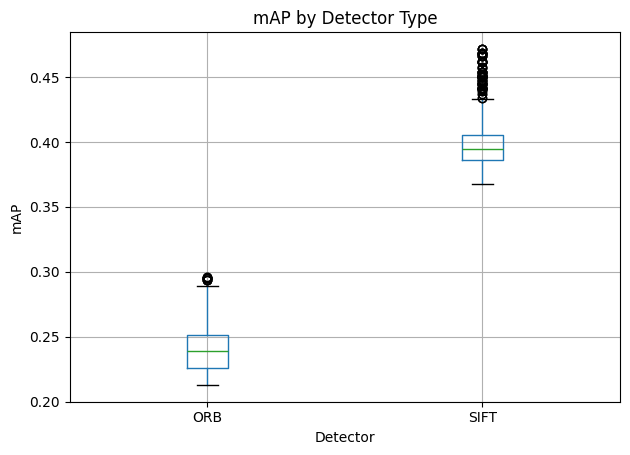

<Figure size 800x600 with 0 Axes>

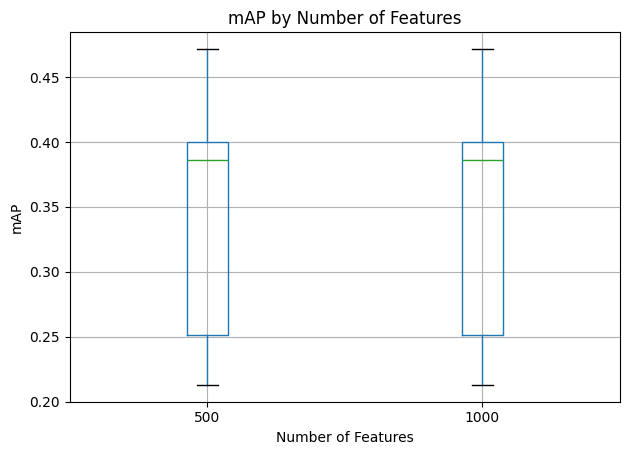

<Figure size 800x600 with 0 Axes>

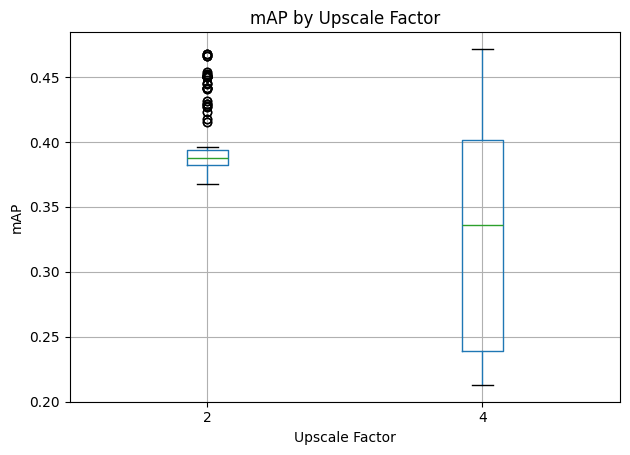

<Figure size 800x600 with 0 Axes>

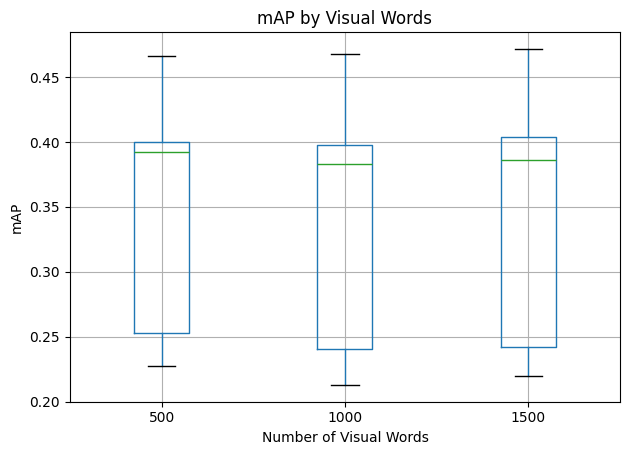

<Figure size 800x600 with 0 Axes>

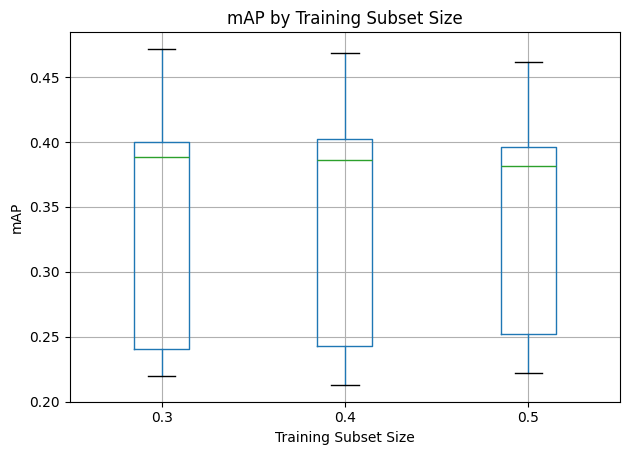

<Figure size 800x600 with 0 Axes>

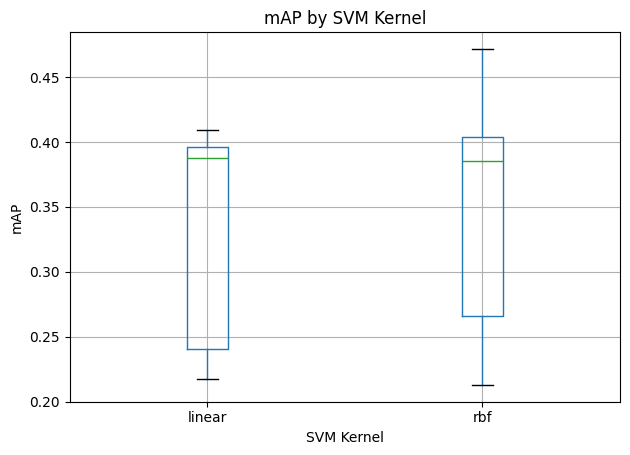

<Figure size 800x600 with 0 Axes>

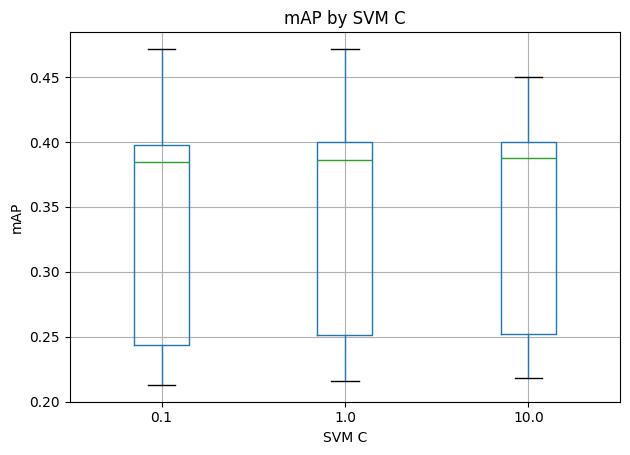

<Figure size 800x600 with 0 Axes>

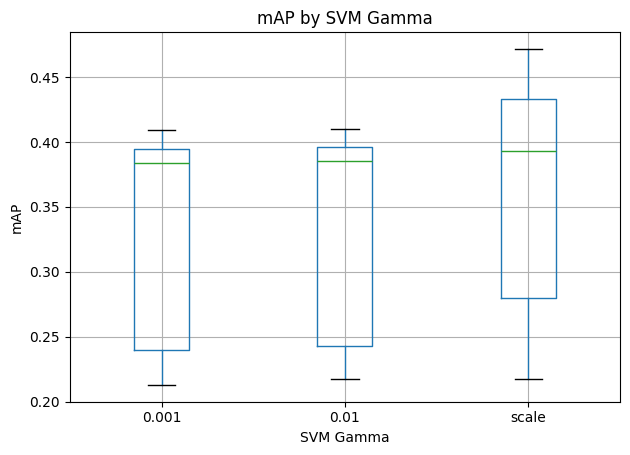

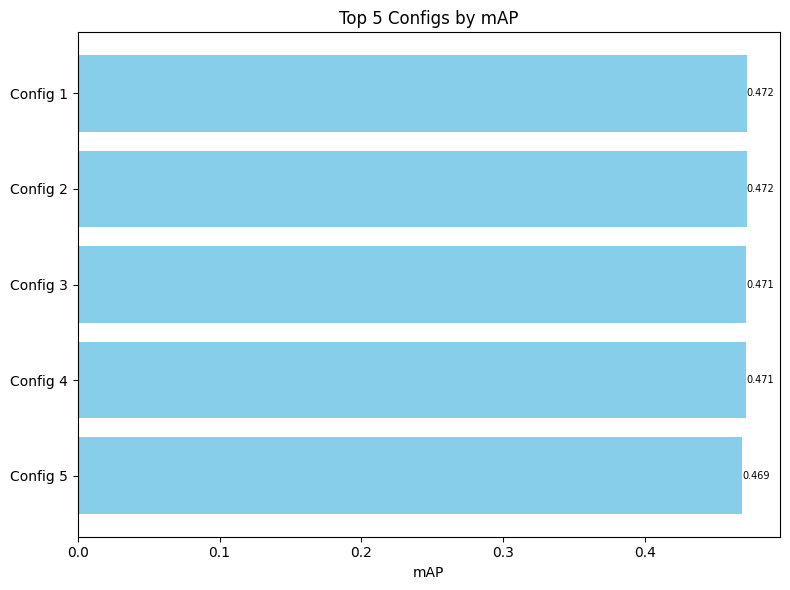


TOP 5 CONFIGURATIONS BY mAP
detector  nfeatures  upscale_factor  num_visual_words  training_subset_size svm_kernel  svm_C svm_gamma      mAP  test_accuracy  training_time
    SIFT        500               4              1500                   0.3        rbf    1.0     scale 0.471597          0.482      66.060312
    SIFT       1000               4              1500                   0.3        rbf    1.0     scale 0.471597          0.482      68.593229
    SIFT        500               4              1500                   0.3        rbf    0.1     scale 0.471353          0.479      70.828706
    SIFT       1000               4              1500                   0.3        rbf    0.1     scale 0.471353          0.479      73.730656
    SIFT        500               4              1500                   0.4        rbf    1.0     scale 0.468511          0.454      48.707148


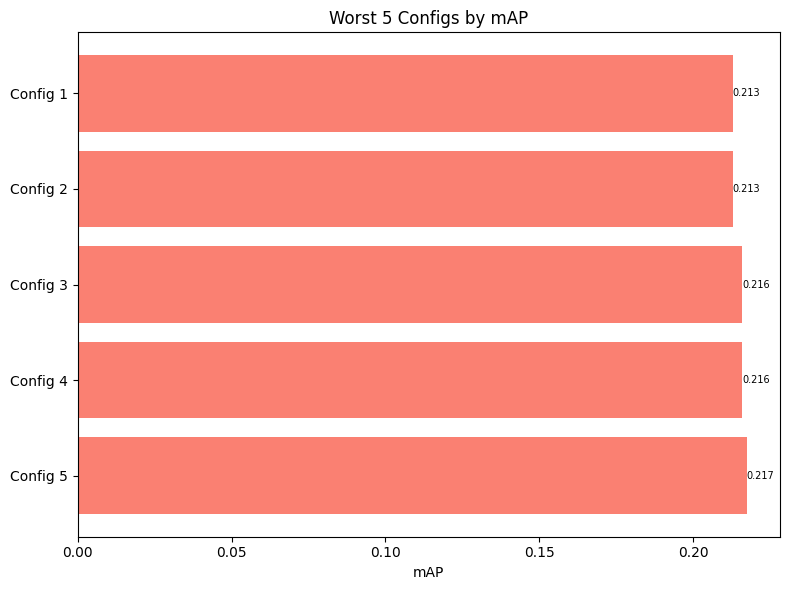


WORST 5 CONFIGURATIONS BY mAP
detector  nfeatures  upscale_factor  num_visual_words  training_subset_size svm_kernel  svm_C svm_gamma      mAP  test_accuracy  training_time
     ORB        500               4              1000                   0.4        rbf    0.1     0.001 0.212882       0.222336      19.645204
     ORB       1000               4              1000                   0.4        rbf    0.1     0.001 0.212882       0.222336      20.250016
     ORB        500               4              1000                   0.4        rbf    1.0     0.001 0.215937       0.228484      16.488488
     ORB       1000               4              1000                   0.4        rbf    1.0     0.001 0.215937       0.228484      17.102302
     ORB        500               4              1000                   0.4     linear    0.1     scale 0.217329       0.220287      21.141254


In [52]:
plot_results(build_dataframe_from_results(results), save_dir='./hyperparameter_search')

<a id="section-10"></a>
### **Section 10: Using CLIP for Image Classification (5 points)**

**<span style="color:red">⚠️ NOTE: This section should NOT be included in the report. It is only meant to be completed in the code cells. The purpose of this task is to introduce you to a more state-of-the-art model (CLIP) compared to Bag of Visual Words (BoVW). Vision Transformers (ViT) will be covered in more detail in the Deep Learning 1 course next period!</span>**

In this section, you will use a pre-trained CLIP model for image classification. CLIP (Contrastive Language-Image Pretraining) is a vision-language transformer model trained on a large dataset of images and text. It consists of two main components: a Vision Transformer (ViT) and a text Transformer. The ViT encodes images by dividing them into patches (tokens), flattening each patch into a vector, and passing them through a sequence of Transformer layers to produce an encoded representation of the image.

For this task, you will use the visual transformer component of CLIP to extract encoded representations of the input images. While this is not the typical way to use CLIP (which involves encoding both images and text for similarity comparison), it provides an interesting application of this state-of-the-art model for image classification.

**To Install CLIP:**
```python
pip install git+https://github.com/openai/CLIP.git
```

**Additional Reading (if you're interested):**
- [OpenAI CLIP Overview](https://openai.com/clip)
- [Vision Transformer (ViT) Paper](https://arxiv.org/abs/2010.11929)
- [Tutorial on Vision Transformers](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [UvA's Deep Learning Introduction to ViTs](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)

First, create DataLoaders for both the training and test datasets by filtering the CIFAR-10 dataset to include only the selected classes: frog, automobile, bird, cat, and deer. Use a batch size of 16 for both DataLoaders, and resize the images to 224x224 to match the input size requirements for CLIP. Remember to normalize the images using the appropriate mean and standard deviation. Use a training set size of 1000 images per class and a test set size of 200 images per class.

In [43]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# Define batch sizes for DataLoader
train_batch_size = 16
test_batch_size = 16

# Images per class
images_per_class_train = 1000
images_per_class_test = 200

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the class indices: frog, automobile, bird, cat, deer
selected_classes = [6, 1, 2, 3, 4]
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}


# helper to remap labels (needed for batch loading)
class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, remapped_labels):
        self.subset = subset
        self.remapped_labels = remapped_labels

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, _ = self.subset[idx]
        return image, self.remapped_labels[idx]


# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

        if all(count >= images_per_class for count in class_counts.values()):
            break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Load and filter training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load and filter test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create DataLoaders
train_data_loader = DataLoader(RemappedDataset(filtered_train_set, train_mapped_labels), batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(RemappedDataset(filtered_test_set, test_mapped_labels), batch_size=test_batch_size, shuffle=False)



# Class names
class_names = ['frog', 'automobile', 'bird', 'cat', 'deer']

Files already downloaded and verified
Files already downloaded and verified


Next, we load a pre-trained CLIP model, which is a vision-language transformer designed to predict the text that describes an image and vice versa. The model consists of two components: a Vision Transformer (ViT) for encoding images and a text Transformer for encoding text.

In [44]:
import clip

# Setup the model and the preprocessor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

To extract the visual tokens using the CLIP model, start by initializing two empty lists: one for storing the image features and another for the labels. Use `tqdm` to create a progress bar that tracks the extraction process over the DataLoader. Iterate through the DataLoader, extracting images and labels. Disable gradient computation, and then encode the images with `model.encode_image(images)`. Append the encoded features and labels to their respective lists. Remember, the output from the model will have the shape `(batch_size, 512)` due to batched processing, if your are using a single you should reshape the output to `(512,)` to remove the batch dimension.

In this example, we will use the class token as the visual representation of the image. The class token is a 512-dimensional vector that represents the image. We will use this vector to train a classifier to classify the images.

**Note:** The CLIP model is quite large and may take some time to extract features from the images. You can use the `tqdm` library to create a progress bar that shows the extraction progress. It is recommended to test the code with a smaller subset of images to ensure it functions correctly before running it on the full dataset. With the default batch size of 16 and a training set size of 1000 images, the extraction process may take a 10-20 minutes.

In [45]:
from tqdm.auto import tqdm

image_features_list = []
target_labels_list = []

with torch.no_grad():
    for images, labels in tqdm(train_data_loader, desc="Extracting image features"):
        images = images.to(device)
        labels = labels.to(device)

        features = model.encode_image(images)
        image_features_list.append(features)
        target_labels_list.append(labels)

        print(f"Processed batch with {images.size(0)} images, extracted features shape: {features.shape}, labels shape: {labels.shape}")



Extracting image features:   0%|          | 0/313 [00:00<?, ?it/s]

Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Size([16])
Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Size([16])
Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Size([16])
Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Size([16])
Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Size([16])
Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Size([16])
Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Size([16])
Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Size([16])
Processed batch with 16 images, extracted features shape: torch.Size([16, 512]), labels shape: torch.Siz

In [46]:
# Stack the (batched) visual tokens extracted from the images. The resulting shape will be (number_of_images, 512).
stacked_image_features = torch.cat(image_features_list)
stacked_target_labels = torch.cat(target_labels_list)

print(f"Final stacked image features shape: {stacked_image_features.shape}")
print(f"Final stacked target labels shape: {stacked_target_labels.shape}")



Final stacked image features shape: torch.Size([5000, 512])
Final stacked target labels shape: torch.Size([5000])


To train a classifier using the visual tokens, start by initializing an SVM classifier using `SVC()` from `scikit-learn`. You can play around with different hyperparameters such as kernel type, regularization parameter, and gamma to find the best configuration. Finally, use the `fit` method to train the classifier on the visual image features and labels.

In [47]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

train_x = stacked_image_features.cpu().numpy()
train_y = stacked_target_labels.cpu().numpy()


classifier = OneVsRestClassifier(SVC(kernel='rbf', C=6, gamma='scale'))
classifier.fit(train_x, train_y)

print("Classifier training complete!")

Classifier training complete!


To evaluate the classifier, start by extracting the visual tokens from the test images using the same method applied to the training set. Loop through the test DataLoader, encode each batch of images using the model (e.g., `model.encode_image(images)`), and store the results in separate lists for the features and labels. After extracting all the features, stack them into a single tensor for both the features and labels. This process will prepare the test data for use in evaluating the classifier's performance.

In [48]:
# Extract visual features from test images
test_image_features_list = []
test_target_labels_list = []

with torch.no_grad():
    for images, labels in tqdm(test_data_loader, desc="Extracting test image features"):
        images = images.to(device)
        labels = labels.to(device)

        features = model.encode_image(images)
        test_image_features_list.append(features)
        test_target_labels_list.append(labels)

stacked_test_image_features = torch.cat(test_image_features_list)
stacked_test_target_labels = torch.cat(test_target_labels_list)


Extracting test image features:   0%|          | 0/63 [00:00<?, ?it/s]

To evaluate the performance of your classifier, use the test set features you extracted earlier. First, generate predictions for the test set by passing the stacked test features into your trained classifier's `predict` method. Next, use the `classification_report` function from `sklearn.metrics` to create a detailed report that includes metrics such as precision, recall, and F1-score for each class. Finally, print the report to analyze how well your classifier performs across the different classes.

In [49]:
from sklearn.metrics import classification_report

# Assuming you have a classifier and test features `test_x`
y_test_pred = classifier.predict(test_x)

class_report_str = classification_report(stacked_test_target_labels.cpu().numpy(), y_test_pred, target_names=class_names)

print("test set classification report:")
print(class_report_str)


ValueError: X has 1000 features, but SVC is expecting 512 features as input.

<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name | Contribution on Research | Contribution on Programming | Contribution on Writing |
| -------- | ------- | ------- | ------- |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |

### - End of Notebook -